DAAA/FT/2A/01 2214296 Ng Wee Herng AIML CA2 <br>
Part A: Time Series

## Background Information

Using the Energy Consumption Dataset to train time series models and forecast the gas consumption, electricity consumption and water consumption in the future.

#### Why is energy consumption forecasting important?
- As cities grow over the years, so has the reliance on energy in order to provide services for citizens.
- As the world tries to hit emission reduction targets, there are tremendous opportunities to improve energy efficiencies
- Energy Forecasting, the practice of using statistical data to predict consumption levels and corresponding utility expenditures for both short and long term, can help cities be more profitable, efficient and sustainable

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [2]:
data = pd.read_csv('./Energy Consumption Dataset.csv')
data

DATE  Gas Consumption (tons)  Electricity Consumption (MWh)  \
0     1/1/1990                    18.0                          725.1   
1     1/2/1990                    15.8                          706.7   
2     1/3/1990                    17.3                          624.5   
3     1/4/1990                    18.9                          574.7   
4     1/5/1990                    22.0                          553.2   
..         ...                     ...                            ...   
392   1/9/2022                    27.7                          986.2   
393  1/10/2022                    31.8                          936.1   
394  1/11/2022                    31.0                          973.4   
395  1/12/2022                    32.4                         1147.2   
396   1/1/2023                    31.3                         1294.0   

     Water Consumption (tons)  
0                       548.8  
1                       640.7  
2                       511.1  
3                       515.3  
4                       488.4  
..                        ...  
392                     513.3  
393                     373.1  
394                     343.9  
395                     348.3  
396                     260.2  

[397 rows x 4 columns]

This dataset contains 397 entries with 4 columns
 
**Date**: Day, Month, Year<br>
**Gas Consumption (tons)**: How many tons of gas consumed<br>
**Electricity Consumption (MWh)**: How much MWh of electricity consumed<br>
**Water Consumption (tons)**: How many tons of water consumed


Here, we are converting the date column into datetime format, and setting it as the index

In [3]:
data.index = pd.to_datetime(data['DATE'], format='%d/%m/%Y')
data.drop('DATE', axis=1, inplace=True)
data

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-01-01                    18.0                          725.1   
1990-02-01                    15.8                          706.7   
1990-03-01                    17.3                          624.5   
1990-04-01                    18.9                          574.7   
1990-05-01                    22.0                          553.2   
...                            ...                            ...   
2022-09-01                    27.7                          986.2   
2022-10-01                    31.8                          936.1   
2022-11-01                    31.0                          973.4   
2022-12-01                    32.4                         1147.2   
2023-01-01                    31.3                         1294.0   

            Water Consumption (tons)  
DATE                                  
1990-01-01                     548.8  
1990-02-01                     640.7  
1990-03-01                     511.1  
1990-04-01                     515.3  
1990-05-01                     488.4  
...                              ...  
2022-09-01                     513.3  
2022-10-01                     373.1  
2022-11-01                     343.9  
2022-12-01                     348.3  
2023-01-01                     260.2  

[397 rows x 3 columns]

### Stationarity

A stationary series is one in which mean, variance and covariance do not vary with time.

One way to check for stationarity is through a visual test

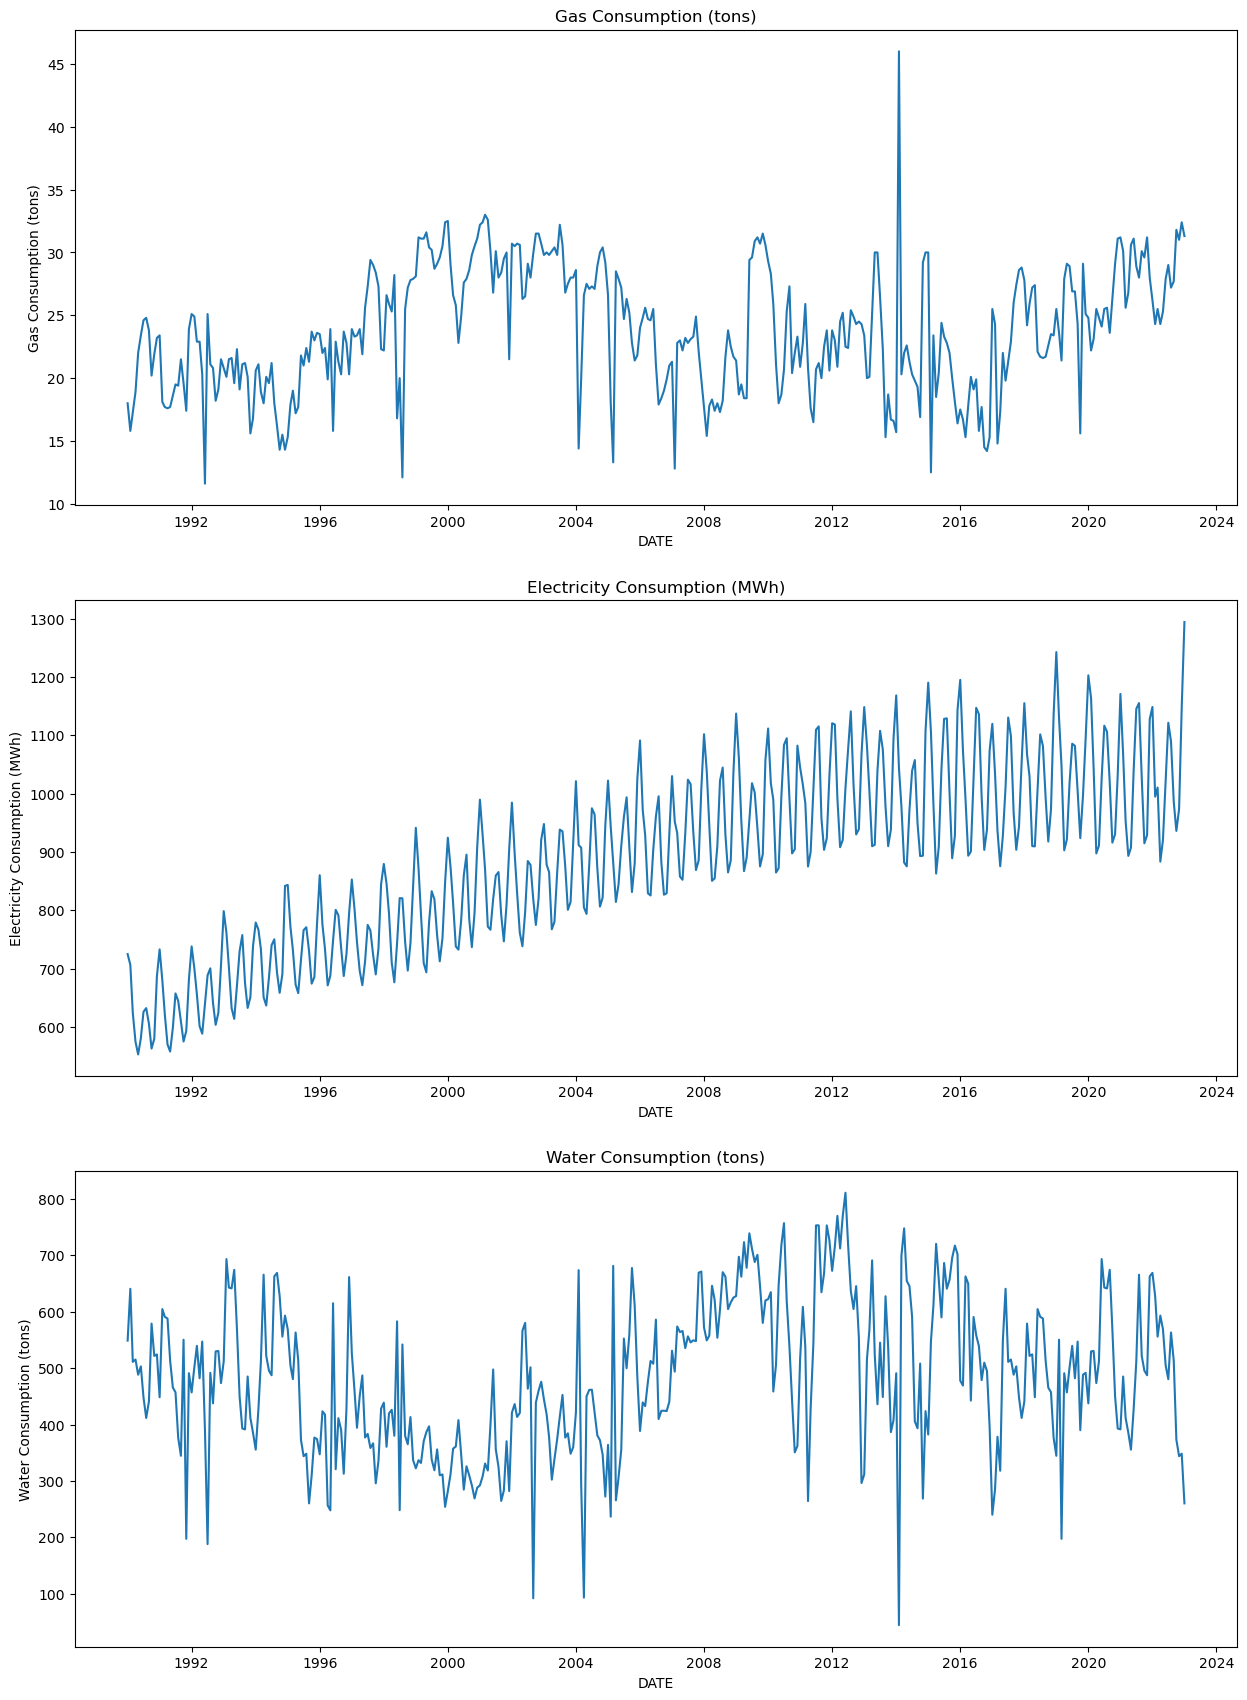

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,21))

sns.lineplot(data=data, x=data.index, y='Gas Consumption (tons)', ax=ax1)
ax1.set_title('Gas Consumption (tons)')

sns.lineplot(data=data, x=data.index, y='Electricity Consumption (MWh)', ax=ax2)
ax2.set_title('Electricity Consumption (MWh)')

sns.lineplot(data=data, x=data.index, y='Water Consumption (tons)', ax=ax3)
ax3.set_title('Water Consumption (tons)')

plt.show()

From the plot, through a visual test, we can see that:
- Gas and Water Consumption look to be stationary
- Electricity Consumption has a clear trend and does not look to be stationary

However, a visual approach may not always give us accurate results. To confirm the observations, we will be using some statistical tests

1. #### Augmented Dickey Fuller (ADF) Test
    - Null Hypothesis: The series is non-stationary
    - Alternate Hypothesis: The series is stationary

If the P-Value is < 0.05, we can reject the null hypothesis and conclude that the time series is stationary.

2. #### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
    - Null Hypothesis: The series is trend stationary
    - Alternate Hypothesis: The series is non-stationary

If the P-Value is > 0.05, we cannot reject the null hypothesis and conclude that the time series is trend stationary

In [6]:
def stat_test(data, var):
    adftest = adfuller(data[var])
    kpsstest = kpss(data[var])
    line = '-'*40
    print(f'{var}\n{line}')
    print(f'p-value with Augmented Dickey–Fuller test: {adftest[1]}')
    print(f'p-value with Kwiatkowski-Phillips-Schmidt-Shin test: {kpsstest[1]}\n')
    if adftest[1] <= 0.05:
        print(f'Series is stationary from ADF test')
    else:
        print(f'Series is not stationary from ADF test')
    if kpsstest[1] > 0.05:
        print(f'Series is trend stationary from KPSS test\n')
    else:
        print(f'Series is not trend stationary from KPSS test\n')

stat_test(data, 'Gas Consumption (tons)')
stat_test(data, 'Electricity Consumption (MWh)')
stat_test(data, 'Water Consumption (tons)')

Gas Consumption (tons)
----------------------------------------
p-value with Augmented Dickey–Fuller test: 0.010810651707060586
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.1

Series is stationary from ADF test
Series is trend stationary from KPSS test

Electricity Consumption (MWh)
----------------------------------------
p-value with Augmented Dickey–Fuller test: 0.1862180230033646
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.01

Series is not stationary from ADF test
Series is not trend stationary from KPSS test

Water Consumption (tons)
----------------------------------------
p-value with Augmented Dickey–Fuller test: 8.984549388337042e-05
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.01

Series is stationary from ADF test
Series is not trend stationary from KPSS test



From the statistical tests, we can see that:

- Gas Consumption is stationary
- Electricity Consumption is not stationary

For Water Consumption, ADF test concludes that the series is stationary but KPSS test concludes that the series is not trend stationary. This means that the differencing may need to be used to make the series stationary

### Seasonal Decomposition

Seasonal Decomposition is a method used in time series analysis to represent a time series as a sum(additive)/product(multiplicative) of three components:

1. Linear Trend
2. Seasonal Component
3. Random Residuals

It is useful in analysing the time series affected by factors that change the time in a periodical manner

Seasonal 12


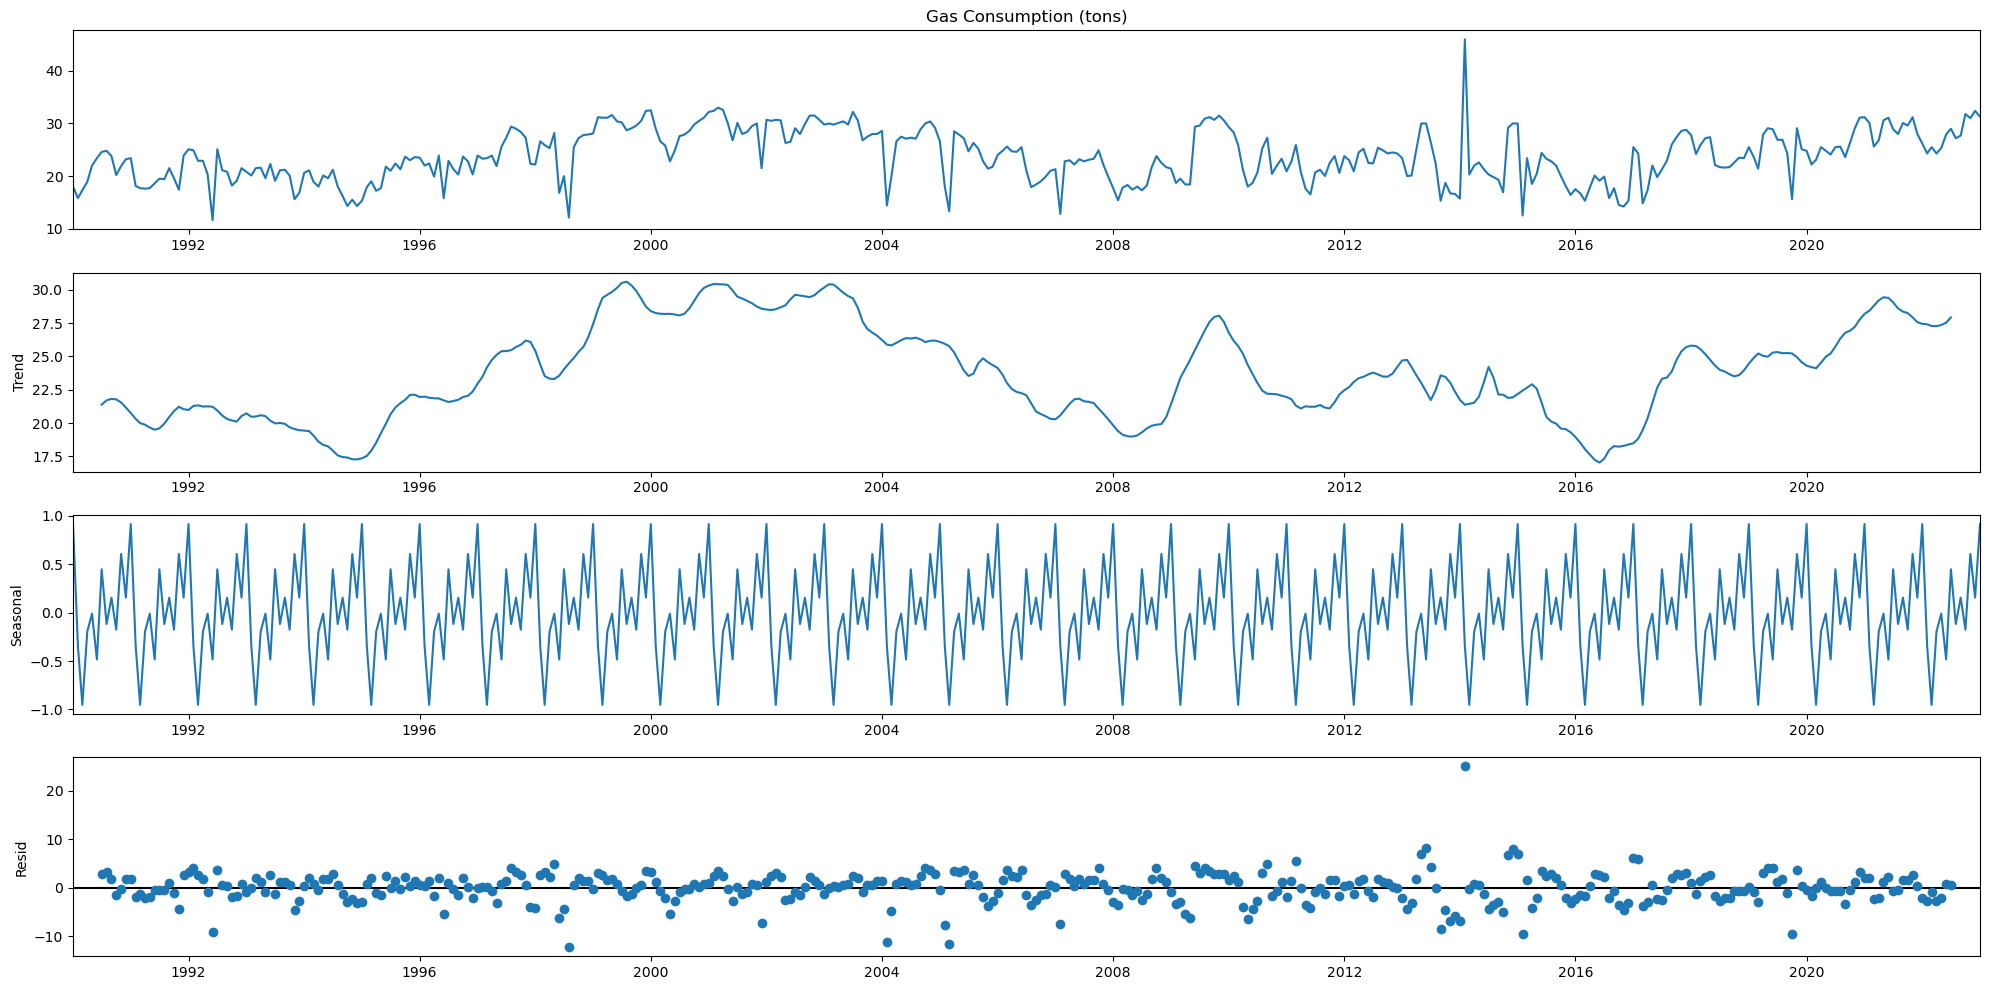

Seasonal 12


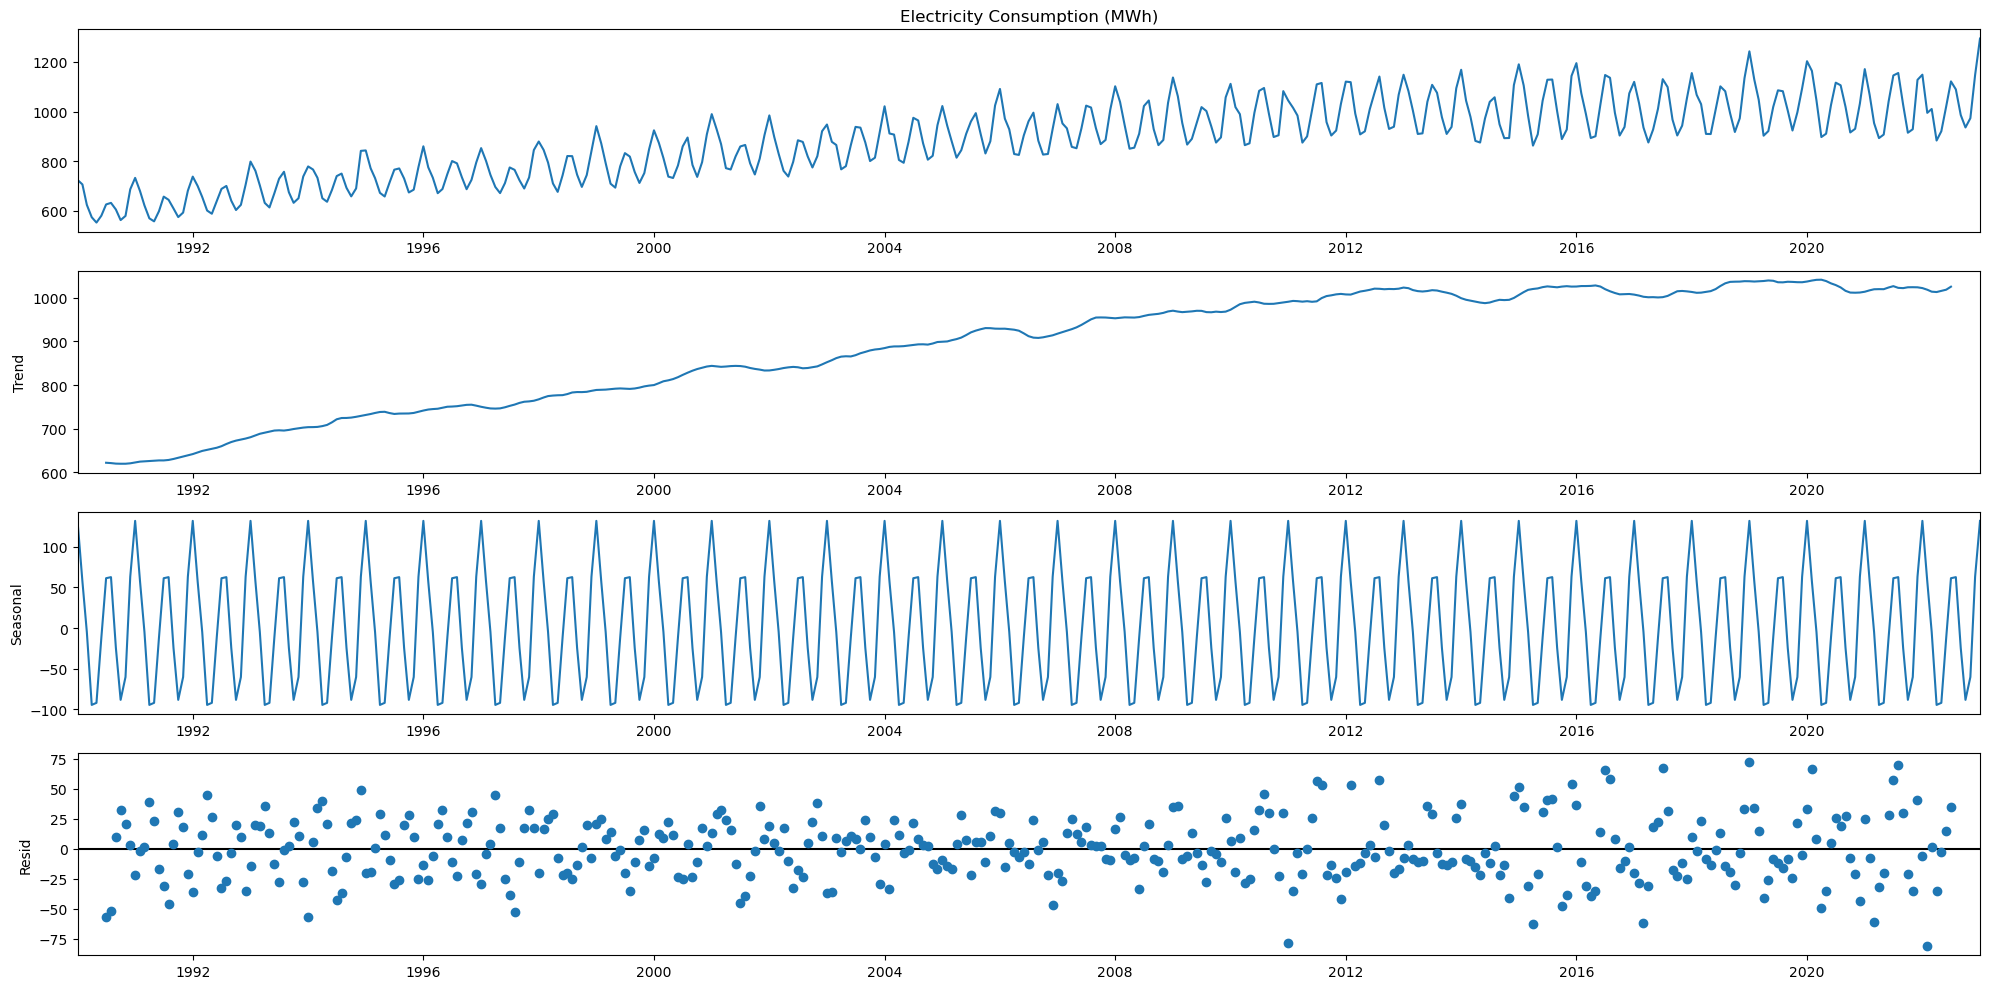

Seasonal 12


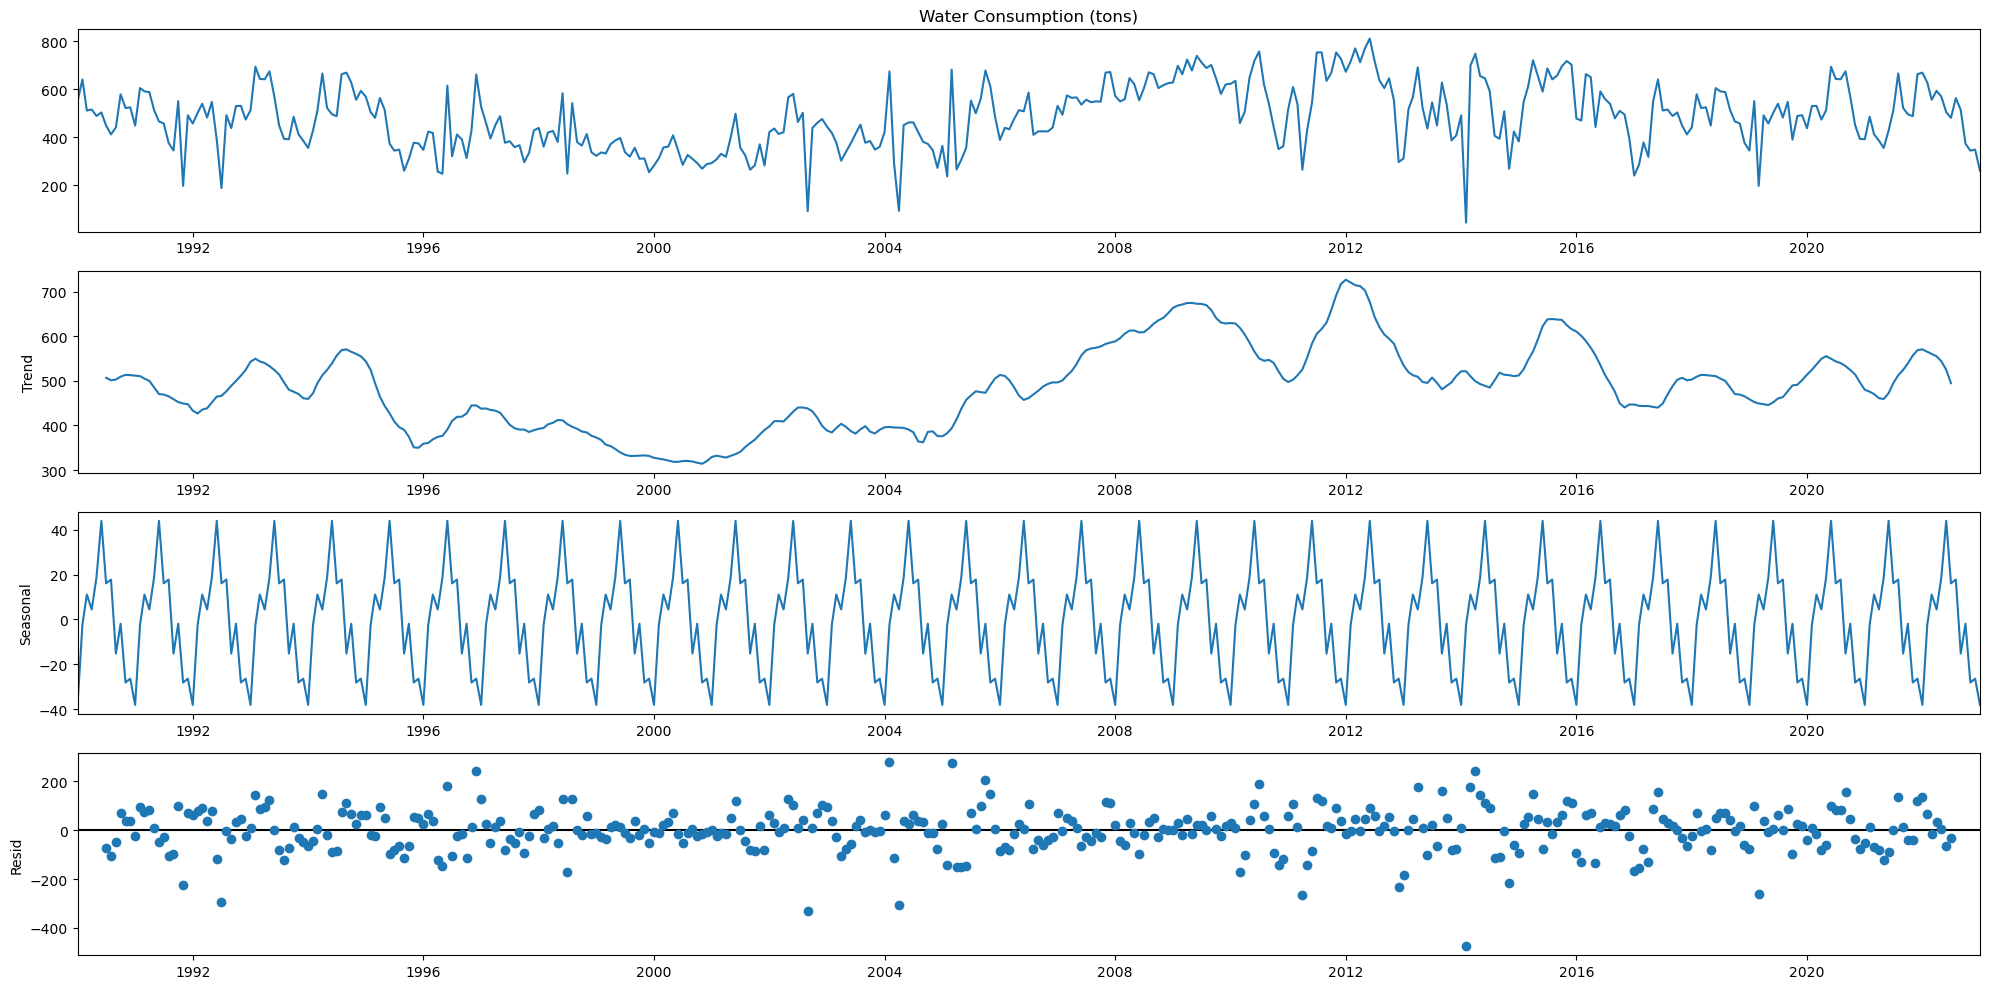

In [7]:
for i in data.columns:
    plt.rc("figure", figsize=(20, 10))
    result = seasonal_decompose(data[i])
    print("Seasonal", len(result.seasonal.drop_duplicates()))
    result.plot()
    plt.show()

From the seasonal decompositions, we can see that:

1. Trend
    - There is no linear trend for Gas Consumption
    - There is a linear trend for Electricity Consumption
    - There may be a linear trend for Water Consumption

2. Seasonality
    - The number of unique seasonal count is 12, which will be important for model implementation later on

### Test for Causation

The Granger Causality test is a statistical hypothesis test for:
1. Determining whether one time series is a factor
2. Whether it offers useful information in forecasting another time series

Null Hypothesis: There is no causality between time series<br>
Alternate Hypothesis: There is some causality between time series

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test = "ssr_chi2test"

g_matrix = pd.DataFrame(
    np.zeros((len(data.columns), len(data.columns))),
    columns=data.columns,
    index=data.columns,
)
for c in g_matrix.columns:
    for r in g_matrix.index:
        test_result = grangercausalitytests(
            data[[r, c]], maxlag=maxlag, verbose=False
        )
        p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        g_matrix.loc[r, c] = min_p_value
g_matrix.columns = [var + "_x" for var in data.columns]
g_matrix.index = [var + "_y" for var in data.columns]

g_matrix

Gas Consumption (tons)_x  \
Gas Consumption (tons)_y                           1.0000   
Electricity Consumption (MWh)_y                    0.1018   
Water Consumption (tons)_y                         0.0335   

                                 Electricity Consumption (MWh)_x  \
Gas Consumption (tons)_y                                  0.3018   
Electricity Consumption (MWh)_y                           1.0000   
Water Consumption (tons)_y                                0.0131   

                                 Water Consumption (tons)_x  
Gas Consumption (tons)_y                             0.2368  
Electricity Consumption (MWh)_y                      0.1045  
Water Consumption (tons)_y                           1.0000

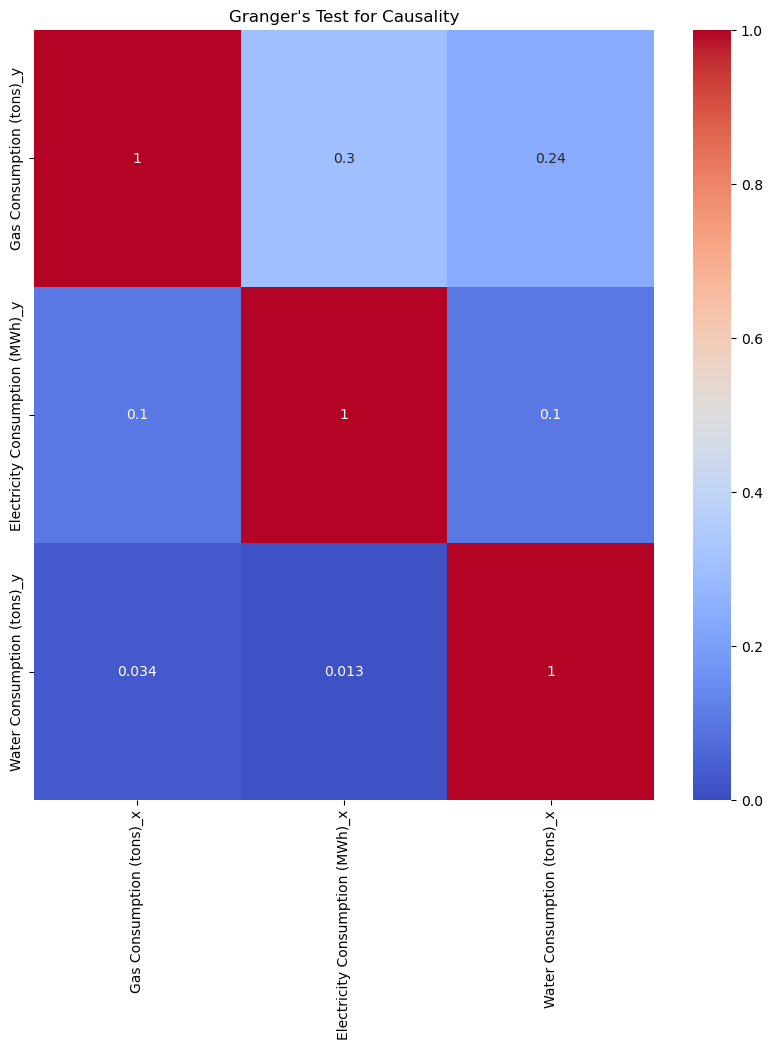

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(g_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Granger's Test for Causality")
plt.show()

If the value is lower than the significance level of 0.05, we can reject the null hypothesis concluding that x granger causes y

Conclusion:
- Gas Consumption granger causes Water Consumption
- Electricity Consumption granger causes Water Consumption

### Autocorrelation Function and Partial Autocorrelation Function

#### Autocorrelation Function (ACF):
- ACF is a correlation coefficient
- Correlation with lagged versions (lag-1, lag-2, etc.)

#### Partial Autocorrelation Function (PACF)
- Amount of correlation between them which is not explained by their mutual relationship
- Measures degree of association between two random variables

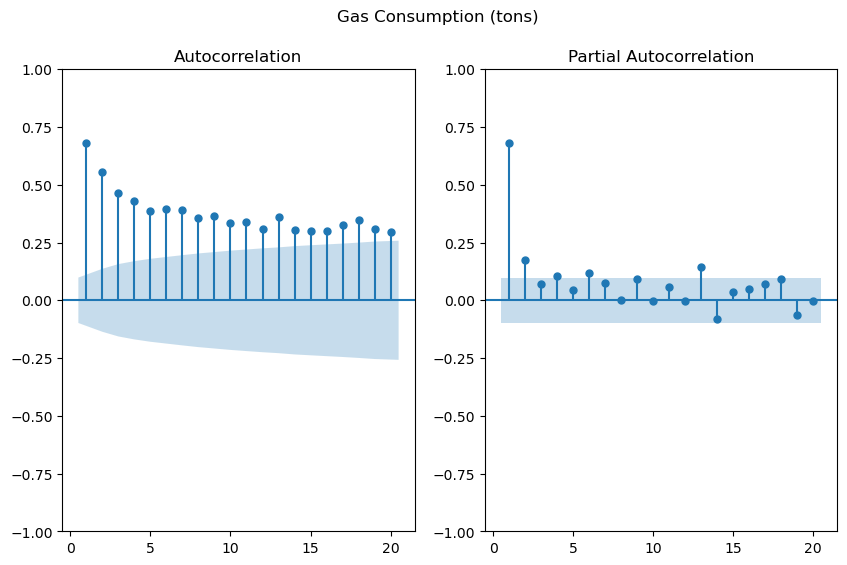

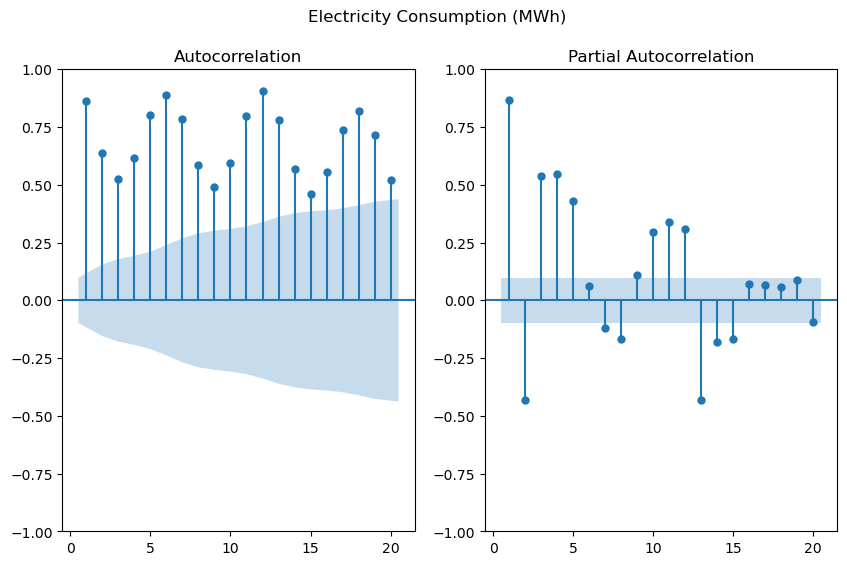

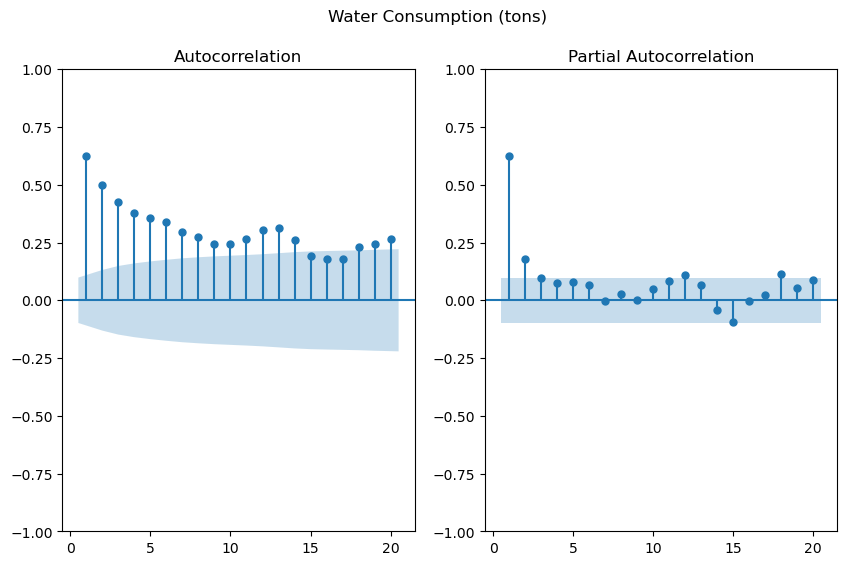

In [9]:
for i in data.columns:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
    plot_acf(data[i], lags=20, zero=False, ax=ax1)
    plot_pacf(data[i], lags=20, zero=False, ax=ax2)
    plt.suptitle(f'{i}')
    plt.show()

From the ACF plots, it seems that all three time series are not differenced yet as the ACF plots are all quite significant.

Hence, we will apply first order differencing, **especially to Electricity Consumption as it was non-stationary.**

In [10]:
data_diff = data.diff().dropna()

In [11]:
data_diff

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                                
1990-02-01                    -2.2                          -18.4   
1990-03-01                     1.5                          -82.2   
1990-04-01                     1.6                          -49.8   
1990-05-01                     3.1                          -21.5   
1990-06-01                     1.4                           27.7   
...                            ...                            ...   
2022-09-01                     0.5                         -103.1   
2022-10-01                     4.1                          -50.1   
2022-11-01                    -0.8                           37.3   
2022-12-01                     1.4                          173.8   
2023-01-01                    -1.1                          146.8   

            Water Consumption (tons)  
DATE                                  
1990-02-01                      91.9  
1990-03-01                    -129.6  
1990-04-01                       4.2  
1990-05-01                     -26.9  
1990-06-01                      14.8  
...                              ...  
2022-09-01                     -49.9  
2022-10-01                    -140.2  
2022-11-01                     -29.2  
2022-12-01                       4.4  
2023-01-01                     -88.1  

[396 rows x 3 columns]

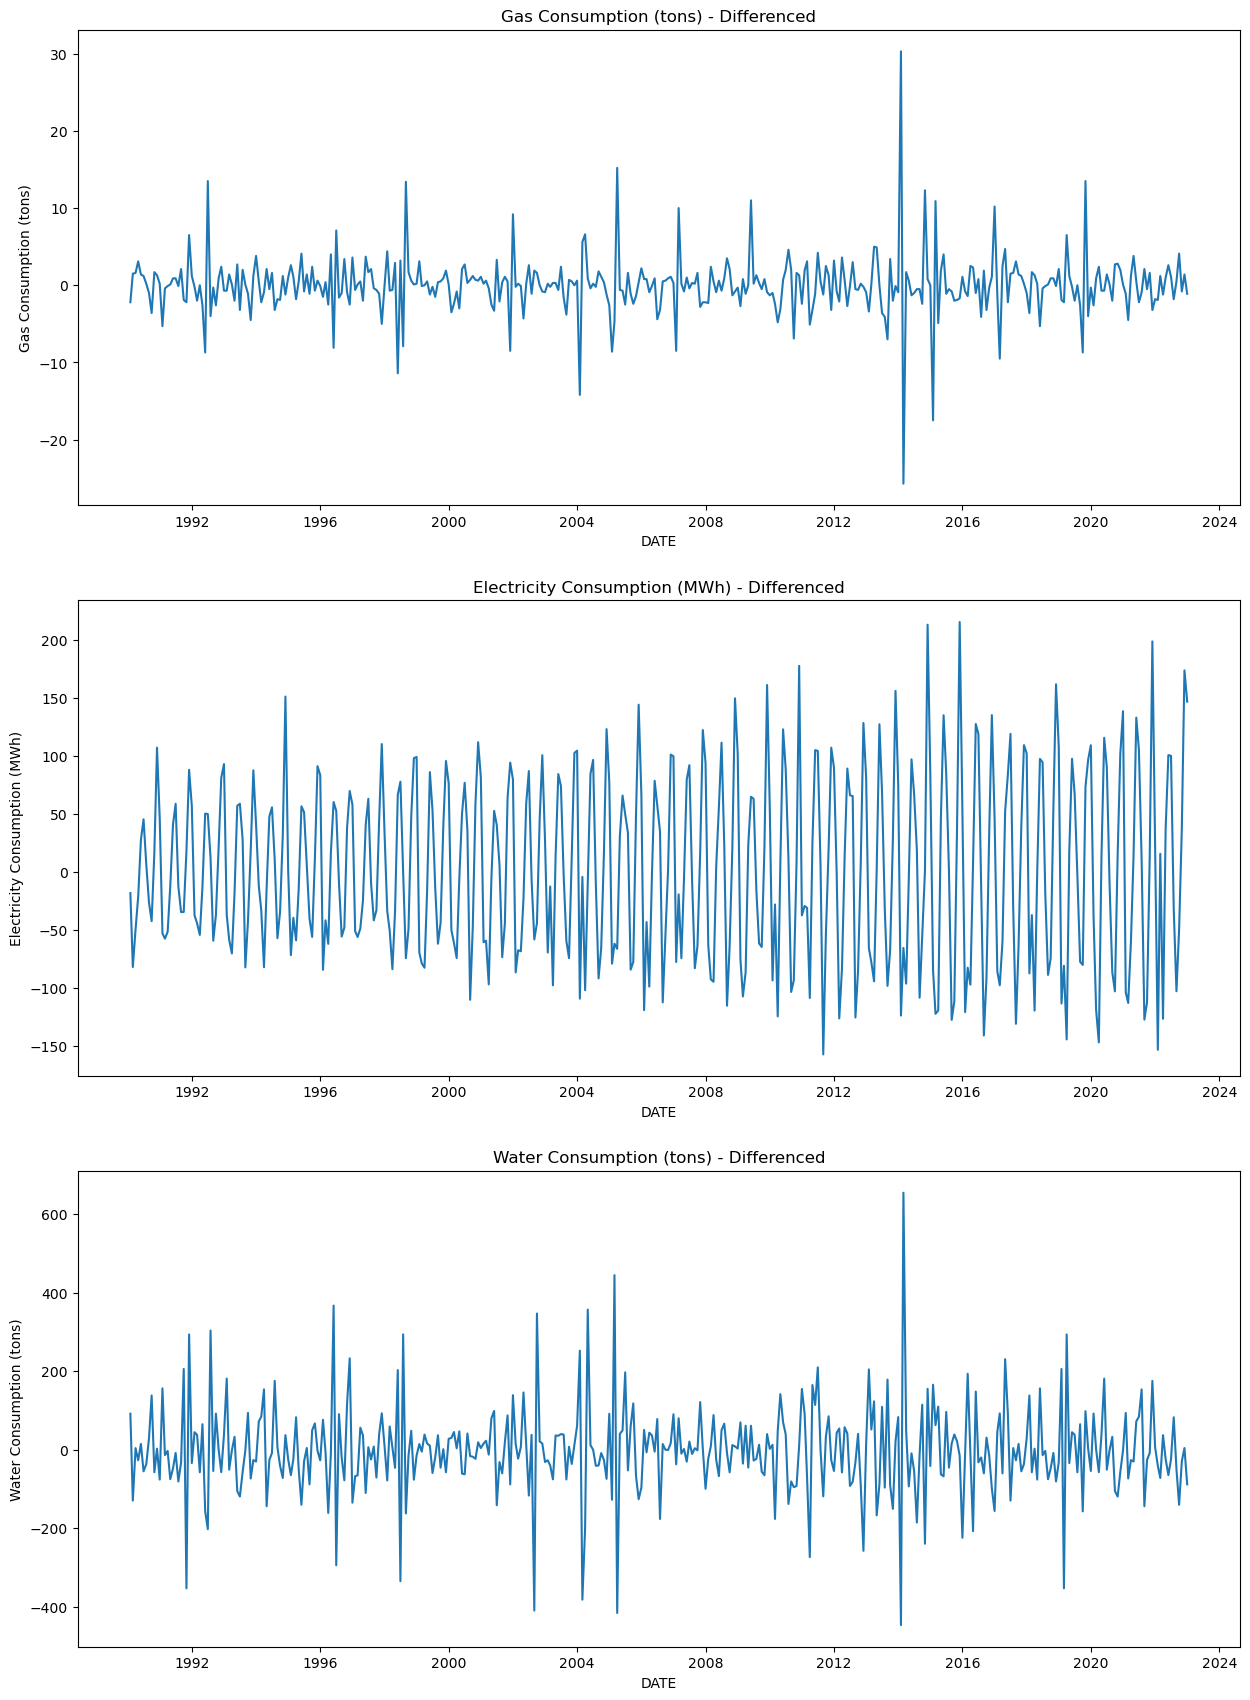

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,21))

sns.lineplot(data=data_diff, x=data_diff.index, y='Gas Consumption (tons)', ax=ax1)
ax1.set_title('Gas Consumption (tons) - Differenced')

sns.lineplot(data=data_diff, x=data_diff.index, y='Electricity Consumption (MWh)', ax=ax2)
ax2.set_title('Electricity Consumption (MWh) - Differenced')

sns.lineplot(data=data_diff, x=data_diff.index, y='Water Consumption (tons)', ax=ax3)
ax3.set_title('Water Consumption (tons) - Differenced')

plt.show()

After differencing, we will apply the statistical tests again to make sure the time series are stationary

In [13]:
stat_test(data_diff, 'Gas Consumption (tons)')
stat_test(data_diff, 'Electricity Consumption (MWh)')
stat_test(data_diff, 'Water Consumption (tons)')

Gas Consumption (tons)
----------------------------------------
p-value with Augmented Dickey–Fuller test: 6.396189162972684e-12
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.1

Series is stationary from ADF test
Series is trend stationary from KPSS test

Electricity Consumption (MWh)
----------------------------------------
p-value with Augmented Dickey–Fuller test: 4.079770743785425e-10
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.1

Series is stationary from ADF test
Series is trend stationary from KPSS test

Water Consumption (tons)
----------------------------------------
p-value with Augmented Dickey–Fuller test: 4.3354157508677735e-15
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.1

Series is stationary from ADF test
Series is trend stationary from KPSS test



We can see now that all time series are differenced, and both statistical tests give the same conclusion

#### ACF and PACF plots on differenced time series

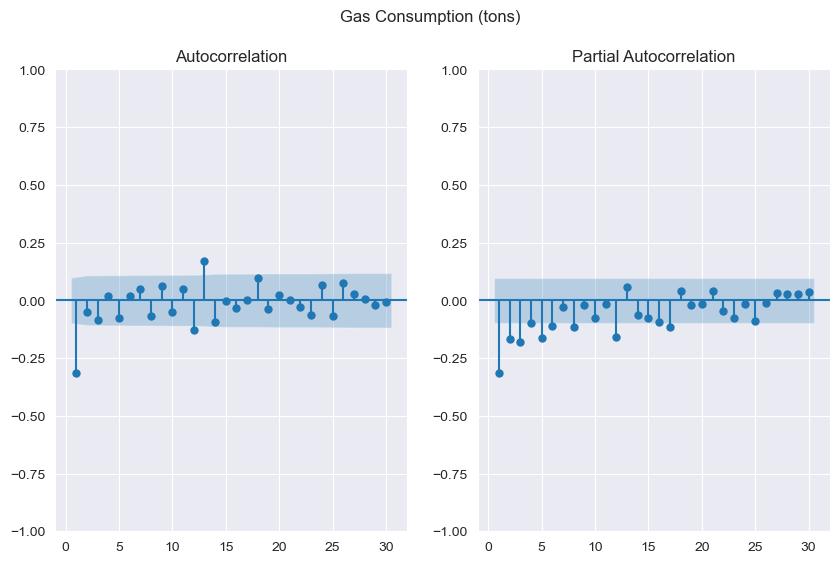

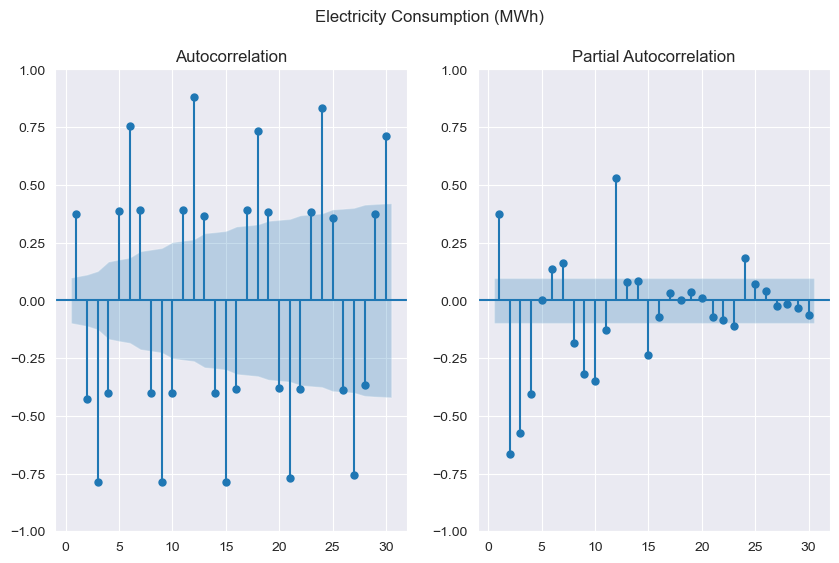

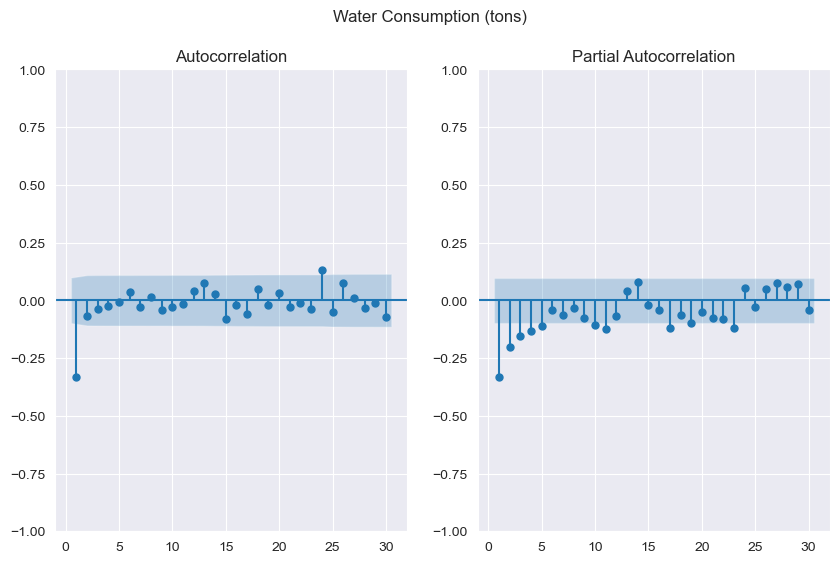

In [92]:
for i in data_diff.columns:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
    plot_acf(data_diff[i], lags=30, zero=False, ax=ax1)
    plot_pacf(data_diff[i], lags=30, zero=False, ax=ax2)
    plt.suptitle(f'{i}')
    plt.show()

We can intepret the plots to determine the p and q values for our time series models later on

#### 1. Gas Consumption
- p: From the PACF plot, we can see that it cuts off at around lag 3
- q: From the ACF plot, we can see that it cuts off at around lag 1

As first order differencing is applied, the d value will be 1, which gives us an order of **(3,1,1)**

#### 2. Electricity Consumption
- Due to the clear seasonality from the ACF plot, we will not be using ARIMA for Electricity Consumption but instead moving straight to SARIMA
    
We will determine the values of the order and seasonal order later on when implementing SARIMA models

#### 3. Water Consumption
- p: From the PACF plot, we can see that it tails off
- q: From the ACF plot, we can see that it cuts off at around lag 1

As first order differencing is applied, the d value will be 1, which gives us an order of **(0,1,1)**

## Modelling and Evaluation

We will first be running ARIMA on Gas and Water Consumption

#### Autoregressive Integrated Moving Average (ARIMA)
1. AR Component (Autoregressive process)
    - p: the order of the AR process
2. MA Component (Moving Average process)
    - q: the order of MA process
3. I is the order of differencing

We have identified a set of values of (p,d,q) for gas and water, which we will be implementing now

We will split the data into train and test sets, where we train the model on the train set and predict the test set to compare the model's performance

In [4]:
train_size = int(len(data) * 0.8)

data_train, data_test = data[:train_size], data[train_size:]
print(f"data_train.shape = {data_train.shape}, data_test.shape = {data_test.shape}")

data_train.shape = (317, 3), data_test.shape = (80, 3)


#### ARIMA for Gas Consumption

                                 SARIMAX Results                                  
Dep. Variable:     Gas Consumption (tons)   No. Observations:                  317
Model:                     ARIMA(3, 1, 1)   Log Likelihood                -850.606
Date:                    Fri, 11 Aug 2023   AIC                           1711.212
Time:                            04:32:33   BIC                           1729.991
Sample:                        01-01-1990   HQIC                          1718.714
                             - 05-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3996      0.052      7.751      0.000       0.299       0.501
ar.L2          0.0910      0.063      1.449      0.147      -0.032       0.214
ar.L3         -0.056

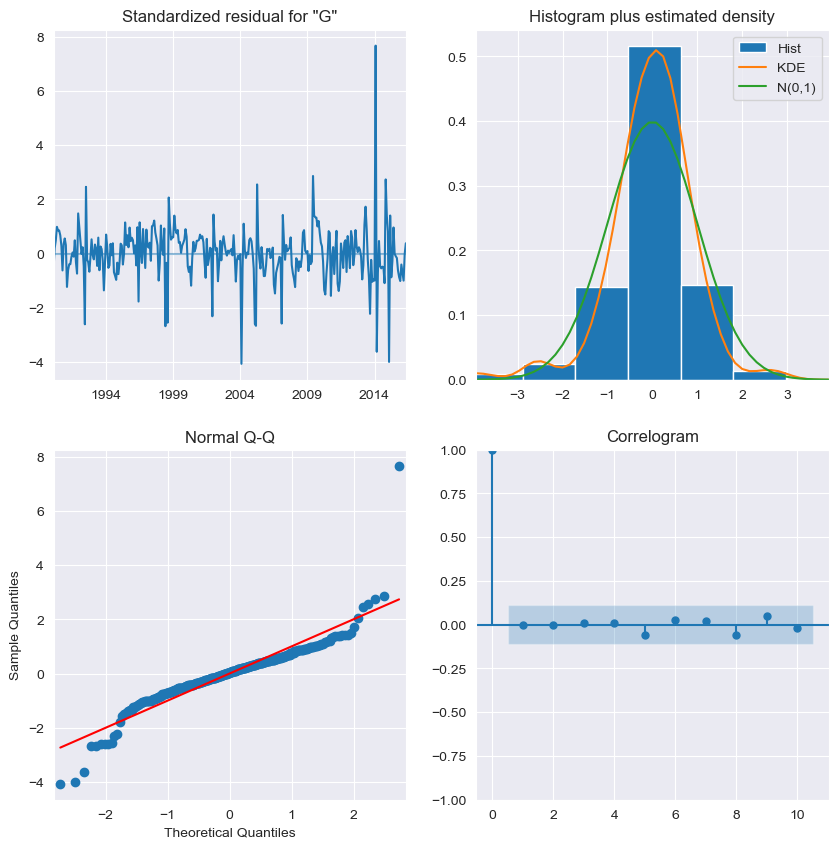

In [5]:
sns.set_style('darkgrid')

arima_model_gas = ARIMA(data_train['Gas Consumption (tons)'], order=(3,1,1))
results_gas = arima_model_gas.fit()
print(results_gas.summary())
results_gas.plot_diagnostics(figsize=(10,10))
plt.show()

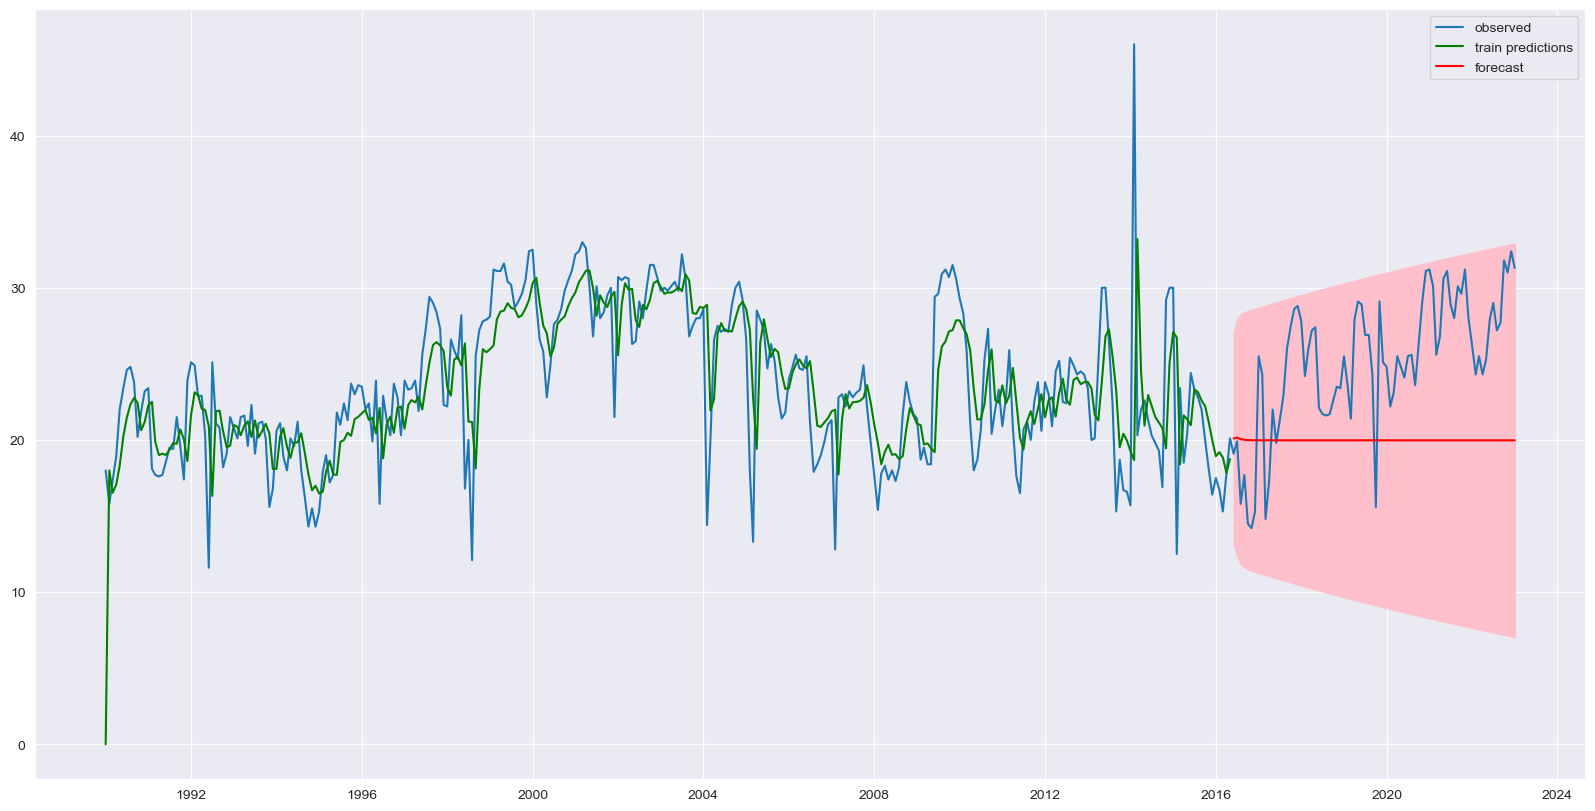

RMSE: 6.7743412255729964
MAPE: 23.22796369429968 %


In [19]:
# Generate predictions for both training and test data
train_predictions = results_gas.predict(start=0, end=len(data_train)-1, dynamic=False)
gas_pred = results_gas.get_forecast(steps=len(data_test['Gas Consumption (tons)']))
test_predictions = gas_pred.predicted_mean

confidence_intervals = gas_pred.conf_int()
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

# Plot the observed data
plt.plot(data.index, data['Gas Consumption (tons)'], label='observed')

# Plot predictions for the training data
plt.plot(data_train.index, train_predictions, color='green', label='train predictions')

# Plot the forecasted mean values for the test data
plt.plot(test_predictions.index, test_predictions, color='r', label='forecast')

# Shade the area between the confidence limits for the forecast
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data_test['Gas Consumption (tons)'], test_predictions))

# Calculate MAPE using the mean_absolute_percentage_error function
mape = mean_absolute_percentage_error(data_test['Gas Consumption (tons)'], test_predictions)

# Print RMSE and MAPE
print(f"RMSE: {rmse}")
print(f"MAPE: {mape*100} %")

To try to improve the model, we will use Walk Forward Validation instead of Train-Test-Split

### What is Walk-Forward Validation?
In time series modelling, the predictions over time become less and less accurate, and so with walk-forward validation, we re-train the model with data when it is available.

We will split the data into a train set, a validation set where walk forward validation is implemented, and a test set

In [106]:
def wf_validation(x, name, order, plot): 
    size = int(len(x) * 0.95)
    train, test = x[0:size], x[size:len(x)]
    
    train_size = int(len(train.values) * 0.70)
    train, validation = train[0:train_size], train[train_size:len(train.values)]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    prediction = []
    data1 = train.values
    for t in validation.values:
        model = ARIMA(data1, order=order).fit()
        y = model.forecast(steps=1)[0]
        prediction.append(y)
        data1 = np.append(data1, t)
    
    test_pred = model.forecast(steps=len(test))

    validation_ = pd.DataFrame(validation, columns=[name])
    validation_['predictions_wf'] = prediction
    
    test_ = pd.DataFrame(test, columns=[name])
    test_['predictions_test'] = test_pred
    
    val_rmse = sqrt(mean_squared_error(validation, prediction))
    val_mape = mean_absolute_percentage_error(validation, prediction)
    
    test_rmse = sqrt(mean_squared_error(test, test_pred))
    test_mape = mean_absolute_percentage_error(test, test_pred)
    
    aic = model.aic
    bic = model.bic
    
    if plot == True:
        plt.subplots(figsize=(15,5))
        plt.plot(train, label='Training Data')
        plt.plot(validation_[name], label='Validation Data')
        plt.plot(validation_['predictions_wf'], '--', label='Validation')
        plt.plot(test_[name], label='Test Data')
        plt.plot(test_['predictions_test'], '--', label='Predictions')
        plt.title(f'{name} Prediction using ARIMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name}')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.subplots(figsize=(15,5))
        plt.plot(test_[name], label='Test Data')
        plt.plot(test_['predictions_test'], '--', label='Predictions')
        plt.title(f'{name} Prediction using ARIMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(model.summary())
        model.plot_diagnostics(figsize=(15,15))
        plt.show()

        print(f'Validation Set RMSE for ARIMA with Walk-Forward Validation: {val_rmse}')
        print(f'Validation Set MAPE for ARIMA with Walk-Forward Validation: {val_mape*100} %\n')
    
        print(f'Test Set RMSE for ARIMA with Walk-Forward Validation: {test_rmse}')
        print(f'Test Set MAPE for ARIMA with Walk-Forward Validation: {test_mape*100} %\n')
    
        print(f'AIC: {aic}\nBIC: {bic}')
    
    return val_rmse, val_mape, test_rmse, test_mape, aic, bic

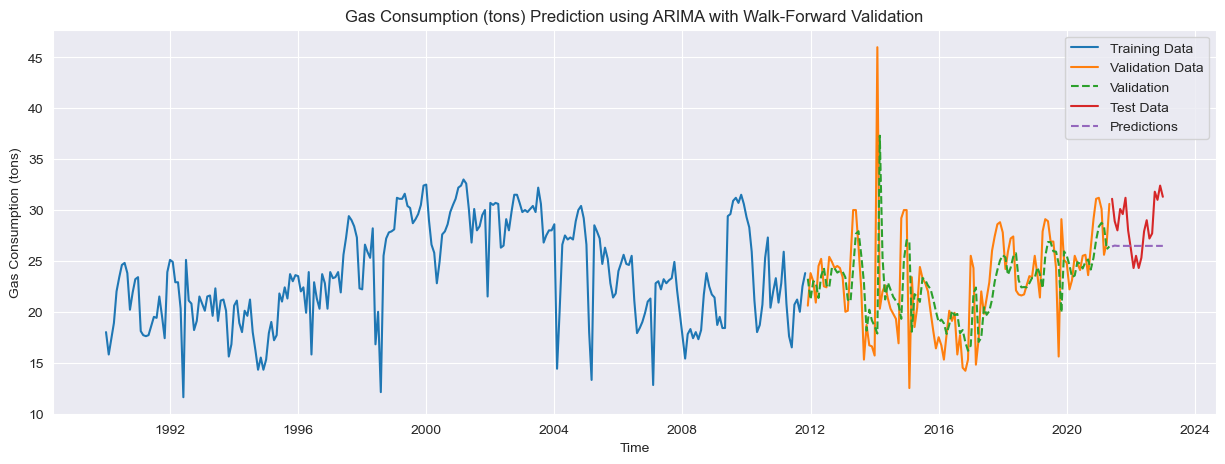

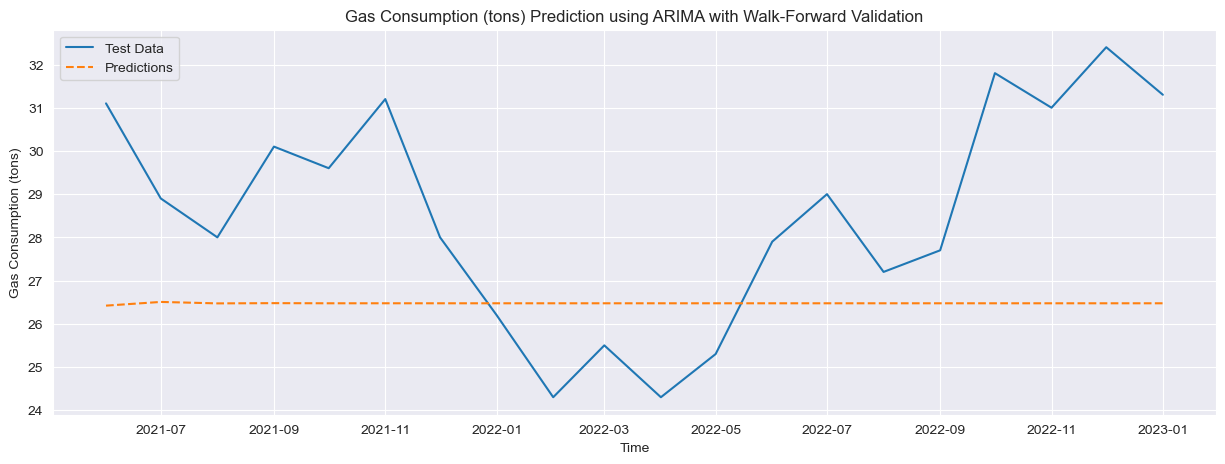

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  376
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1004.219
Date:                Tue, 08 Aug 2023   AIC                           2018.437
Time:                        21:01:39   BIC                           2038.072
Sample:                             0   HQIC                          2026.232
                                - 376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4121      0.047      8.697      0.000       0.319       0.505
ar.L2          0.0730      0.057      1.271      0.204      -0.040       0.186
ar.L3         -0.0344      0.073     -0.474      0.6

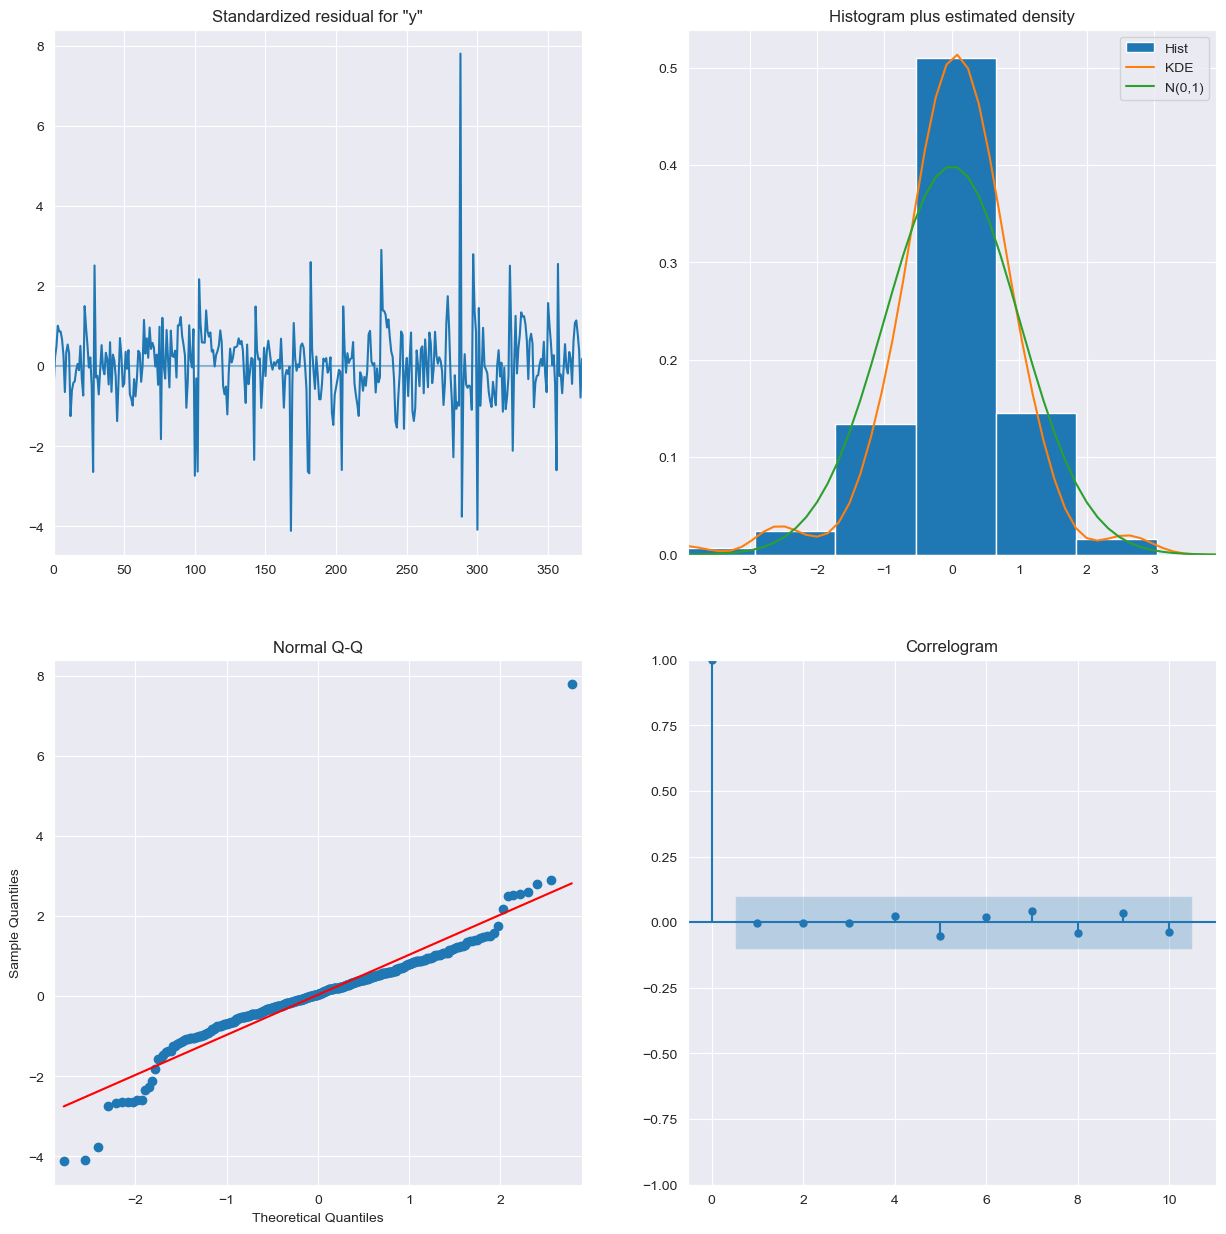

Validation Set RMSE for ARIMA with Walk-Forward Validation: 4.607549497962777
Validation Set MAPE for ARIMA with Walk-Forward Validation: 13.018058015851908 %

Test Set RMSE for ARIMA with Walk-Forward Validation: 3.217895769028278
Test Set MAPE for ARIMA with Walk-Forward Validation: 9.268040470232572 %

AIC: 2018.4372113853105
BIC: 2038.0718415151625


(4.607549497962777,
 0.13018058015851908,
 3.217895769028278,
 0.09268040470232572,
 2018.4372113853105,
 2038.0718415151625)

In [110]:
wf_validation(data['Gas Consumption (tons)'], 'Gas Consumption (tons)', (3,1,1), True)

As we can see, there is a bit of improvement in terms of RMSE and MAPE

It is important to note as we have used more data on the fitting of the model, the AIC and BIC values will be higher

#### Model Evaluation

With the help of model.summary and model.plot_diagnostics, can understand how our model performs better
1. P > |z| column: Term significance, if value < 0.05, it is statistically significant
2. Ljung-Box Test: If value < 0.05, the errors are not white noise
3. Heteroskedaticity Test: If value < 0.05, the residuals show variances
4. Jarque-Bera Test: If value < 0.05, data is not normally distributed agaisnt an alternative of another dimension

We can also use the model.plot_diagnostics to help visualize the test conclusions

#### Gas Consumption ARIMA
- AR lag-2 and lag-3 coefficients are not statistically significant
- The errors are not caused by white noise
- The residuals show no variances
- The data is normally distributed

Based on our summary of the model, we can see that there are some parameters that need to be tuned as we want statistically significant coefficients and errors caused by white noise. We can aim to solve this through hyperparameter tuning

### Tuning

From a visualisation perspective, we have found out the starting order of our model.

However, we can try to tune the model with a loop, looping through possible values of p and q to find the best combination based off evaluation metrics

1. Akaike Information Criterion (AIC)
- estimate the likelihood of model to predict/estimate future values
- -2 * ln L + 2 * k

2. Bayesian Information Criterion (BIC)
- measures the trade-off between a model fit and the complexity of the model
- -2 * ln L + 2 * ln N * k

L is the value of the likelihood, N is the number of recorded measurements, k is the number of estimated parameters

Since we want to forecast into the future, we will be using AIC as the evaluation metric.

However, it is important to note that overfitting may occur

In [114]:
orders=[]

for p in range(4):
    for q in range(4):
        try:
            val_rmse, val_mape, test_rmse, test_mape, aic, bic = wf_validation(data['Gas Consumption (tons)'], 'Gas Consumption (tons)', (p,1,q), False)

            orders.append((p, q, val_rmse, val_mape, test_rmse, test_mape, aic, bic))
            
        except:
            orders.append((p, q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'val_rmse', 'val_mape', 'test_rmse', 'test_mape', 'aic', 'bic'])

order_df.sort_values('aic').head(5)

p  q  val_rmse  val_mape  test_rmse  test_mape          aic          bic
15  3  3  5.149614  0.141218   3.206079   0.091747  2015.711727  2043.200210
5   1  1  4.577219  0.127540   3.128107   0.090480  2016.136241  2027.917019
9   2  1  4.615264  0.127760   3.265136   0.093706  2016.815173  2032.522877
6   1  2  4.592008  0.127954   3.254832   0.093450  2017.010887  2032.718591
10  2  2  4.604208  0.130922   3.232483   0.092991  2018.136631  2037.771262

(p=3,q=3)

Here, we see that the model that produces the lowest AIC is with (3,1,3).

However, looking at the other orders, the model with (1,1,1) order has lower RMSE and MAPE on both validation and test sets, and even though the AIC score is a little higher, the BIC score is the lowest among the options.

Thus, we will be using the (1,1,1) order

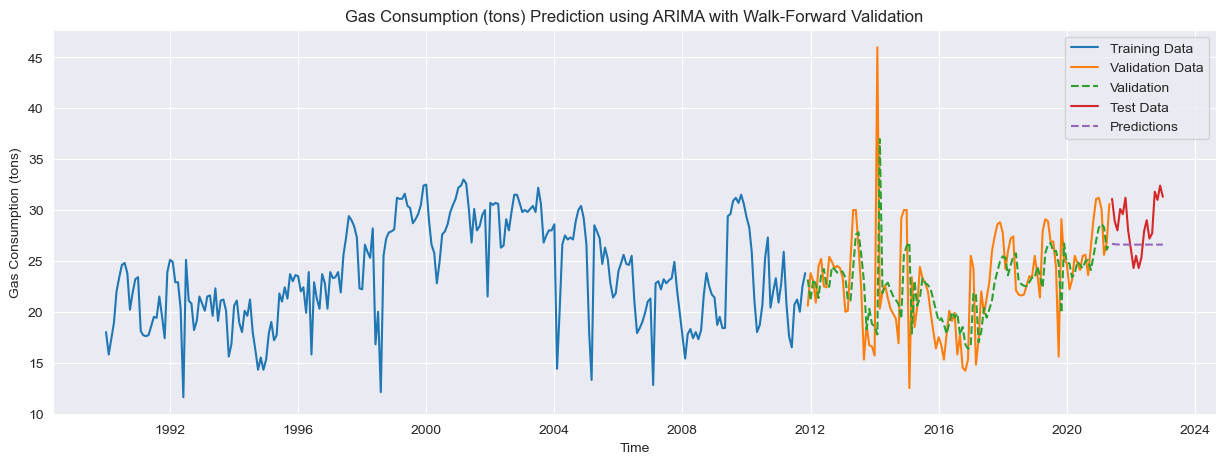

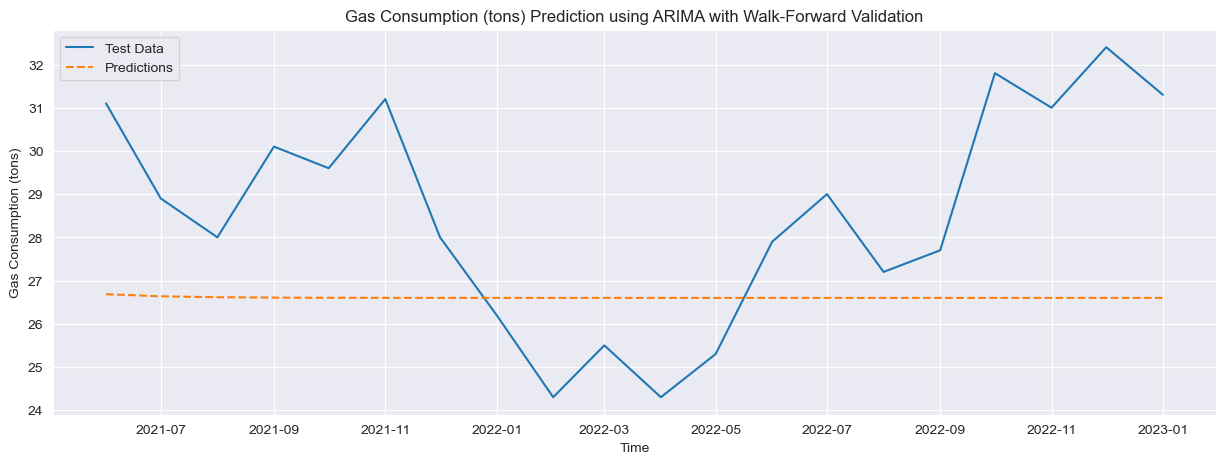

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  376
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1005.068
Date:                Tue, 08 Aug 2023   AIC                           2016.136
Time:                        21:20:52   BIC                           2027.917
Sample:                             0   HQIC                          2020.813
                                - 376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4268      0.039     11.008      0.000       0.351       0.503
ma.L1         -0.9005      0.033    -27.216      0.000      -0.965      -0.836
sigma2        12.4300      0.461     26.988      0.0

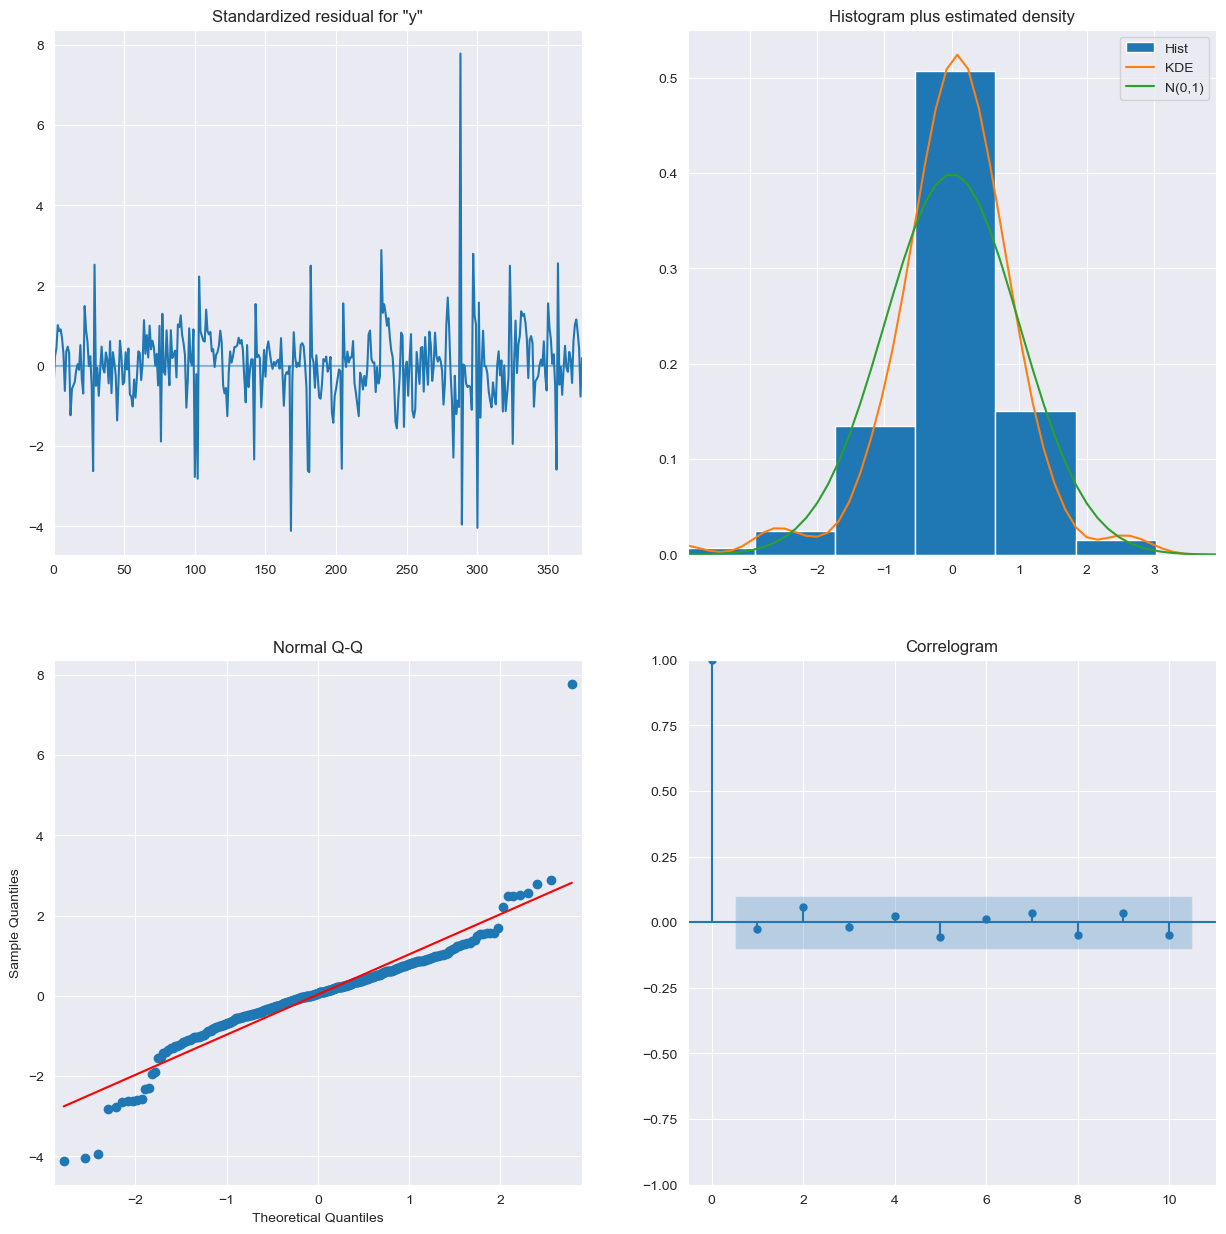

Validation Set RMSE for ARIMA with Walk-Forward Validation: 4.577218921522249
Validation Set MAPE for ARIMA with Walk-Forward Validation: 12.754037032383502 %

Test Set RMSE for ARIMA with Walk-Forward Validation: 3.128106985140336
Test Set MAPE for ARIMA with Walk-Forward Validation: 9.04804094547319 %

AIC: 2016.1362411418147
BIC: 2027.917019219726


(4.577218921522249,
 0.12754037032383503,
 3.128106985140336,
 0.0904804094547319,
 2016.1362411418147,
 2027.917019219726)

In [115]:
wf_validation(data['Gas Consumption (tons)'], 'Gas Consumption (tons)', (1,1,1), True)

Scores before tuning orders:<br>
(4.607549497962777,
 0.13018058015851908,
 3.217895769028278,
 0.09268040470232572,
 2018.4372113853105,
 2038.0718415151625)

Here, we see that all scores have decreased by a little bit.

This shows that despite this order performing a little bit better than the previous order, it is quite minimal and that the order we perceived from the ACF and PACF performs similarly

#### Gas Consumption ARIMA (Tuned)
- All coefficients are statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

We can see that the model performs better

#### ARIMA for Water Consumption

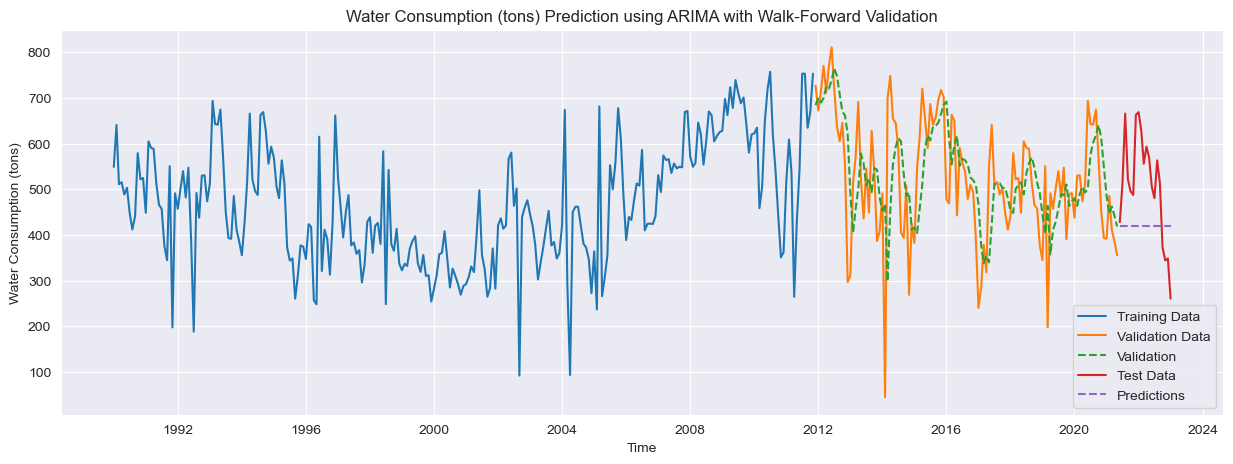

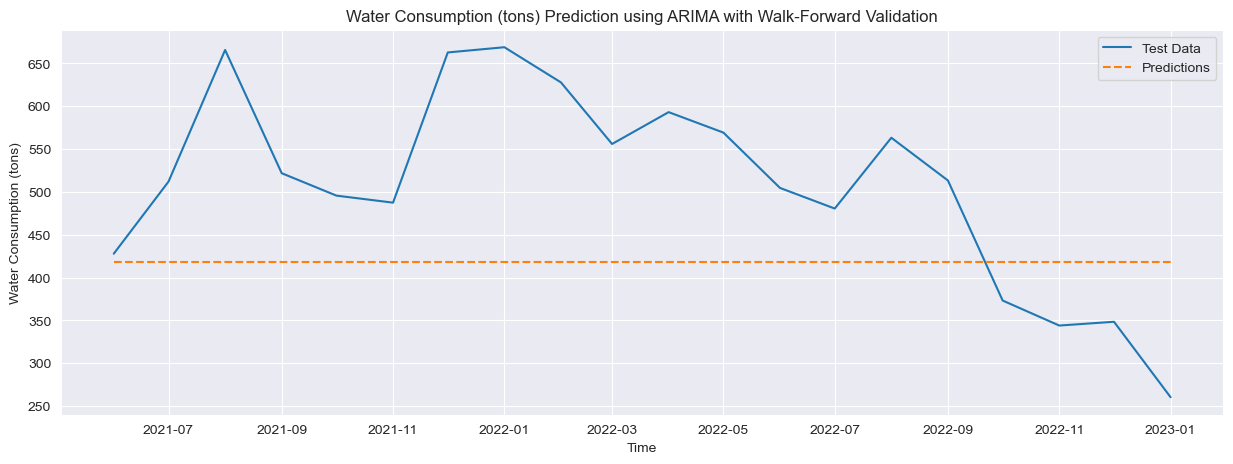

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  376
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2279.095
Date:                Tue, 08 Aug 2023   AIC                           4562.190
Time:                        21:29:53   BIC                           4570.043
Sample:                             0   HQIC                          4565.308
                                - 376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5904      0.035    -16.834      0.000      -0.659      -0.522
sigma2      1.112e+04    572.066     19.431      0.000    9994.417    1.22e+04
Ljung-Box (L1) (Q):                   3.78   Jarque-

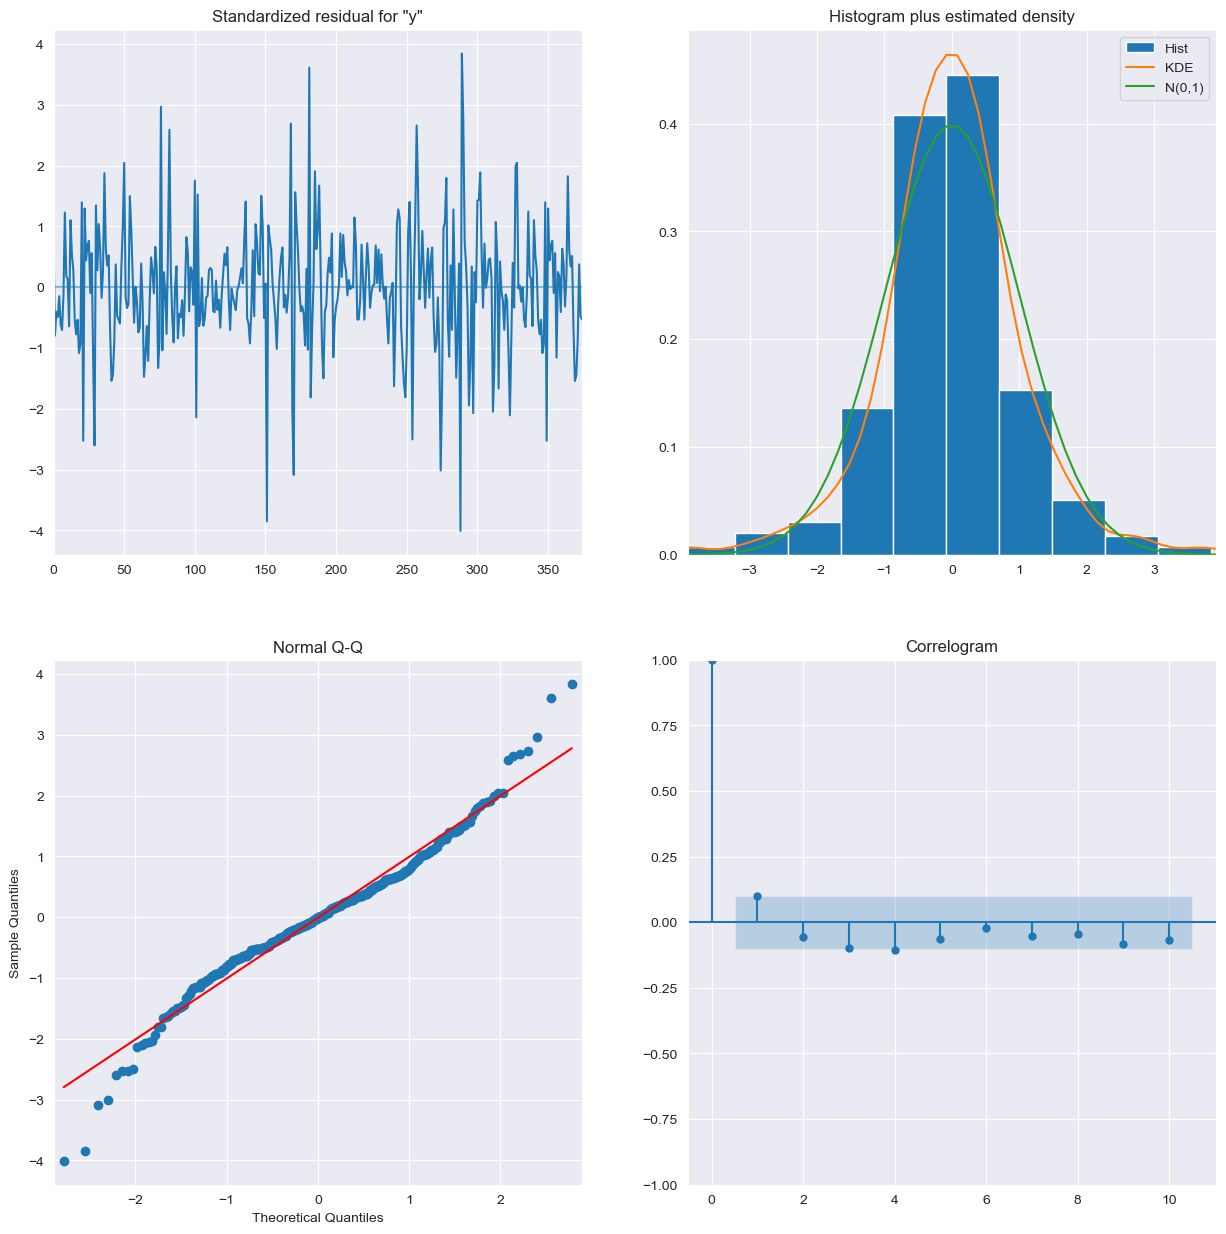

Validation Set RMSE for ARIMA with Walk-Forward Validation: 119.55929831596575
Validation Set MAPE for ARIMA with Walk-Forward Validation: 26.844563468357517 %

Test Set RMSE for ARIMA with Walk-Forward Validation: 142.89642997401765
Test Set MAPE for ARIMA with Walk-Forward Validation: 24.21587199227692 %

AIC: 4562.189613750574
BIC: 4570.043465802514


(119.55929831596575,
 0.2684456346835752,
 142.89642997401765,
 0.24215871992276922,
 4562.189613750574,
 4570.043465802514)

In [116]:
wf_validation(data['Water Consumption (tons)'], 'Water Consumption (tons)', (0,1,1), True)

#### Water Consumption ARIMA
- All coefficients are statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

#### Tuning Water Consumption ARIMA

In [117]:
orders=[]

for p in range(4):
    for q in range(4):
        try:
            val_rmse, val_mape, test_rmse, test_mape, aic, bic = wf_validation(data['Water Consumption (tons)'], 'Water Consumption (tons)', (p,1,q), False)

            orders.append((p, q, val_rmse, val_mape, test_rmse, test_mape, aic, bic))
            
        except:
            orders.append((p, q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'val_rmse', 'val_mape', 'test_rmse', 'test_mape', 'aic', 'bic'])

order_df.sort_values('aic').head(5)

p  q    val_rmse  val_mape   test_rmse  test_mape          aic  \
6   1  2  114.776901  0.271253  115.169992   0.200749  4539.783780   
9   2  1  114.889490  0.271324  114.647917   0.199629  4539.989444   
5   1  1  115.541621  0.273769  113.581659   0.197491  4540.637097   
10  2  2  115.225329  0.272466  115.353448   0.201127  4541.769059   
7   1  3  114.947967  0.271673  115.333076   0.201087  4541.770053   

            bic  
6   4555.491484  
9   4555.697148  
5   4552.417875  
10  4561.403689  
7   4561.404683

(p=1, q=2)

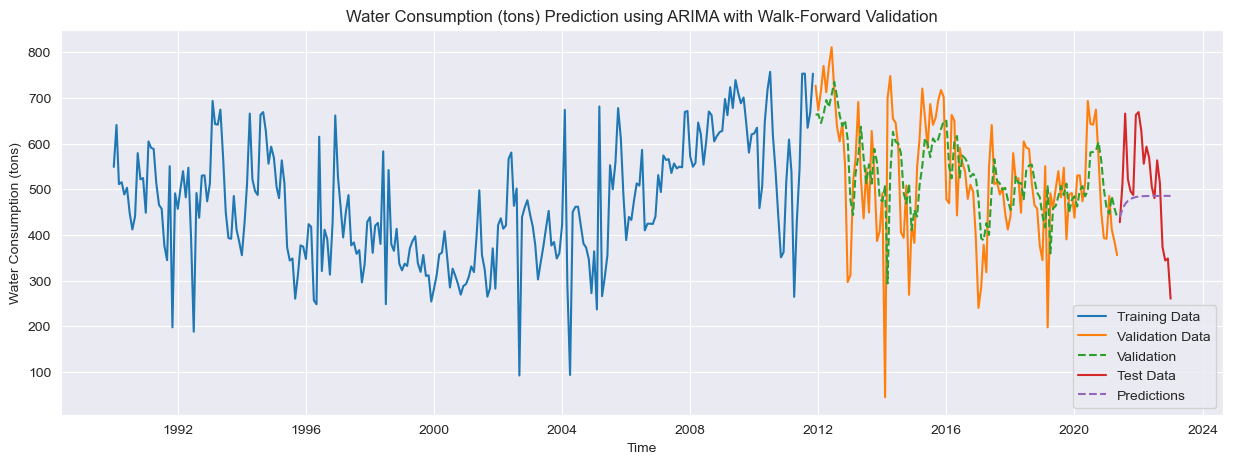

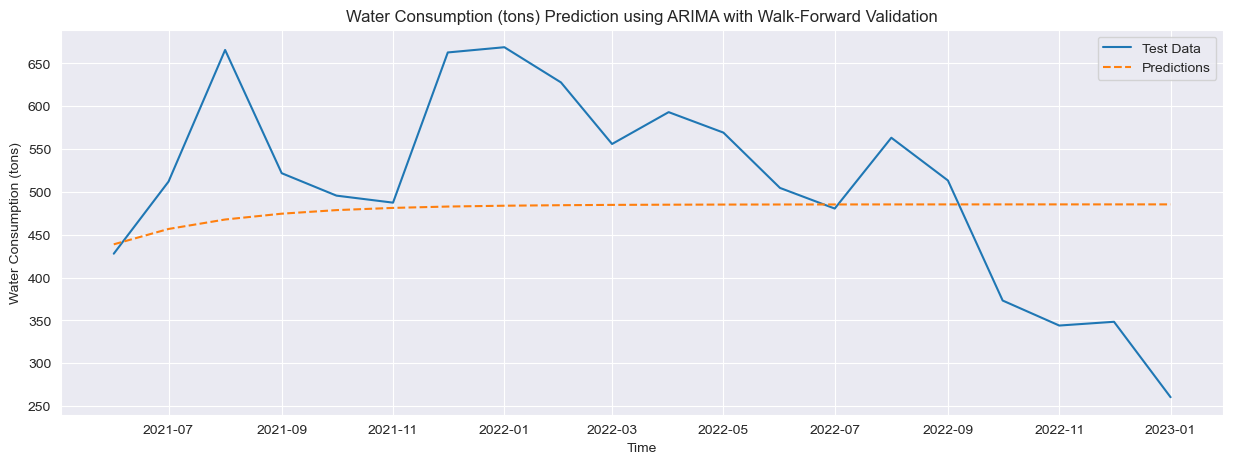

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  376
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2265.892
Date:                Wed, 09 Aug 2023   AIC                           4539.784
Time:                        13:18:24   BIC                           4555.491
Sample:                             0   HQIC                          4546.020
                                - 376                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6154      0.121      5.105      0.000       0.379       0.852
ma.L1         -1.1584      0.127     -9.136      0.000      -1.407      -0.910
ma.L2          0.2041      0.104      1.959      0.0

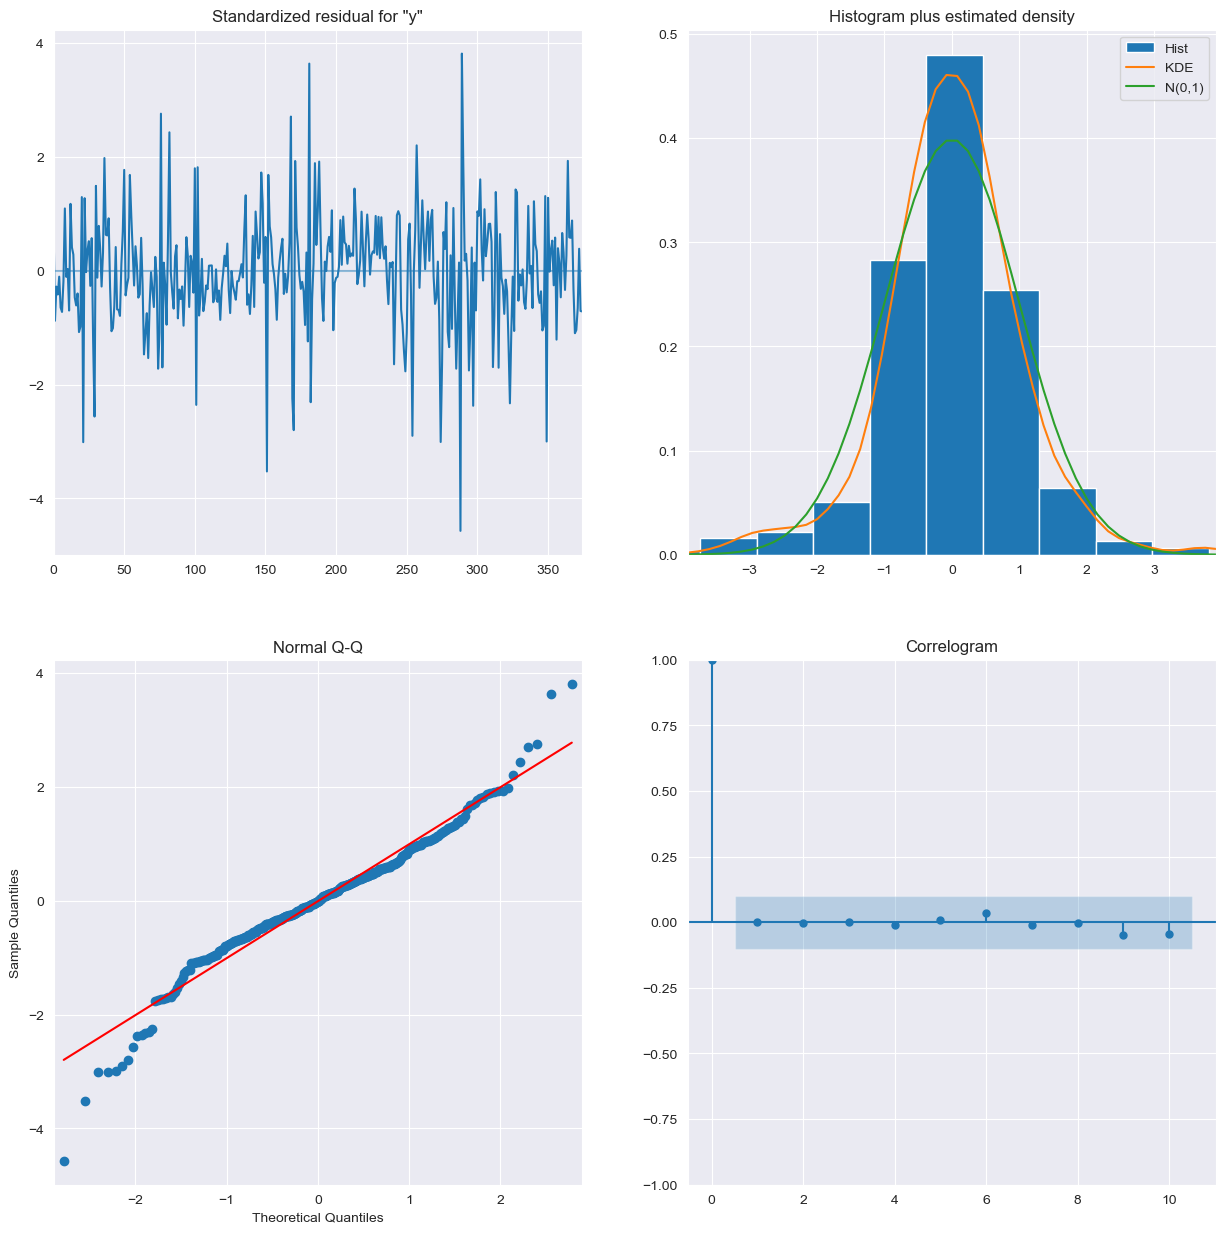

Validation Set RMSE for ARIMA with Walk-Forward Validation: 114.77690080180089
Validation Set MAPE for ARIMA with Walk-Forward Validation: 27.125321922803895 %

Test Set RMSE for ARIMA with Walk-Forward Validation: 115.16999165400814
Test Set MAPE for ARIMA with Walk-Forward Validation: 20.07491229835999 %

AIC: 4539.783779782952
BIC: 4555.4914838868335


(114.77690080180089,
 0.27125321922803897,
 115.16999165400814,
 0.2007491229835999,
 4539.783779782952,
 4555.4914838868335)

In [135]:
wf_validation(data['Water Consumption (tons)'], 'Water Consumption (tons)', (1,1,2), True)

Untuned: <br>
(119.55929831596575,
 0.2684456346835752,
 142.89642997401765,
 0.24215871992276922,
 4562.189613750574,
 4570.043465802514)

We see that after tuning, the metrics have improved

### Seasonal ARIMA (SARIMA)

This is another model that we will be implementing, especially onto our electricity consumption time series
It is very similar to ARIMA but has takes into account the seasonality patterns in the time series. 

This is where our seasonal decompositions earlier come in. They can help us identify the seasonality in the time series.
There will be another order, the seasonal order, with (P, D, Q, M)

In [7]:
def wf_validation_sarima(x, name, order, seasonal_order, plot): 
    size = int(len(x) * 0.95)
    train, test = x[0:size], x[size:len(x)]
    
    train_size = int(len(train.values) * 0.70)
    train, validation = train[0:train_size], train[train_size:len(train.values)]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    prediction = []
    data1 = train.values
    for t in validation.values:
        model = SARIMAX(data1, order=order, seasonal_order=seasonal_order, enforce_stationarity=False).fit()
        y = model.forecast(steps=1)[0]
        prediction.append(y)
        data1 = np.append(data1, t)
    
    test_pred = model.forecast(steps=len(test))

    validation_ = pd.DataFrame(validation, columns=[name])
    validation_['predictions_wf'] = prediction
    
    test_ = pd.DataFrame(test, columns=[name])
    test_['predictions_test'] = test_pred

    val_rmse = sqrt(mean_squared_error(validation, prediction))
    val_mape = mean_absolute_percentage_error(validation, prediction)
    
    test_rmse = sqrt(mean_squared_error(test, test_pred))
    test_mape = mean_absolute_percentage_error(test, test_pred)
    
    aic = model.aic
    bic = model.bic
    
    if plot == True:
        plt.subplots(figsize=(15,5))
        plt.plot(train, label='Training Data')
        plt.plot(validation_[name], label='Validation Data')
        plt.plot(validation_['predictions_wf'], '--', label='Validation')
        plt.plot(test_[name], label='Test Data')
        plt.plot(test_['predictions_test'], '--', label='Predictions')
        plt.title(f'{name} Prediction using SARIMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name}')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.subplots(figsize=(15,5))
        plt.plot(test_[name], label='Test Data')
        plt.plot(test_['predictions_test'], '--', label='Predictions')
        plt.title(f'{name} Prediction using SARIMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(model.summary())
        model.plot_diagnostics(figsize=(15,15))
        plt.show()

        print(f'Validation Set RMSE for SARIMA with Walk-Forward Validation: {val_rmse}')
        print(f'Validation Set MAPE for SARIMA with Walk-Forward Validation: {val_mape*100} %\n')
    
        print(f'Test Set RMSE for SARIMA with Walk-Forward Validation: {test_rmse}')
        print(f'Test Set MAPE for SARIMA with Walk-Forward Validation: {test_mape*100} %\n')
    
        print(f'AIC: {aic}\nBIC: {bic}')
    
    return val_rmse, val_mape, test_rmse, test_mape, aic, bic

#### SARIMA for Gas Consumption

From the seasonal decompositions before, we have found out that the seasonal component, m = 12

We also know the order values from the previous arima model and now we have to find out the values for P, D and Q for the seasonal order.

D will be 0 as we will not be applying any order of seasonal differencing

Here we plot, the ACF and PACF plots for the time series, but this time we only include the lags from the seasonal periods.
We then apply the same techniques to identify the values for P and Q

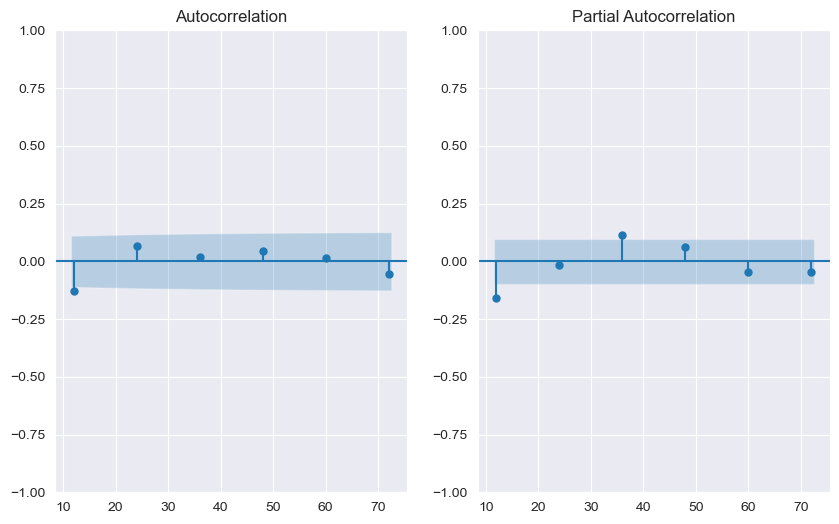

In [97]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
plot_acf(data_diff['Gas Consumption (tons)'], lags=[12,24,36,48,60,72], zero=False, ax=ax1)
plot_pacf(data_diff['Gas Consumption (tons)'], lags=[12,24,36,48,60,72], zero=False, ax=ax2)
plt.show()

From the ACF and PACF plots, it cuts off at lag-1, and so we will be setting P = 1 and Q = 1

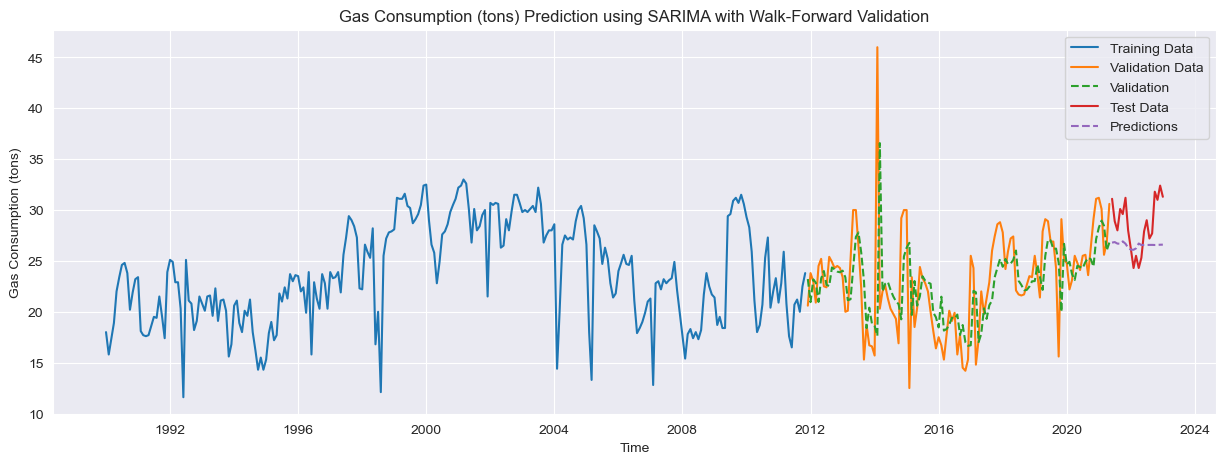

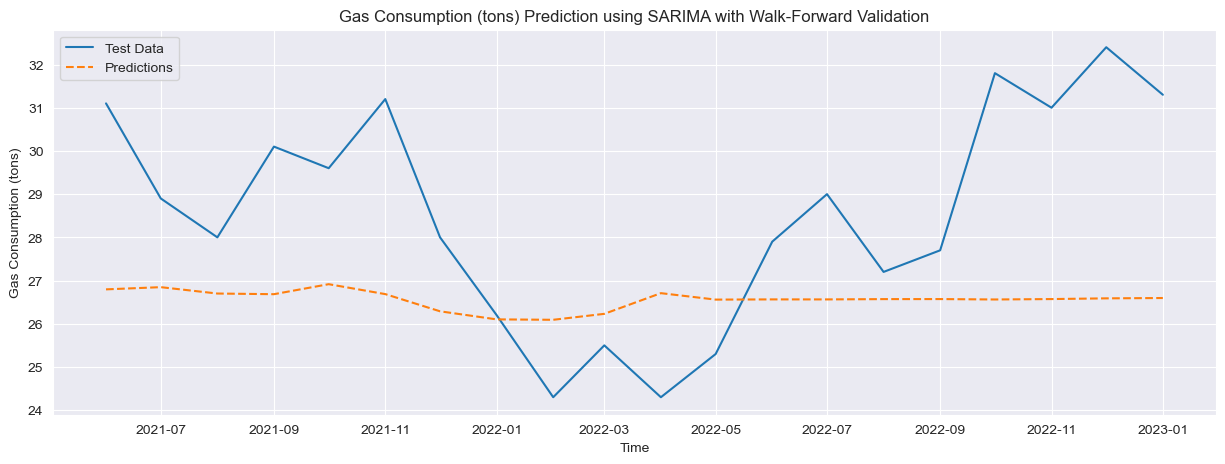

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  376
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -969.628
Date:                            Fri, 11 Aug 2023   AIC                           1949.255
Time:                                    09:41:57   BIC                           1968.699
Sample:                                         0   HQIC                          1956.986
                                            - 376                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4007      0.042      9.469      0.000       0.318       0.484
ma.L1         -0.8836      0.037   

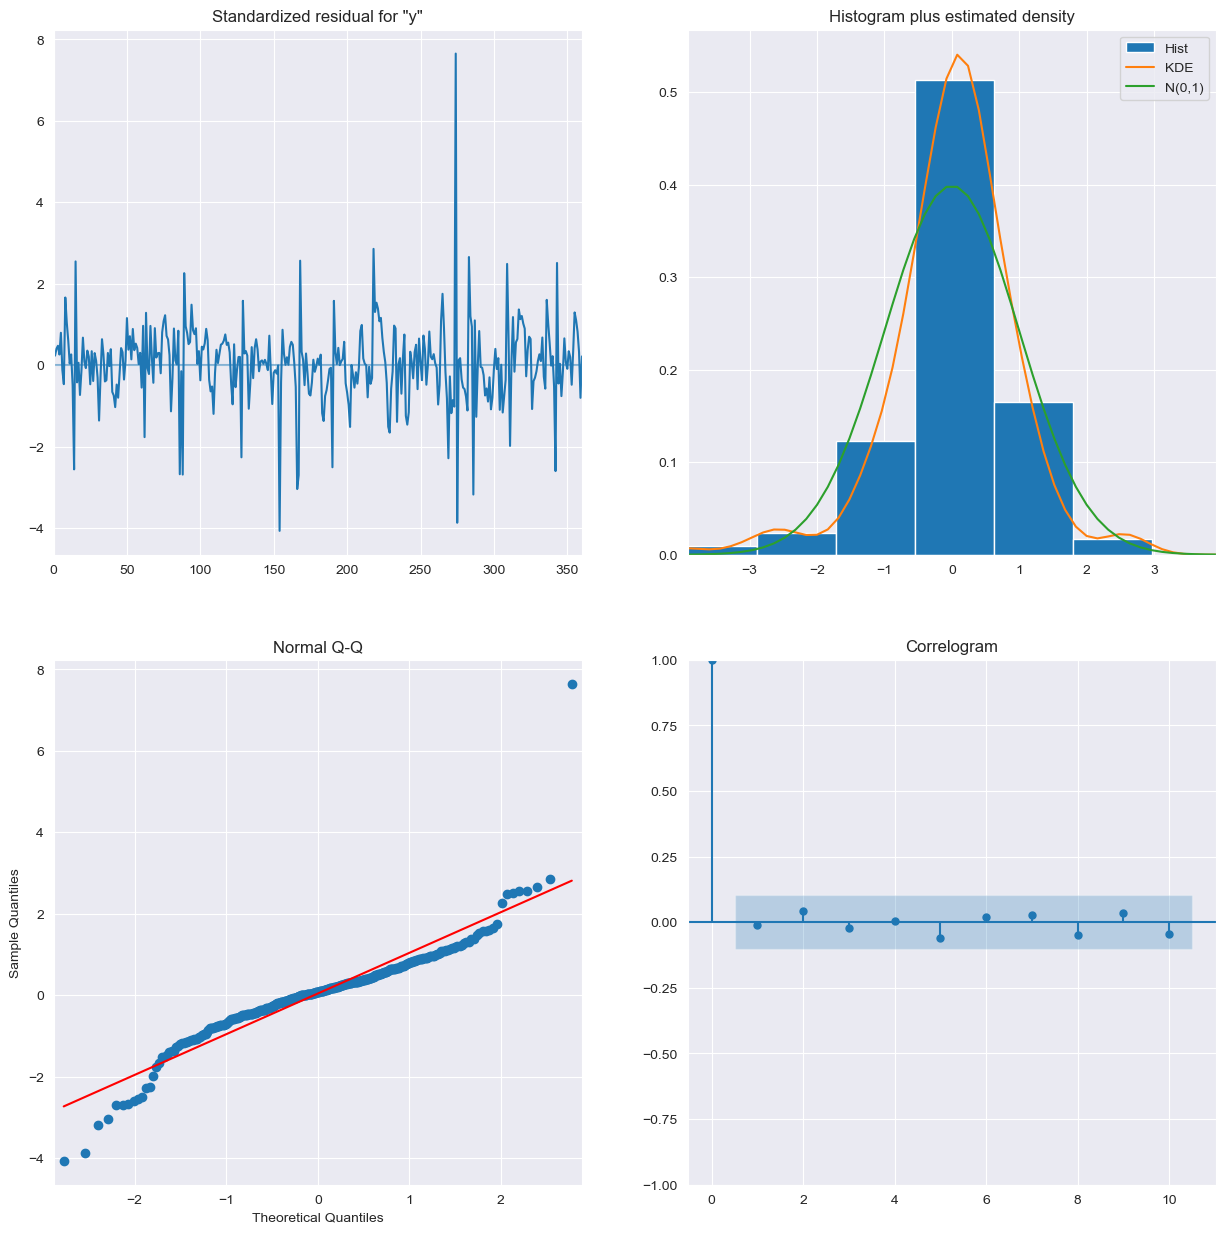

Validation Set RMSE for SARIMA with Walk-Forward Validation: 4.581462671879989
Validation Set MAPE for SARIMA with Walk-Forward Validation: 12.827819797517542 %

Test Set RMSE for SARIMA with Walk-Forward Validation: 3.0829108634463345
Test Set MAPE for SARIMA with Walk-Forward Validation: 8.769140764571956 %

AIC: 1949.2550692467628
BIC: 1968.6994590384272


(4.581462671879989,
 0.12827819797517542,
 3.0829108634463345,
 0.08769140764571956,
 1949.2550692467628,
 1968.6994590384272)

In [8]:
wf_validation_sarima(data['Gas Consumption (tons)'], 'Gas Consumption (tons)', (1,1,1), (1,0,1,12), True)

#### Gas Consumption SARIMA
- Seasonal coefficients are not statistically significant
- The errors caused are not white noise
- The residuals show no variances
- The data is normally distributed

We will also be looping through the seasonal P and Q to find the optimal value with the evaluation metrics in mind.

#### Tuning SARIMA Gas Consumption

In [122]:
orders=[]

for p in range(4):
    for q in range(4):
        try:
            val_rmse, val_mape, test_rmse, test_mape, aic, bic = wf_validation_sarima(data['Gas Consumption (tons)'], 'Gas Consumption (tons)', (1,1,1), (p,0,q,12), False)

            orders.append((p, q, val_rmse, val_mape, test_rmse, test_mape, aic, bic))
            
        except:
            orders.append((p, q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'val_rmse', 'val_mape', 'test_rmse', 'test_mape', 'aic', 'bic'])

order_df.sort_values('aic').head(5)

p  q  val_rmse  val_mape  test_rmse  test_mape          aic          bic
4   1  0  4.584779  0.127867   3.127947   0.088946  2013.963238  2029.670942
1   0  1  4.580349  0.127680   3.135033   0.089264  2014.276742  2029.984446
10  2  2  4.670828  0.130552   2.780954   0.081785  2015.081301  2042.569783
2   0  2  4.605465  0.129005   3.105290   0.087796  2015.412849  2035.047479
8   2  0  4.614421  0.129426   3.102314   0.087818  2015.574797  2035.209427

(P=1, Q=0)

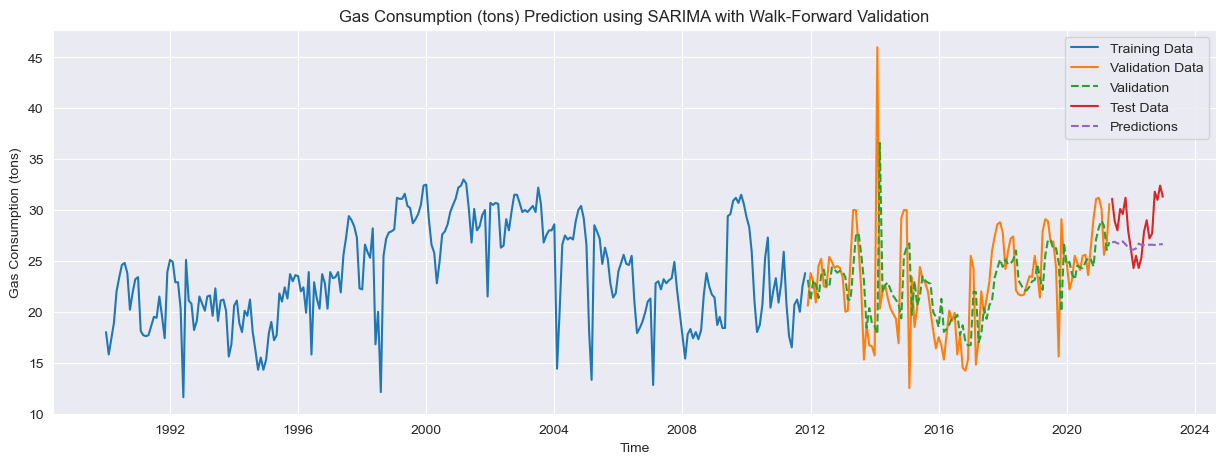

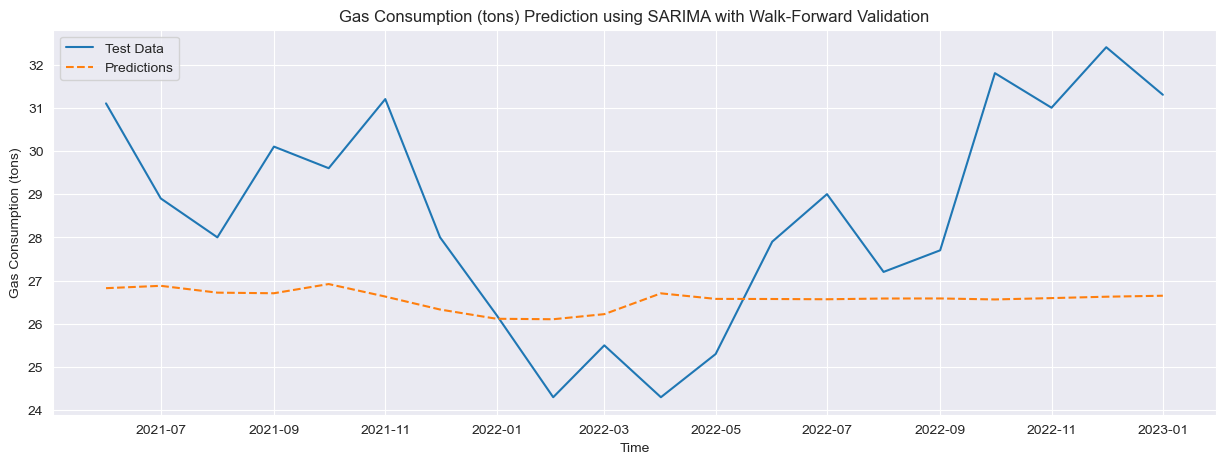

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  376
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -972.203
Date:                             Fri, 11 Aug 2023   AIC                           1952.407
Time:                                     09:42:44   BIC                           1967.973
Sample:                                          0   HQIC                          1958.595
                                             - 376                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3994      0.041      9.684      0.000       0.319       0.480
ma.L1         -0.8832      

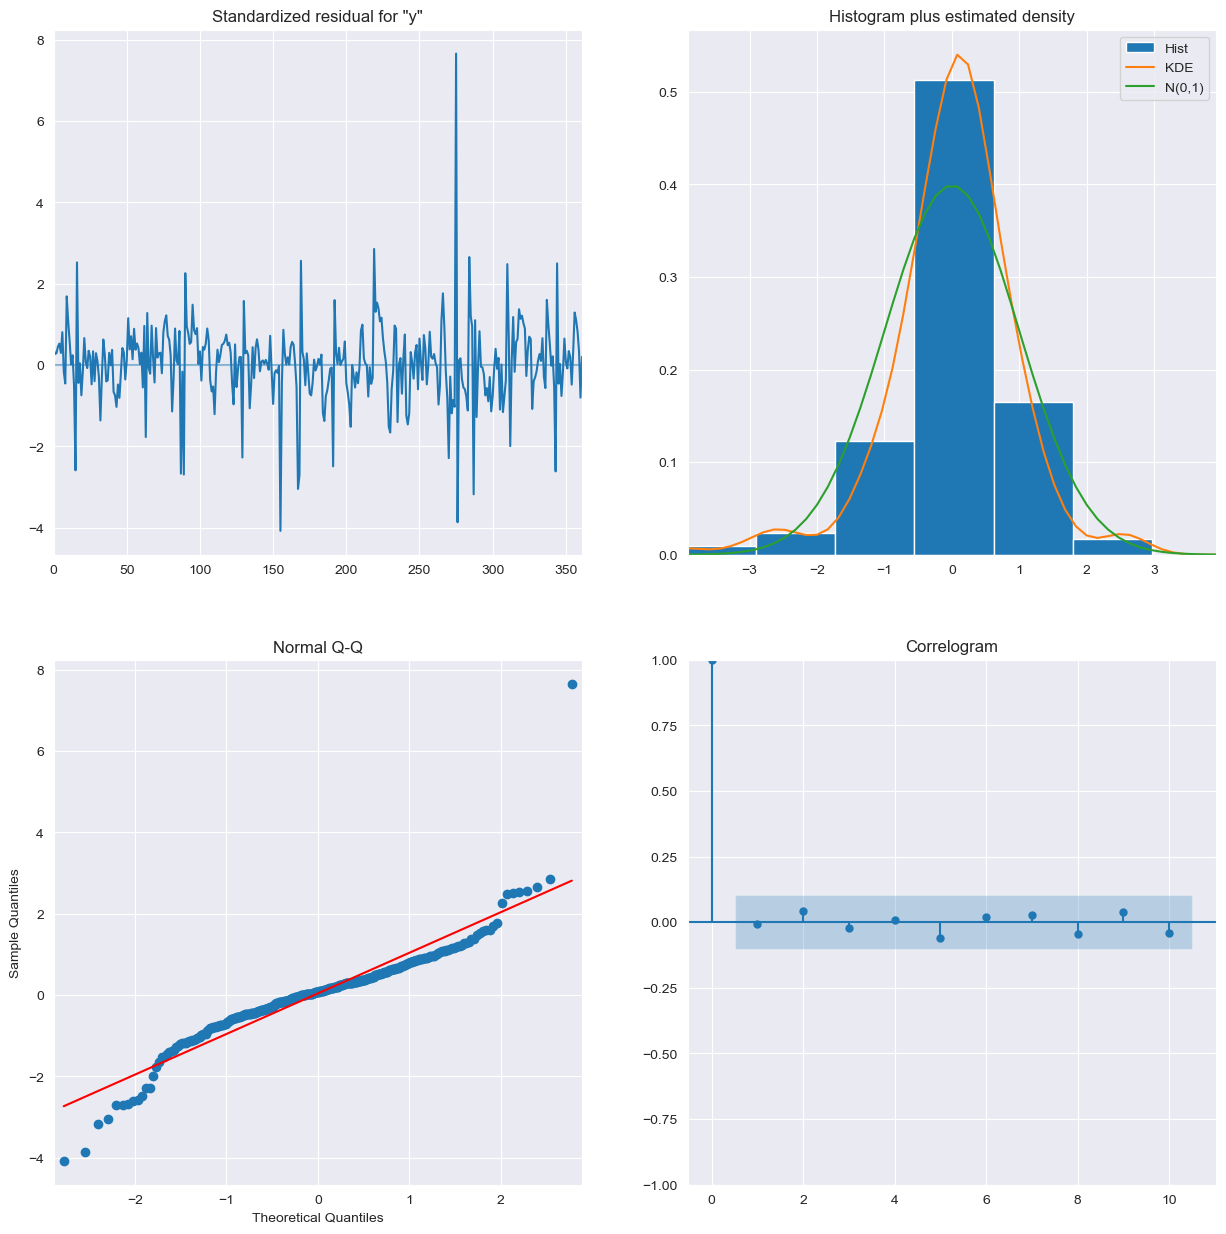

Validation Set RMSE for SARIMA with Walk-Forward Validation: 4.56015877607365
Validation Set MAPE for SARIMA with Walk-Forward Validation: 12.75770310408012 %

Test Set RMSE for SARIMA with Walk-Forward Validation: 3.071686441520576
Test Set MAPE for SARIMA with Walk-Forward Validation: 8.728866183955915 %

AIC: 1952.4067479566393
BIC: 1967.9733248039424


(4.56015877607365,
 0.1275770310408012,
 3.071686441520576,
 0.08728866183955916,
 1952.4067479566393,
 1967.9733248039424)

In [9]:
wf_validation_sarima(data['Gas Consumption (tons)'], 'Gas Consumption (tons)', (1,1,1), (1,0,0,12), True)

Untuned:<br>
(4.581462671879989,
 0.12827819797517542,
 3.0829108634463345,
 0.08769140764571956,
 1949.2550692467628,
 1968.6994590384272)
 
 
#### Gas Consumption SARIMA (Tuned)
- All coefficients are statistically significant
- The errors caused are not white noise
- The residuals show no variances
- The data is normally distributed

We can see a slight improvement in the metrics

#### SARIMA for Electricity Consumption

Due to this time series's strong seasonal pattern, we will be applying one order of seasonal differencing on top of the non-seasonal differencing

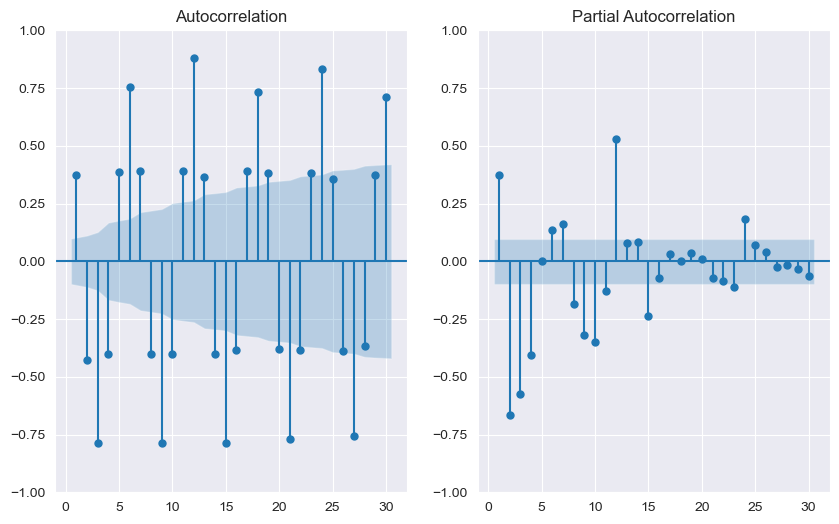

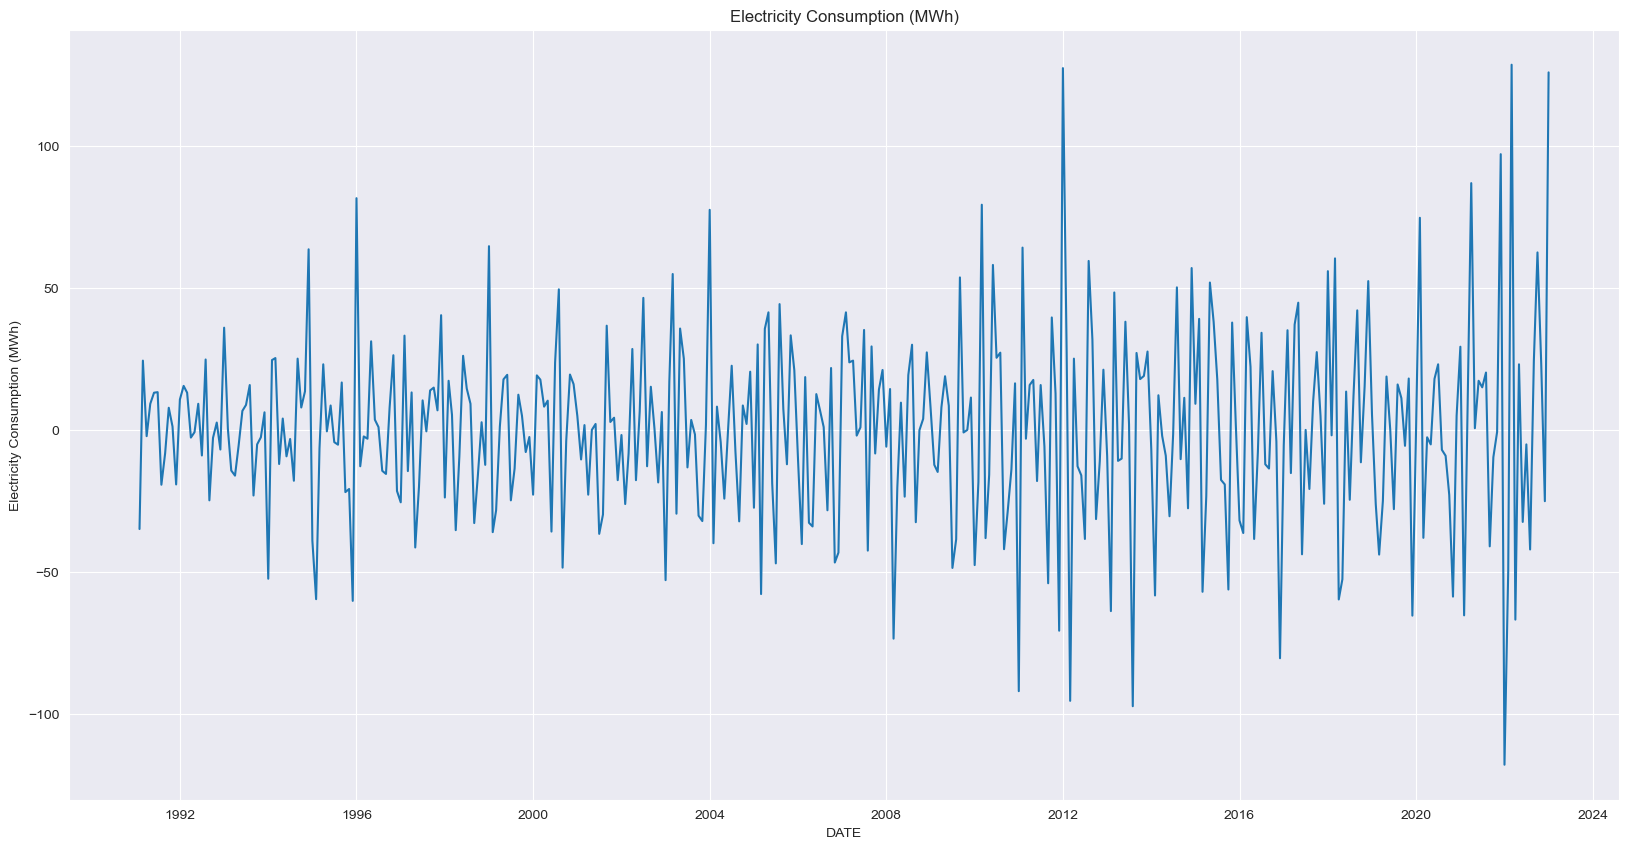

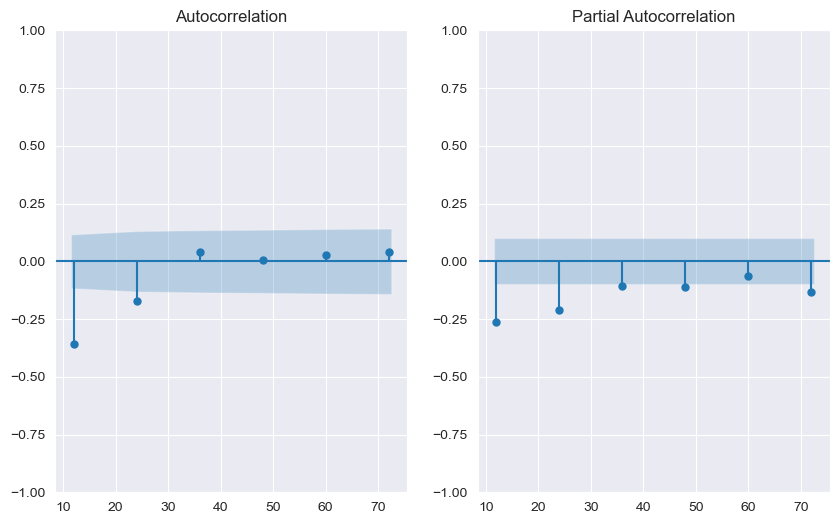

In [90]:
elec_seasonal_diff = pd.DataFrame(data['Electricity Consumption (MWh)'].diff().diff(12).dropna())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
plot_acf(data_diff['Electricity Consumption (MWh)'], lags=30, zero=False, ax=ax1)
plot_pacf(data_diff['Electricity Consumption (MWh)'], lags=30, zero=False, ax=ax2)
plt.show()

sns.lineplot(data=elec_seasonal_diff, x=elec_seasonal_diff.index, y='Electricity Consumption (MWh)')
plt.title('Electricity Consumption (MWh)')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
plot_acf(elec_seasonal_diff['Electricity Consumption (MWh)'], lags=[12,24,36,48,60,72], zero=False, ax=ax1)
plot_pacf(elec_seasonal_diff['Electricity Consumption (MWh)'], lags=[12,24,36,48,60,72], zero=False, ax=ax2)
plt.show()

From the seasonal ACF and PACF, we can see that the PACF tails off while the ACF cuts off at lag 24, which signifies a seasonal order of (0,1,2,12)

To find the non-seasonal order p and q, the ACF and PACF plots are hard to interpret. <br>
Hence, we will try using a non-seasonal order of (1,1,1) to start, and then loop the non-seasonal and seasonal orders to find the optimal orders

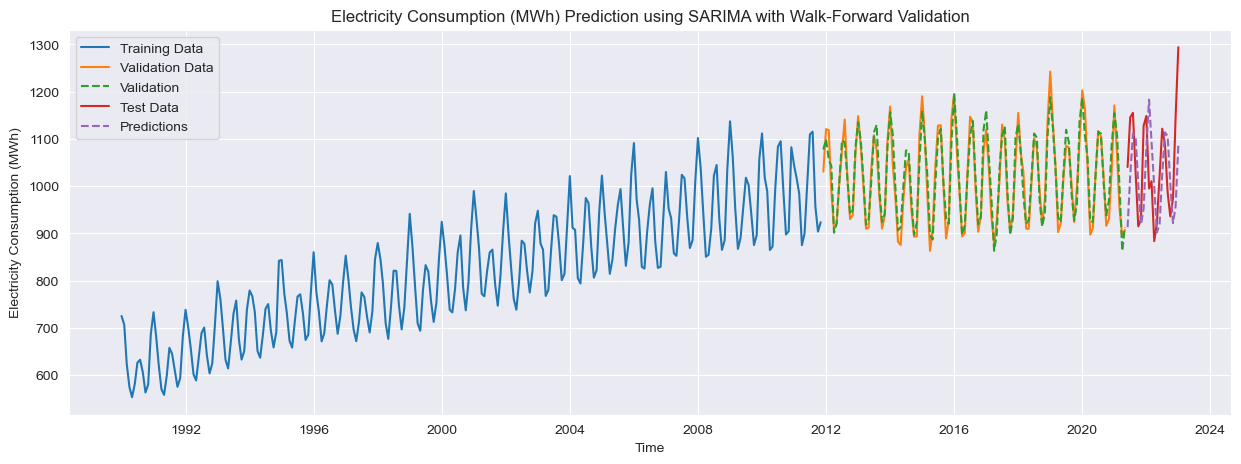

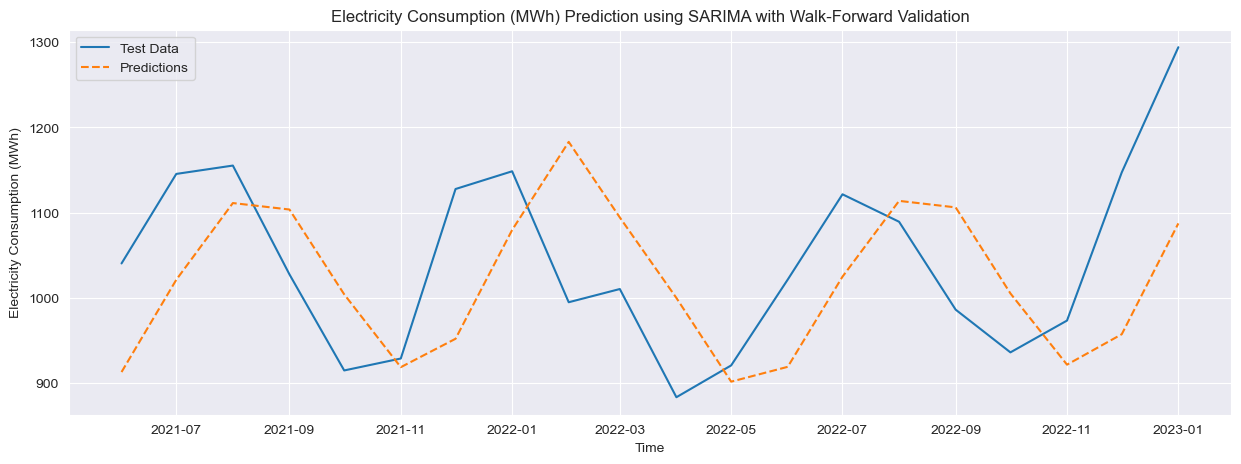

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  376
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1543.058
Date:                                 Fri, 11 Aug 2023   AIC                           3096.116
Time:                                         09:49:25   BIC                           3115.216
Sample:                                              0   HQIC                          3103.729
                                                 - 376                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5273      0.054      9.717      0.000       0.421       0

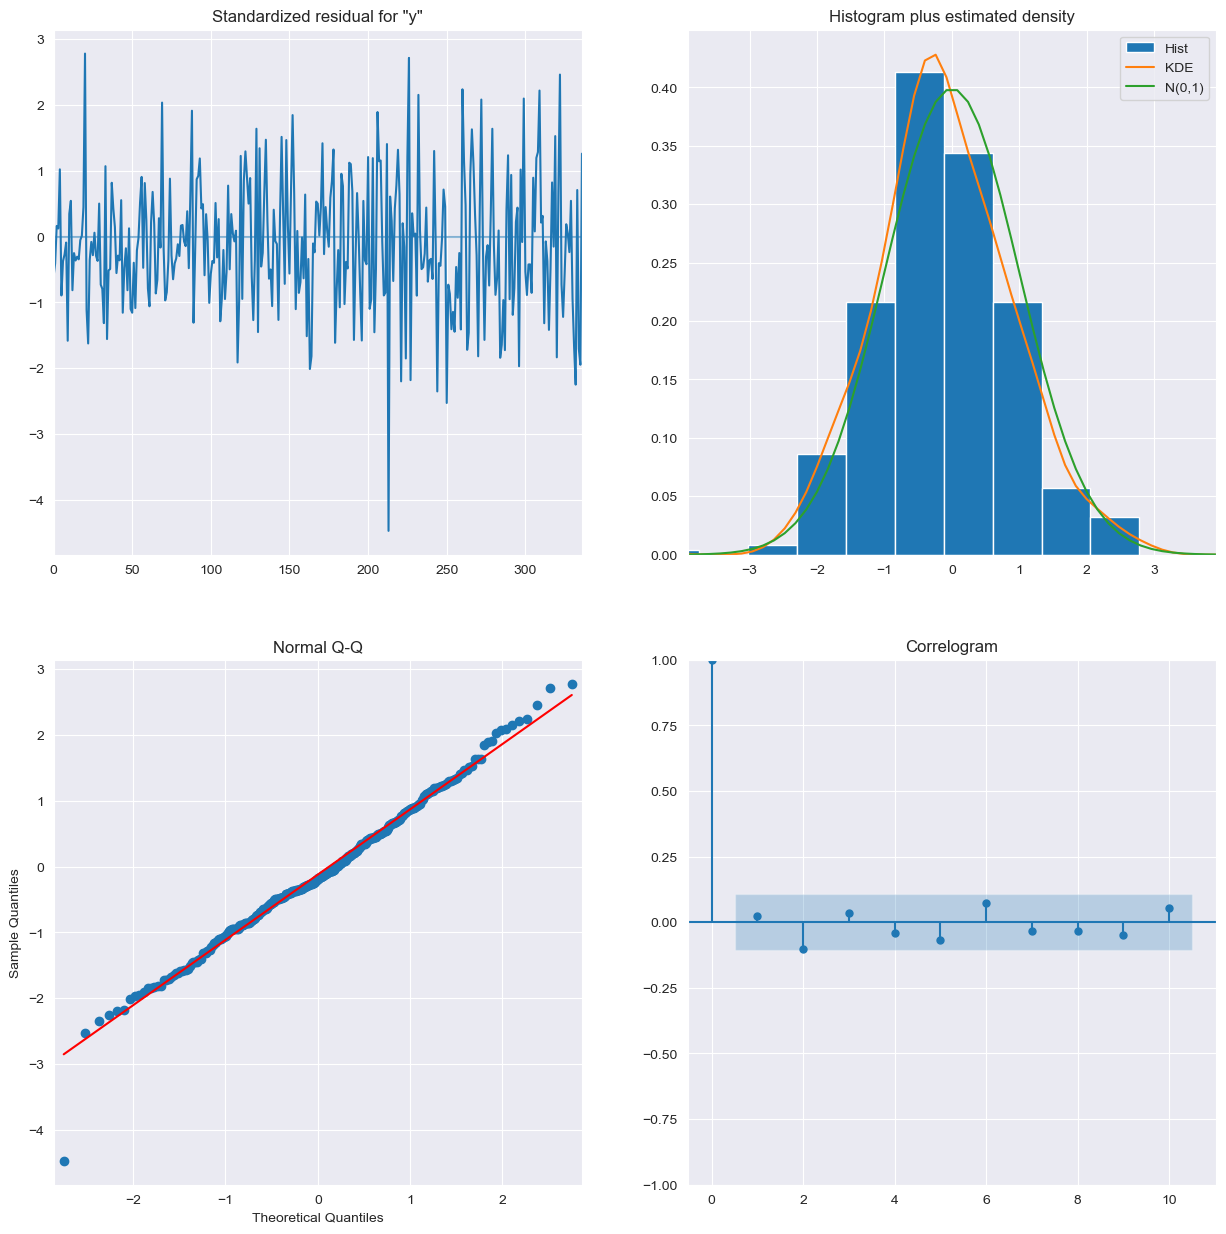

Validation Set RMSE for SARIMA with Walk-Forward Validation: 27.76182017702682
Validation Set MAPE for SARIMA with Walk-Forward Validation: 2.1901528287149046 %

Test Set RMSE for SARIMA with Walk-Forward Validation: 114.09239941346173
Test Set MAPE for SARIMA with Walk-Forward Validation: 9.371531071876532 %

AIC: 3096.115909176405
BIC: 3115.2163238281664


(27.76182017702682,
 0.021901528287149044,
 114.09239941346173,
 0.09371531071876532,
 3096.115909176405,
 3115.2163238281664)

In [10]:
wf_validation_sarima(data['Electricity Consumption (MWh)'], 'Electricity Consumption (MWh)', (1,1,1), (0,1,2,12), True)

#### Electricity Consumption SARIMA
- Seasonal coefficients of MA(2) is not statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

#### Tuning SARIMA Electricity Consumption

In [126]:
orders=[]

for p in range(4):
    for q in range(4):
        for season_p in range(4):
            for season_q in range(4):
                try:
                    val_rmse, val_mape, test_rmse, test_mape, aic, bic = wf_validation_sarima(data['Electricity Consumption (MWh)'], 'Electricity Consumption (MWh)', (p,1,q), (season_p,0,season_q,12), False)

                    orders.append((p, q, season_p, season_q, val_rmse, val_mape, test_rmse, test_mape, aic, bic))
            
                except:
                    orders.append((p, q, season_p, season_q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'seasonal_P', 'seasonal_Q', 'val_rmse', 'val_mape', 'test_rmse', 'test_mape', 'aic', 'bic'])

order_df.sort_values('aic').head(5)

p  q  seasonal_P  seasonal_Q      val_rmse    val_mape   test_rmse  \
157  2  1           3           1  2.724126e+01    0.021261  111.231580   
55   0  3           1           3  2.430254e+04    2.060370  112.265878   
153  2  1           2           1  1.019866e+02    0.030827  112.904920   
181  2  3           1           1  1.149755e+04    1.097396  123.160807   
231  3  2           1           3  1.735971e+06  144.601421  120.150577   

     test_mape          aic          bic  
157   0.090981  3446.919577  3478.334985  
55    0.091960  3452.457776  3483.873184  
153   0.092346  3454.277344  3481.765826  
181   0.099173  3472.126364  3503.541772  
231   0.098299  3479.038382  3518.307642

(p=2, q=1, P=3, Q=1)

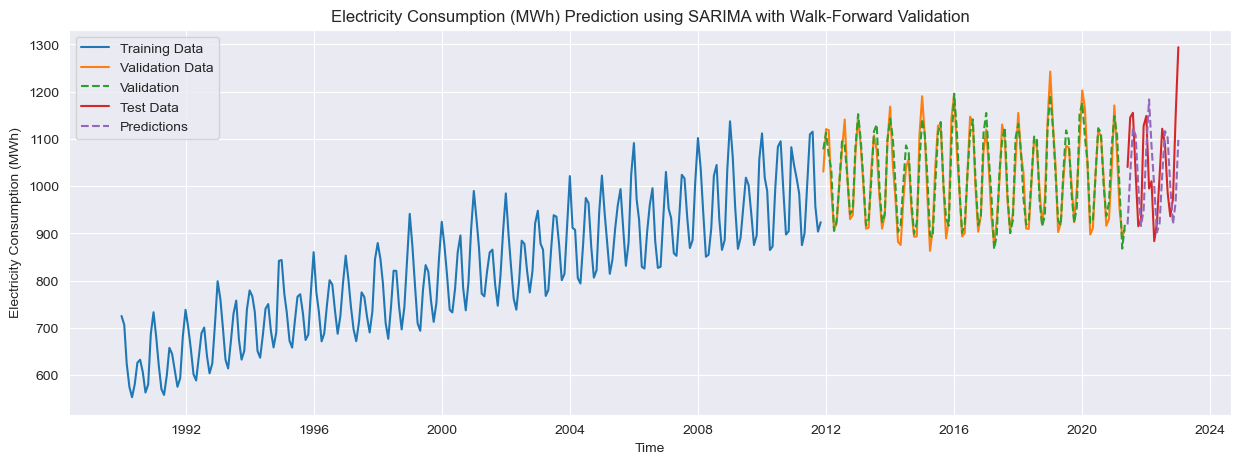

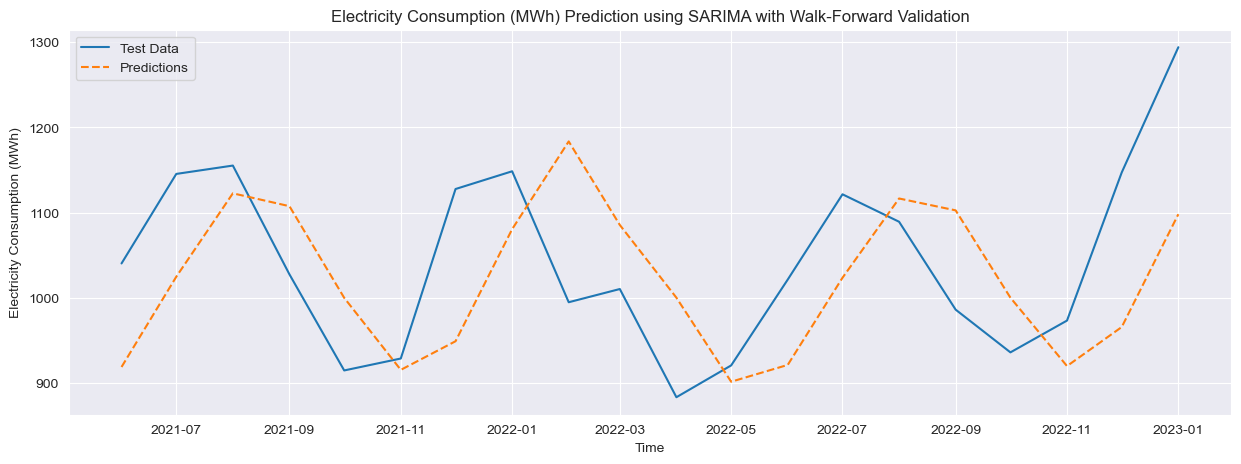

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  376
Model:             SARIMAX(2, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1484.090
Date:                            Fri, 11 Aug 2023   AIC                           2984.179
Time:                                    10:34:50   BIC                           3014.450
Sample:                                         0   HQIC                          2996.260
                                            - 376                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5389      0.058      9.228      0.000       0.424       0.653
ar.L2         -0.0669      0.057   

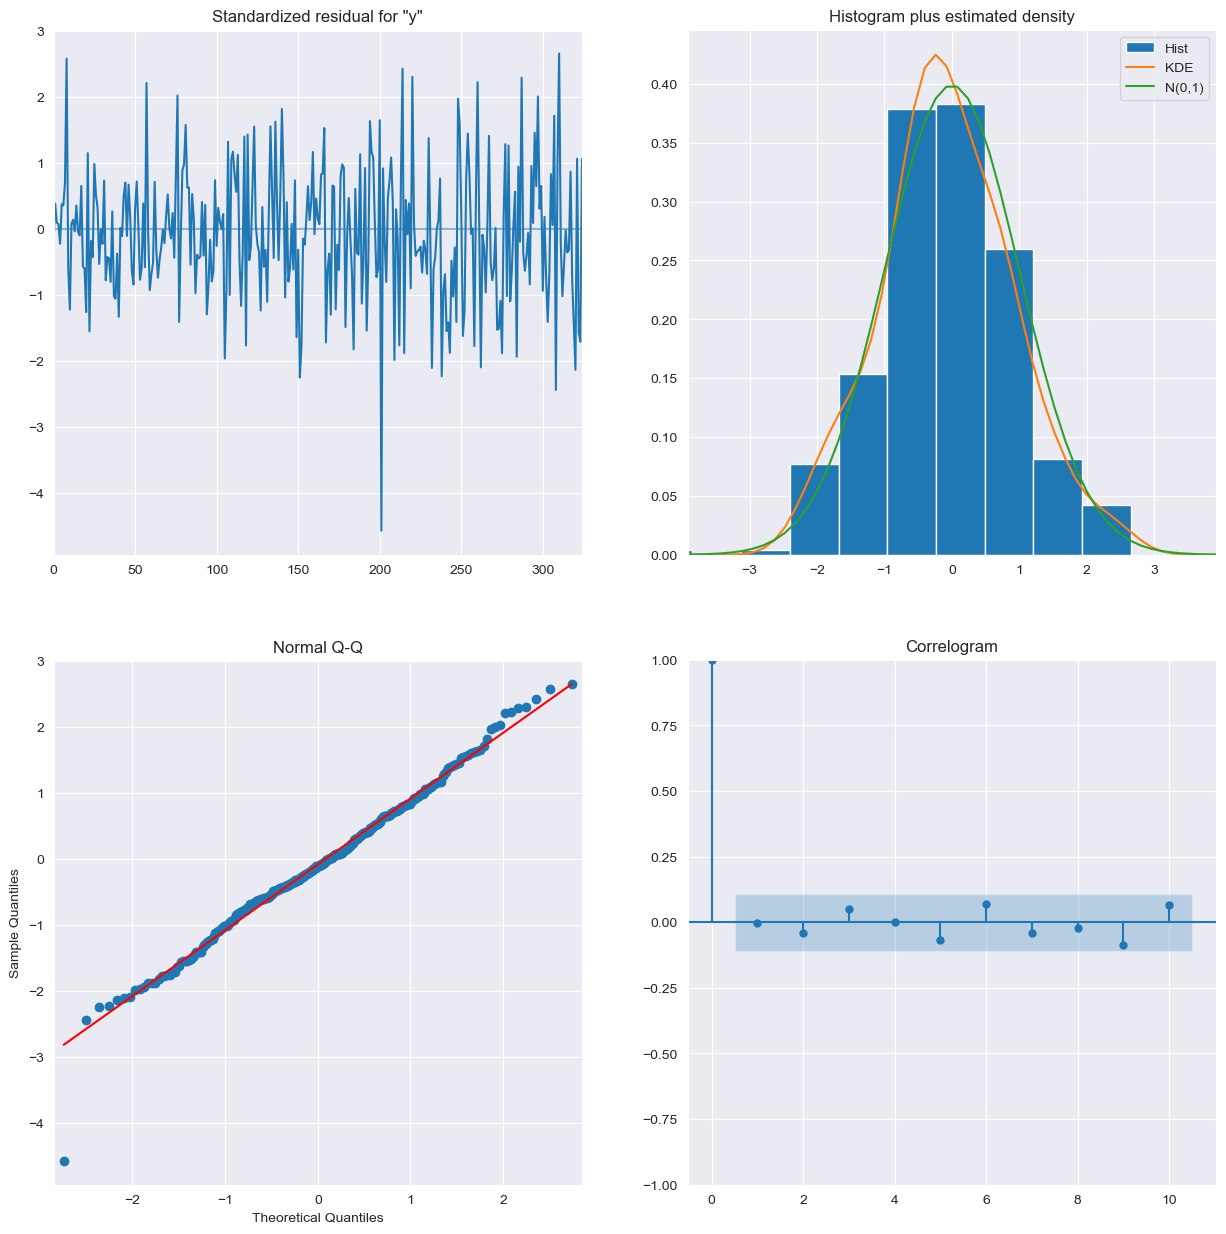

Validation Set RMSE for SARIMA with Walk-Forward Validation: 27.886829052707338
Validation Set MAPE for SARIMA with Walk-Forward Validation: 2.1817251317558193 %

Test Set RMSE for SARIMA with Walk-Forward Validation: 111.35686557781999
Test Set MAPE for SARIMA with Walk-Forward Validation: 9.154864480907902 %

AIC: 2984.179116901829
BIC: 3014.4497183604667


(27.886829052707338,
 0.02181725131755819,
 111.35686557781999,
 0.09154864480907901,
 2984.179116901829,
 3014.4497183604667)

In [11]:
wf_validation_sarima(data['Electricity Consumption (MWh)'], 'Electricity Consumption (MWh)', (2,1,1), (3,1,1,12), True)

Untuned: <br>
(27.76182017702682,
 0.021901528287149044,
 114.09239941346173,
 0.09371531071876532,
 3096.115909176405,
 3115.2163238281664)
 
#### Electricity Consumption SARIMA (Tuned)
- Some coefficients are not statistically significant
- The errors caused are not white noise
- The residuals show no variances
- The data is normally distributed

After tuning the order values, we can see that the model is better against test data as the RMSE and MAPE for test data is lower than the untuned.<br>
The AIC and BIC have also decreased

#### SARIMA for Water Consumption

Water Consumption
----------------------------------------
p-value with Augmented Dickey–Fuller test: 0.958532086052169
p-value with Kwiatkowski-Phillips-Schmidt-Shin test: 0.1

Series is not stationary from ADF test
Series is trend stationary from KPSS test



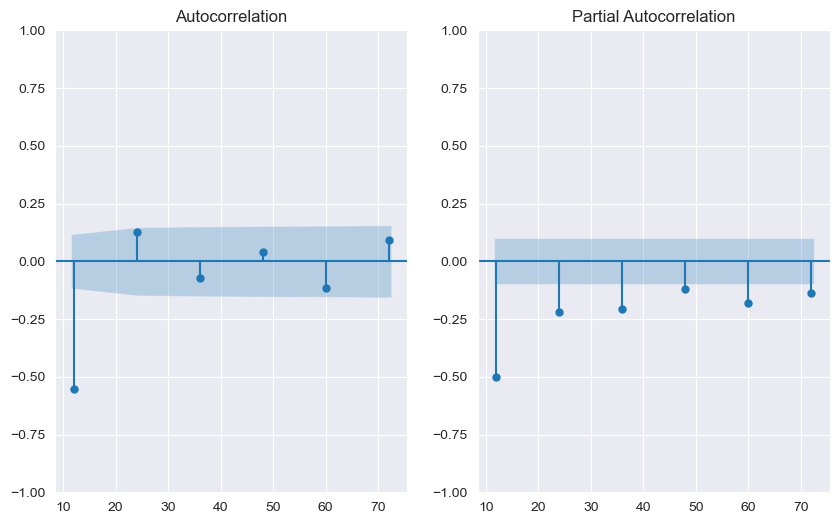

In [144]:
result = seasonal_decompose(data['Water Consumption (tons)'])

adftest = adfuller(result.seasonal)
kpsstest = kpss(result.seasonal)
line = '-'*40
print(f'Water Consumption\n{line}')
print(f'p-value with Augmented Dickey–Fuller test: {adftest[1]}')
print(f'p-value with Kwiatkowski-Phillips-Schmidt-Shin test: {kpsstest[1]}\n')
if adftest[1] <= 0.05:
    print(f'Series is stationary from ADF test')
else:
    print(f'Series is not stationary from ADF test')
if kpsstest[1] > 0.05:
    print(f'Series is trend stationary from KPSS test\n')
else:
    print(f'Series is not trend stationary from KPSS test\n')
        
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
plot_acf(data_diff['Water Consumption (tons)'].diff(12).dropna(), lags=[12,24,36,48,60,72], zero=False, ax=ax1)
plot_pacf(data_diff['Water Consumption (tons)'].diff(12).dropna(), lags=[12,24,36,48,60,72], zero=False, ax=ax2)
plt.show()

Here we first check if the seasonal component is stationary. From the ADF test, it seems that it is not stationary, so may have to add one order of seasonal differencing.

The ACF and PACF plots of the differenced data show that:
- PACF tails off
- ACF cuts off at lag-1

Thus, we will be using a seasonal order of (0,1,1,12)

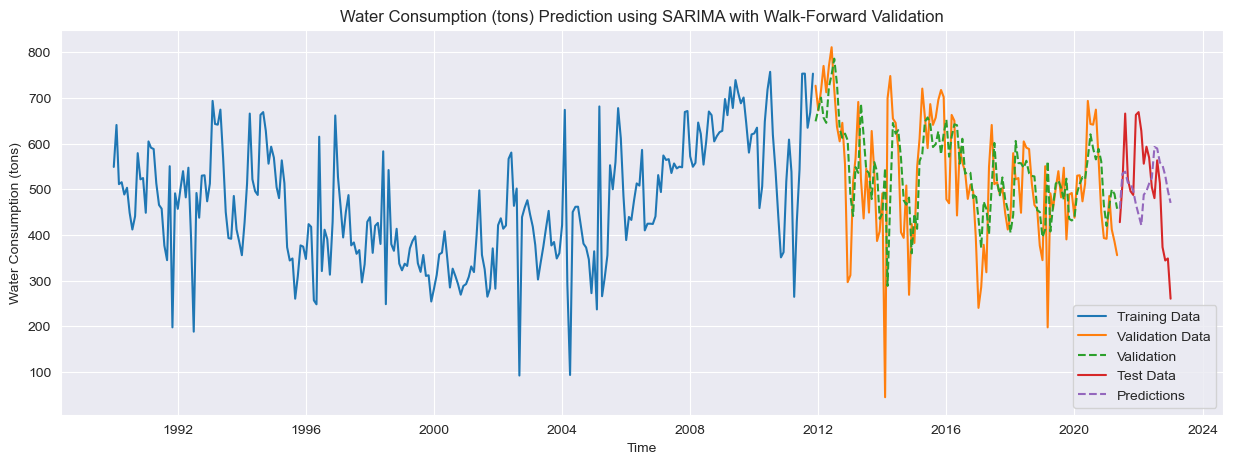

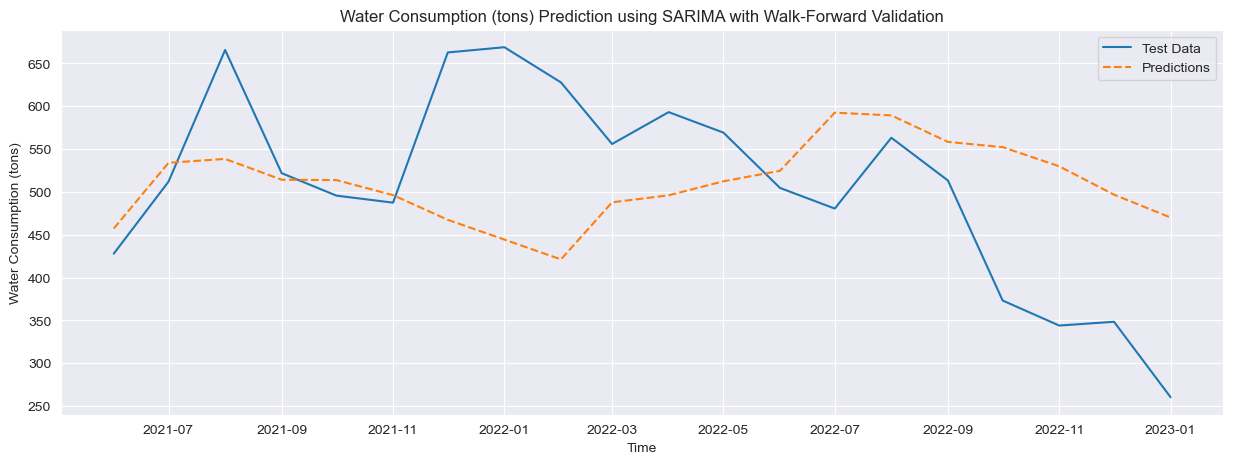

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  376
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2122.640
Date:                              Fri, 11 Aug 2023   AIC                           4255.280
Time:                                      10:39:57   BIC                           4274.541
Sample:                                           0   HQIC                          4262.949
                                              - 376                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8615      0.044     19.714      0.000       0.776       0.947
ma.L1         -1.46

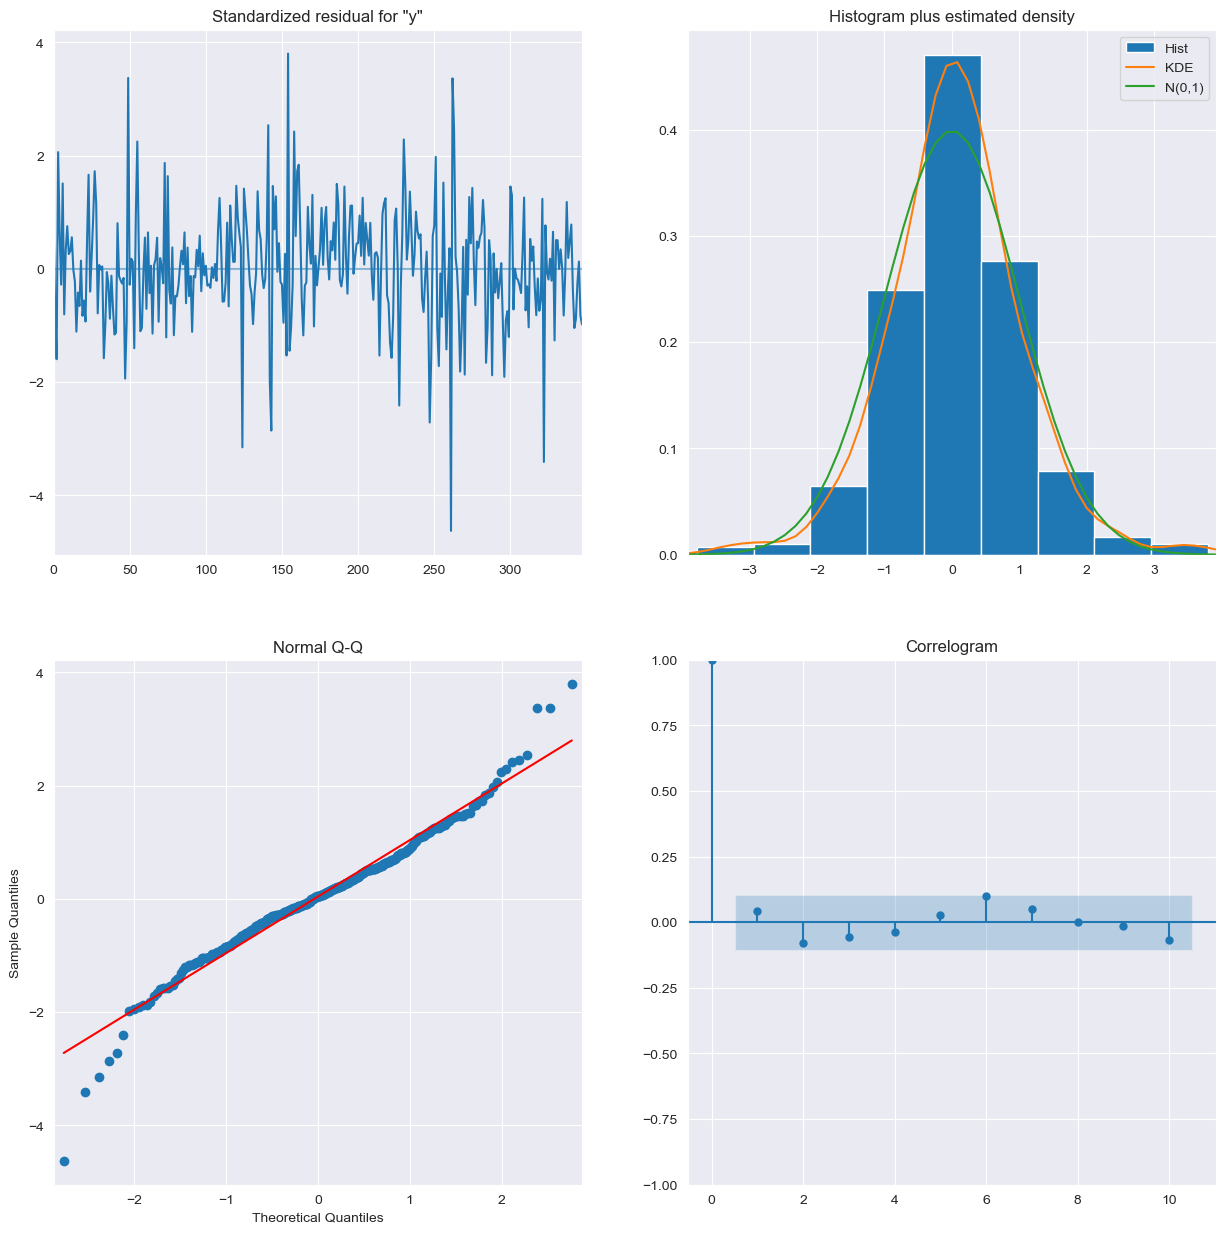

Validation Set RMSE for SARIMA with Walk-Forward Validation: 116.37119881651387
Validation Set MAPE for SARIMA with Walk-Forward Validation: 27.39729276985279 %

Test Set RMSE for SARIMA with Walk-Forward Validation: 125.50506423209883
Test Set MAPE for SARIMA with Walk-Forward Validation: 21.89168581442206 %

AIC: 4255.280464696527
BIC: 4274.541477095399


(116.37119881651387,
 0.2739729276985279,
 125.50506423209883,
 0.2189168581442206,
 4255.280464696527,
 4274.541477095399)

In [12]:
wf_validation_sarima(data['Water Consumption (tons)'], 'Water Consumption (tons)', (1,1,2), (0,1,1,12), True)

#### Water Consumption SARIMA
- All coefficients are statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

#### Tuning SARIMA Water Consumption

In [142]:
orders=[]

for p in range(4):
    for q in range(4):
        try:
            val_rmse, val_mape, test_rmse, test_mape, aic, bic = wf_validation_sarima(data['Water Consumption (tons)'], 'Water Consumption (tons)', (1,1,2), (p,1,q,12), False)

            orders.append((p, q, val_rmse, val_mape, test_rmse, test_mape, aic, bic))
            
        except:
            orders.append((p, q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'val_rmse', 'val_mape', 'test_rmse', 'test_mape', 'aic', 'bic'])

order_df.sort_values('aic').head(5)

p  q    val_rmse  val_mape   test_rmse  test_mape          aic  \
3   0  3  115.313634  0.275426  124.501838   0.224220  3963.780874   
7   1  3  116.970806  0.278322  124.686933   0.227497  3965.783022   
15  3  3  117.910939  0.280626  121.624892   0.220172  3970.718504   
11  2  3  115.414622  0.271812  112.403581   0.203547  3985.069580   
13  3  1  118.077201  0.277624  125.139403   0.225199  3990.994943   

            bic  
3   3990.246079  
7   3996.028970  
15  4008.525939  
11  4019.096271  
13  4021.290122

(P=0,Q=3)

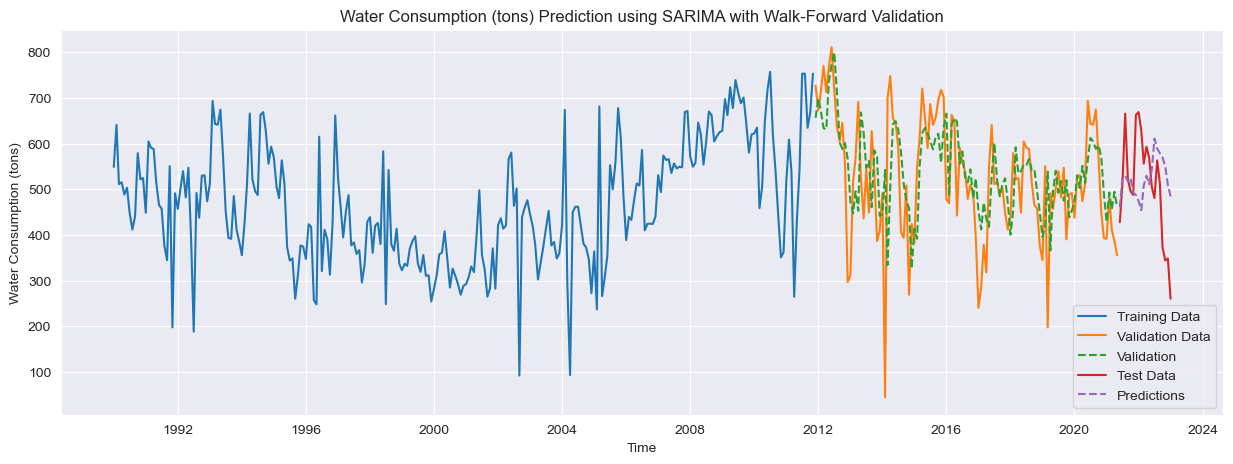

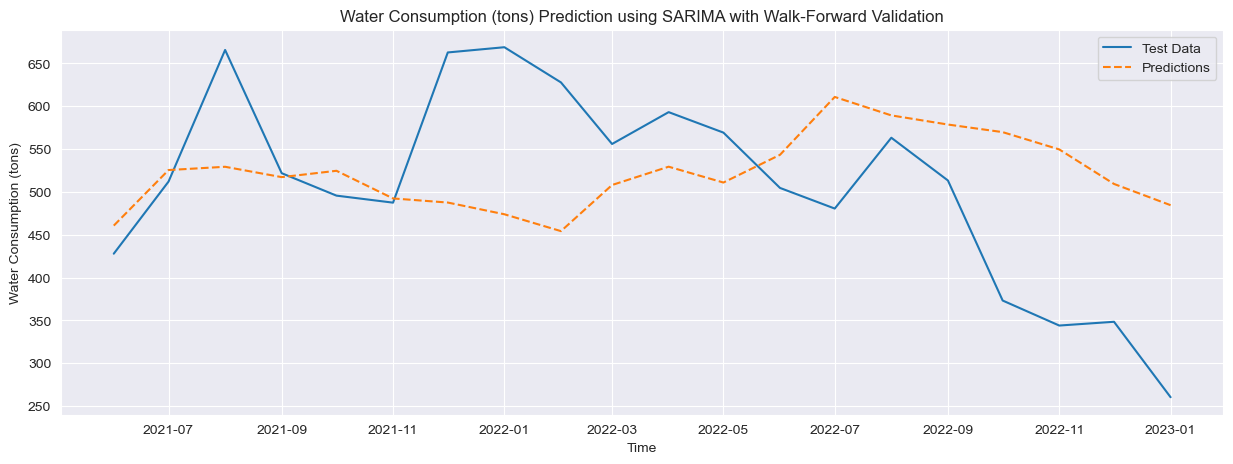

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  376
Model:             SARIMAX(1, 1, 2)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -1974.890
Date:                                    Fri, 11 Aug 2023   AIC                           3963.781
Time:                                            11:40:15   BIC                           3990.246
Sample:                                                 0   HQIC                          3974.344
                                                    - 376                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8337      0.049     16.871      0

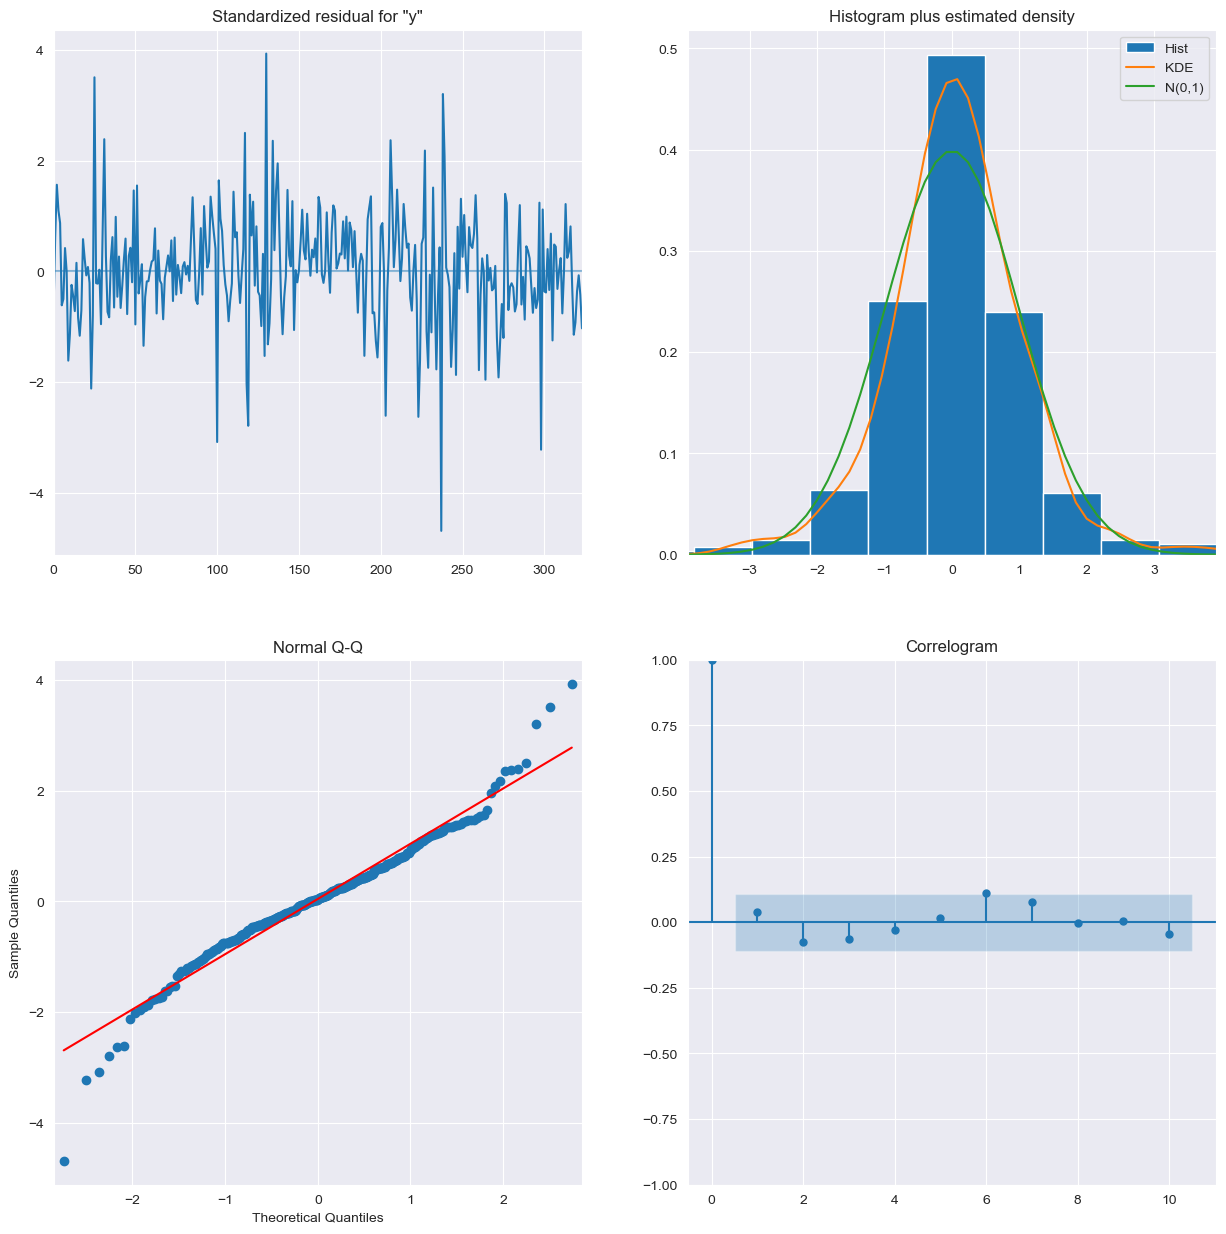

Validation Set RMSE for SARIMA with Walk-Forward Validation: 115.56665731382945
Validation Set MAPE for SARIMA with Walk-Forward Validation: 27.587415279725118 %

Test Set RMSE for SARIMA with Walk-Forward Validation: 124.50232582088695
Test Set MAPE for SARIMA with Walk-Forward Validation: 22.422124056901755 %

AIC: 3963.7808739230068
BIC: 3990.246078533553


(115.56665731382945,
 0.2758741527972512,
 124.50232582088695,
 0.22422124056901754,
 3963.7808739230068,
 3990.246078533553)

In [13]:
wf_validation_sarima(data['Water Consumption (tons)'], 'Water Consumption (tons)', (1,1,2), (0,1,3,12), True)

Untuned:<br>
(116.37119881651387,
0.2739729276985279,
125.50506423209883,
0.2189168581442206,
4255.280464696527,
4274.541477095399)

#### Electricity Consumption SARIMA (Tuned)
- Seasonal coefficients of MA(2) is not statistically significant, however MA(2) is statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

We can see that the scores have decreased after tuning the order values

### Vector Auto Regressive Moving Average (VARMA)

VARMA is similar to ARIMA, however it helps in multivariate time series.

From the Granger Causality test we performed earlier, we can see that:
- Gas Consumption granger causes Water Consumption
- Electricity Consumption granger causes Water Consumption

In [108]:
# data[['Water Consumption (tons)', 'Gas Consumption (tons)']]
# data[['Water Consumption (tons)', 'Electricity Consumption (MWh)']]

In [111]:
def wf_validation_varma(x, name1, name2, order, plot): 
    size = int(len(x) * 0.95)
    train, test = x[0:size], x[size:len(x)]
    
    train_size = int(len(train.values) * 0.70)
    train, validation = train[0:train_size], train[train_size:len(train.values)]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    prediction = []
    for row in validation.itertuples(index=False):
        model = VARMAX(train, order=order, enforce_stationarity=True).fit(max_iter=1000, disp=False)
        y = model.forecast(steps=1)
        prediction.append(y)
        row_dict = {name1: row[0], name2: row[1]}
        train = train.append(row_dict, ignore_index=True)
    
    prediction_df = pd.concat([pd.DataFrame(p, columns=[name1, name2]) for p in prediction], ignore_index=True)
    
    test_pred = model.forecast(steps=len(test))

    validation_ = pd.DataFrame(validation, columns=[name1, name2])
    validation_['predictions_wf_1'] = prediction_df[name1].values
    validation_['predictions_wf_2'] = prediction_df[name2].values

    test_ = pd.DataFrame(test, columns=[name1, name2])
    test_['predictions_test_1'] = test_pred[name1].values
    test_['predictions_test_2'] = test_pred[name2].values

    val_rmse_1 = sqrt(mean_squared_error(validation[name1], prediction_df[name1]))
    val_mape_1 = mean_absolute_percentage_error(validation[name1], prediction_df[name1])
    val_rmse_2 = sqrt(mean_squared_error(validation[name2], prediction_df[name2]))
    val_mape_2 = mean_absolute_percentage_error(validation[name2], prediction_df[name2])
    
    test_rmse_1 = sqrt(mean_squared_error(test[name1], test_pred[name1]))
    test_mape_1 = mean_absolute_percentage_error(test[name1], test_pred[name1])
    test_rmse_2 = sqrt(mean_squared_error(test[name2], test_pred[name2]))
    test_mape_2 = mean_absolute_percentage_error(test[name2], test_pred[name2])
    
    aic = model.aic
    bic = model.bic
    
    first_split_size = int(len(data[[name1, name2]]) * 0.95)
    second_split_size = int(first_split_size * 0.70)

    first_split = data[[name1, name2]].iloc[:first_split_size]
    second_split = first_split.iloc[:second_split_size]

    if plot == True:
        plt.subplots(figsize=(15,5))
        plt.plot(second_split[name1], label='Training Data')
        plt.plot(validation_[name1], label='Validation Data')
        plt.plot(validation_['predictions_wf_1'], '--', label='Validation')
        plt.plot(test_[name1], label='Test Data')
        plt.plot(test_['predictions_test_1'], '--', label='Predictions')
        plt.title(f'{name1} Prediction using VARMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name1}')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.subplots(figsize=(15,5))
        plt.plot(test_[name1], label='Test Data')
        plt.plot(test_['predictions_test_1'], '--', label='Predictions')
        plt.title(f'{name1} Prediction using VARMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name1}')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.subplots(figsize=(15,5))
        plt.plot(second_split[name2], label='Training Data')
        plt.plot(validation_[name2], label='Validation Data')
        plt.plot(validation_['predictions_wf_2'], '--', label='Validation')
        plt.plot(test_[name2], label='Test Data')
        plt.plot(test_['predictions_test_2'], '--', label='Predictions')
        plt.title(f'{name2} Prediction using VARMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name2}')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.subplots(figsize=(15,5))
        plt.plot(test_[name2], label='Test Data')
        plt.plot(test_['predictions_test_2'], '--', label='Predictions')
        plt.title(f'{name2} Prediction using VARMA with Walk-Forward Validation')
        plt.xlabel('Time')
        plt.ylabel(f'{name2}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        print(model.summary())
        model.plot_diagnostics(figsize=(15,15))
        plt.show()

        print(f'{name1} Validation Set RMSE for VARMA with Walk-Forward Validation: {val_rmse_1}')
        print(f'{name1} Validation Set MAPE for VARIMA with Walk-Forward Validation: {val_mape_1*100} %\n')
    
        print(f'{name1} Test Set RMSE for VARMA with Walk-Forward Validation: {test_rmse_1}')
        print(f'{name1} Test Set MAPE for VARMA with Walk-Forward Validation: {test_mape_1*100} %\n')

        print(f'{name2} Validation Set RMSE for VARMA with Walk-Forward Validation: {val_rmse_2}')
        print(f'{name2} Validation Set MAPE for VARIMA with Walk-Forward Validation: {val_mape_2*100} %\n')
    
        print(f'{name2} Test Set RMSE for VARMA with Walk-Forward Validation: {test_rmse_2}')
        print(f'{name2} Test Set MAPE for VARMA with Walk-Forward Validation: {test_mape_2*100} %\n')
    
        print(f'AIC: {aic}\nBIC: {bic}')
    
    return val_rmse_1, val_mape_1, test_rmse_1, test_mape_1, val_rmse_2, val_mape_2, test_rmse_2, test_mape_2, aic, bic

We will start by looping through values of p and q to find the optimal VARMA order

#### VARMA for Water and Gas Consumption

In [114]:
orders=[]

for p in range(4):
    for q in range(4):
        try:
            val_rmse_1, val_mape_1, test_rmse_1, test_mape_1, val_rmse_2, val_mape_2, test_rmse_2, test_mape_2, aic, bic = wf_validation_varma(data[['Water Consumption (tons)', 'Gas Consumption (tons)']], 'Water Consumption (tons)', 'Gas Consumption (tons)', (p,q), False)

            orders.append((p, q, val_rmse_1, val_mape_1, test_rmse_1, test_mape_1, val_rmse_2, val_mape_2, test_rmse_2, test_mape_2, aic, bic))
            
        except:
            orders.append((p, q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'val_rmse_1', 'val_mape_1', 'test_rmse_1', 'test_mape_1', 'val_rmse_2', 'val_mape_2', 'test_rmse_2', 'test_mape_2', 'aic', 'bic'])
order_df.sort_values('aic').head(5)

p  q  val_rmse_1  val_mape_1  test_rmse_1  test_mape_1  val_rmse_2  \
5   1  1  114.668418    0.264369   125.263240     0.220963    4.692501   
8   2  0  115.557380    0.258181   121.465059     0.212988    4.700697   
9   2  1  116.269127    0.268643   128.720138     0.228589    4.685547   
12  3  0  115.519573    0.261353   124.258561     0.218254    4.686993   
10  2  2  115.873619    0.267619   127.768371     0.225655    4.661722   

    val_mape_2  test_rmse_2  test_mape_2          aic          bic  
5     0.128289     4.810252     0.137460  6528.994377  6580.079036  
8     0.130973     5.109317     0.151181  6531.331027  6582.415686  
9     0.128294     4.877117     0.139692  6533.637956  6600.440971  
12    0.129543     4.985212     0.145339  6533.908714  6600.711730  
10    0.128177     4.747713     0.135081  6536.917637  6619.439009

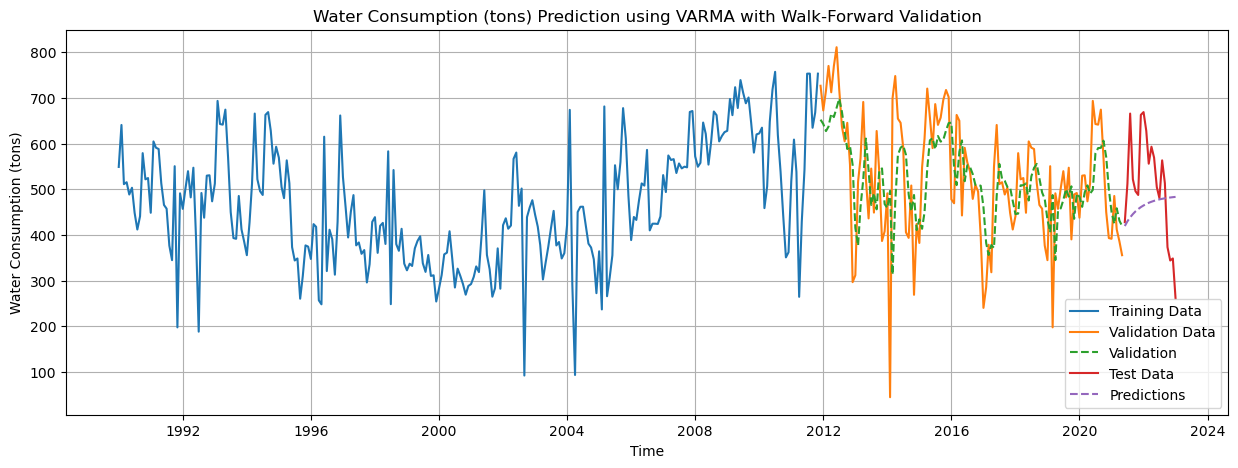

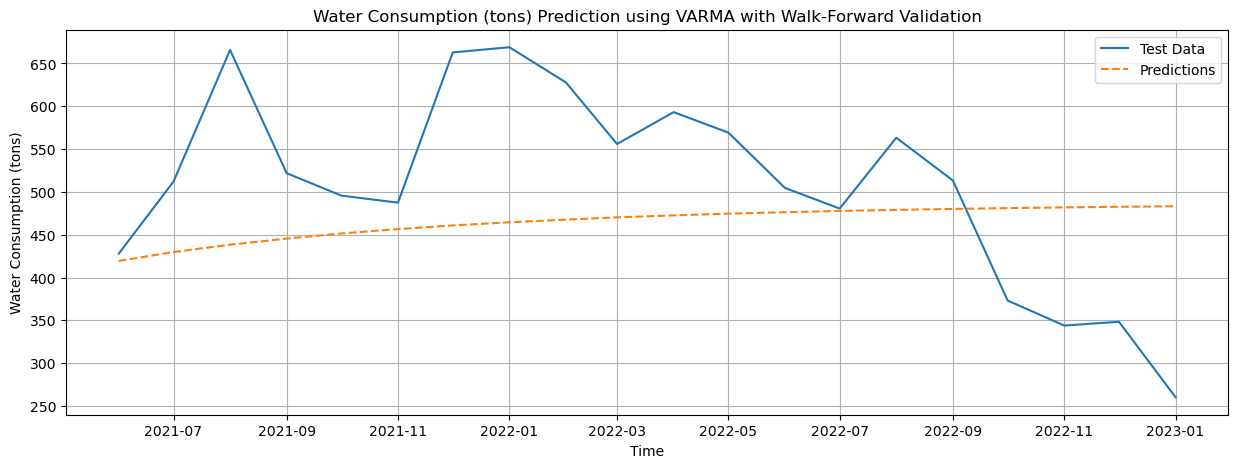

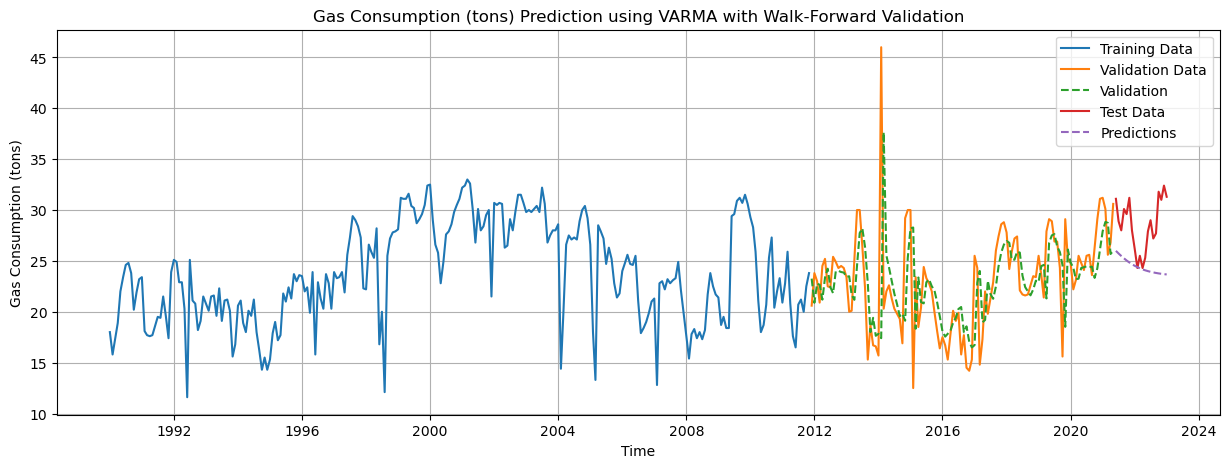

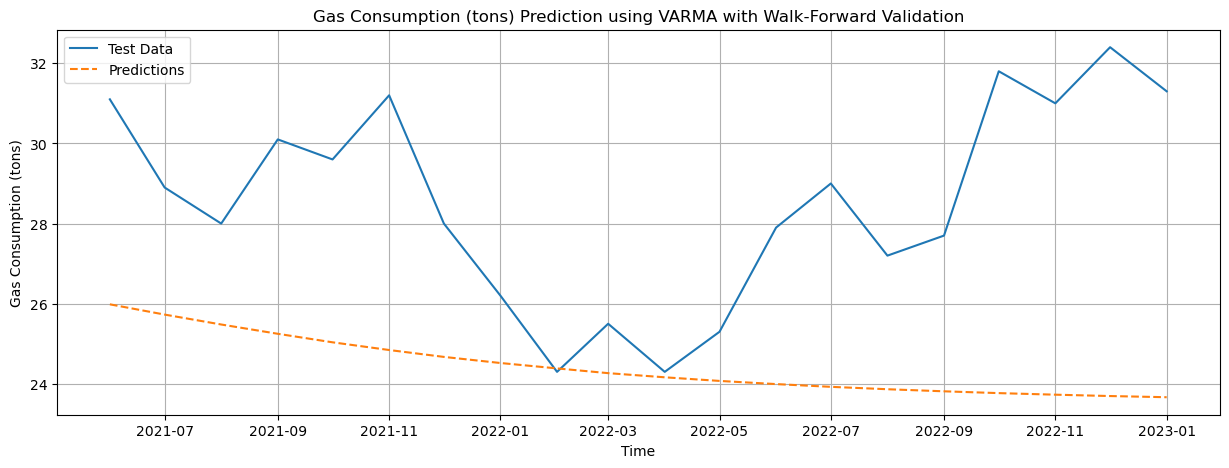

                                             Statespace Model Results                                             
Dep. Variable:     ['Water Consumption (tons)', 'Gas Consumption (tons)']   No. Observations:                  376
Model:                                                         VARMA(1,1)   Log Likelihood               -3251.497
                                                              + intercept   AIC                           6528.994
Date:                                                    Fri, 11 Aug 2023   BIC                           6580.079
Time:                                                            03:27:28   HQIC                          6549.273
Sample:                                                                 0                                         
                                                                    - 376                                         
Covariance Type:                                                      opg       

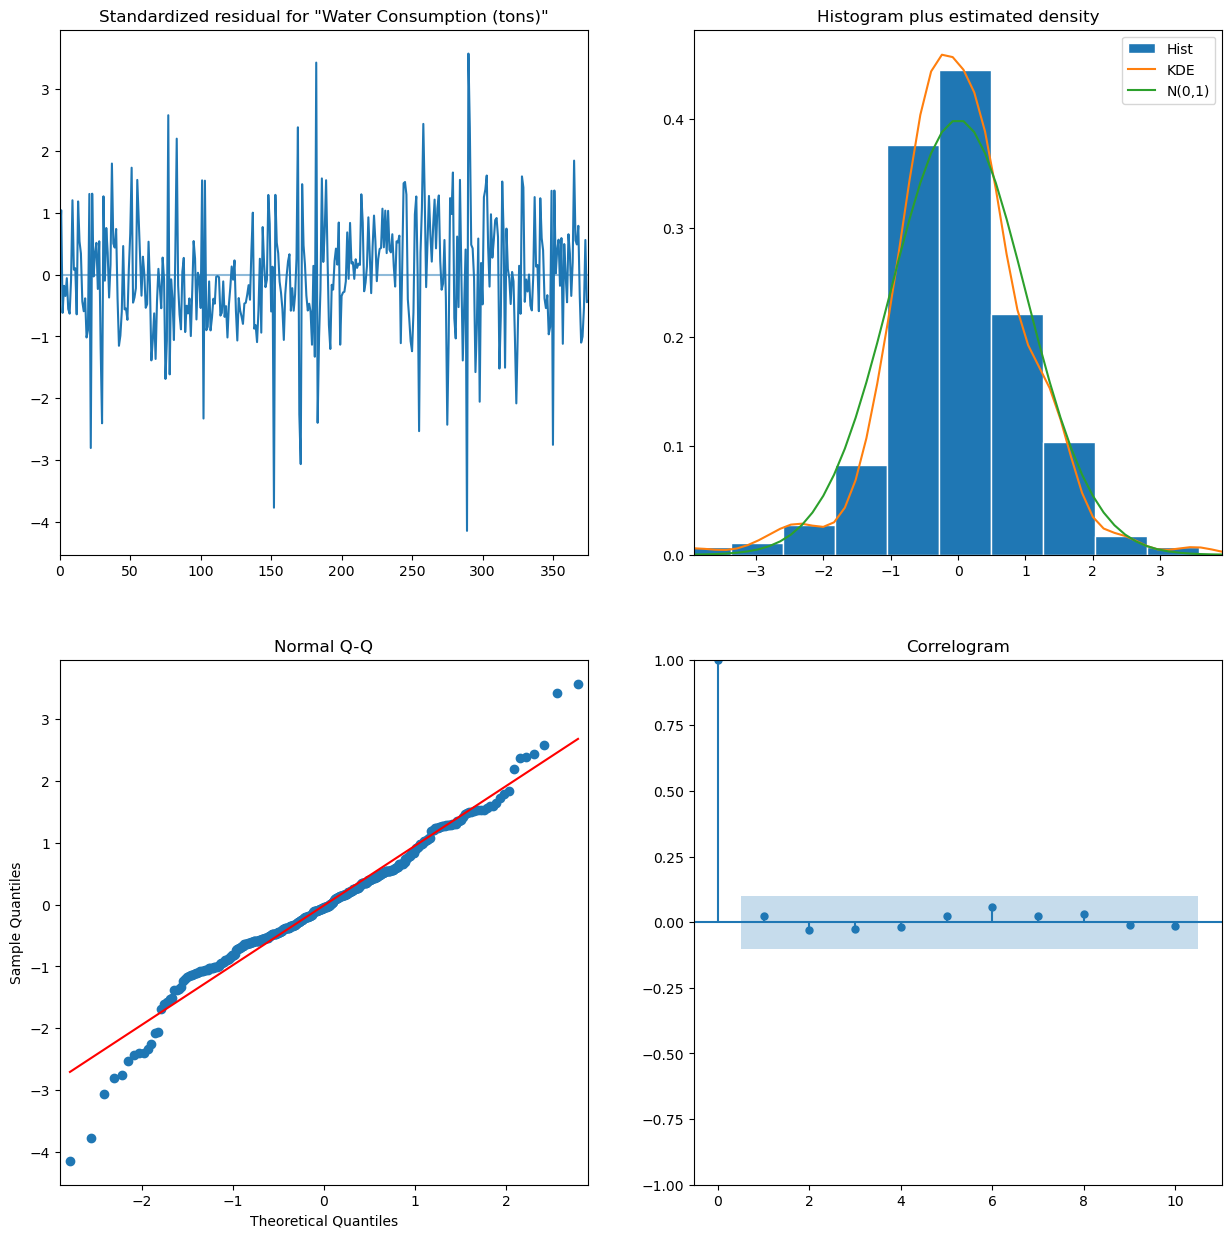

Water Consumption (tons) Validation Set RMSE for VARMA with Walk-Forward Validation: 114.66841766649773
Water Consumption (tons) Validation Set MAPE for VARIMA with Walk-Forward Validation: 26.436935745802366 %

Water Consumption (tons) Test Set RMSE for VARMA with Walk-Forward Validation: 125.26323952960045
Water Consumption (tons) Test Set MAPE for VARMA with Walk-Forward Validation: 22.096326062319555 %

Gas Consumption (tons) Validation Set RMSE for VARMA with Walk-Forward Validation: 4.692500649579508
Gas Consumption (tons) Validation Set MAPE for VARIMA with Walk-Forward Validation: 12.828898804167506 %

Gas Consumption (tons) Test Set RMSE for VARMA with Walk-Forward Validation: 4.810251752368227
Gas Consumption (tons) Test Set MAPE for VARMA with Walk-Forward Validation: 13.745953559511213 %

AIC: 6528.994377344411
BIC: 6580.07903620848


(114.66841766649773,
 0.26436935745802365,
 125.26323952960045,
 0.22096326062319555,
 4.692500649579508,
 0.12828898804167507,
 4.810251752368227,
 0.13745953559511212,
 6528.994377344411,
 6580.07903620848)

In [115]:
wf_validation_varma(data[['Water Consumption (tons)', 'Gas Consumption (tons)']], 'Water Consumption (tons)', 'Gas Consumption (tons)', (1,1), True)

#### Water and Gas Consumption VARMA (Multivariate) (GAS GRANGER CAUSE WATER)
Looking at second results
- All coefficients are statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

#### VARMA for Water and Electricity Consumption

In [116]:
orders=[]

for p in range(4):
    for q in range(4):
        try:
            val_rmse_1, val_mape_1, test_rmse_1, test_mape_1, val_rmse_2, val_mape_2, test_rmse_2, test_mape_2, aic, bic = wf_validation_varma(data[['Water Consumption (tons)', 'Electricity Consumption (MWh)']], 'Water Consumption (tons)', 'Electricity Consumption (MWh)', (p,q), False)

            orders.append((p, q, val_rmse_1, val_mape_1, test_rmse_1, test_mape_1, val_rmse_2, val_mape_2, test_rmse_2, test_mape_2, aic, bic))
            
        except:
            orders.append((p, q, None, None))   
            
order_df = pd.DataFrame(orders, columns=['p', 'q', 'val_rmse_1', 'val_mape_1', 'test_rmse_1', 'test_mape_1', 'val_rmse_2', 'val_mape_2', 'test_rmse_2', 'test_mape_2', 'aic', 'bic'])
order_df.sort_values('aic').head(5)

p  q  val_rmse_1  val_mape_1  test_rmse_1  test_mape_1  val_rmse_2  \
15  3  3  123.172301    0.286378   125.585440     0.222266   40.959283   
14  3  2  116.181654    0.254734   134.555297     0.238183   40.810365   
13  3  1  120.730156    0.264219   140.638701     0.248363   42.233263   
12  3  0  113.795065    0.266945   116.149884     0.202611   58.276598   
9   2  1  127.756956    0.288168   102.549922     0.190666   52.474963   

    val_mape_2  test_rmse_2  test_mape_2          aic          bic  
15    0.030299   143.700300     0.100523  8431.243982  8545.202068  
14    0.029654   146.043650     0.100717  8437.797047  8536.036775  
13    0.030173   116.991096     0.075239  8489.145329  8571.666701  
12    0.044639   160.990391     0.115976  8599.987175  8666.790191  
9     0.038798   143.742307     0.097249  8631.490394  8698.293410

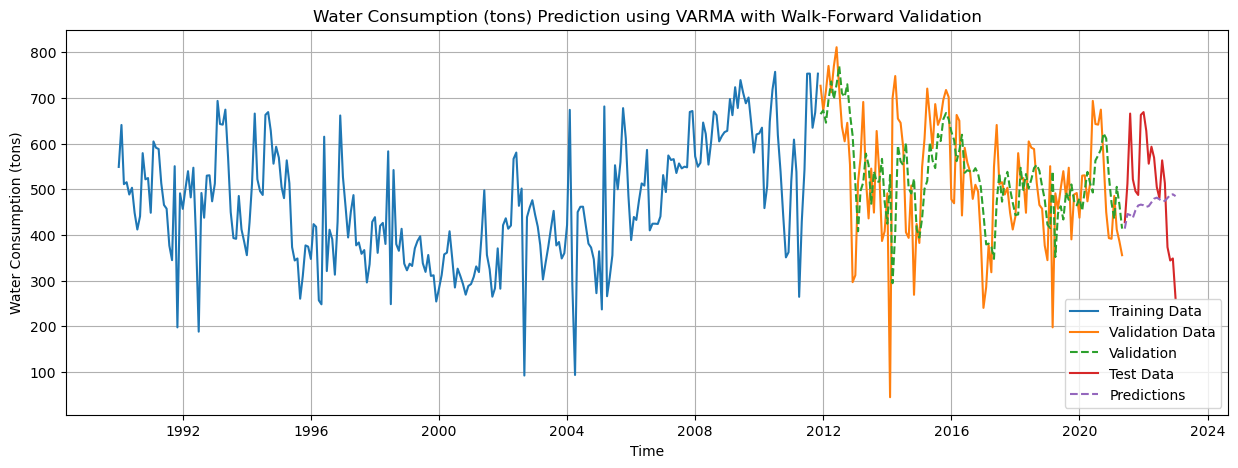

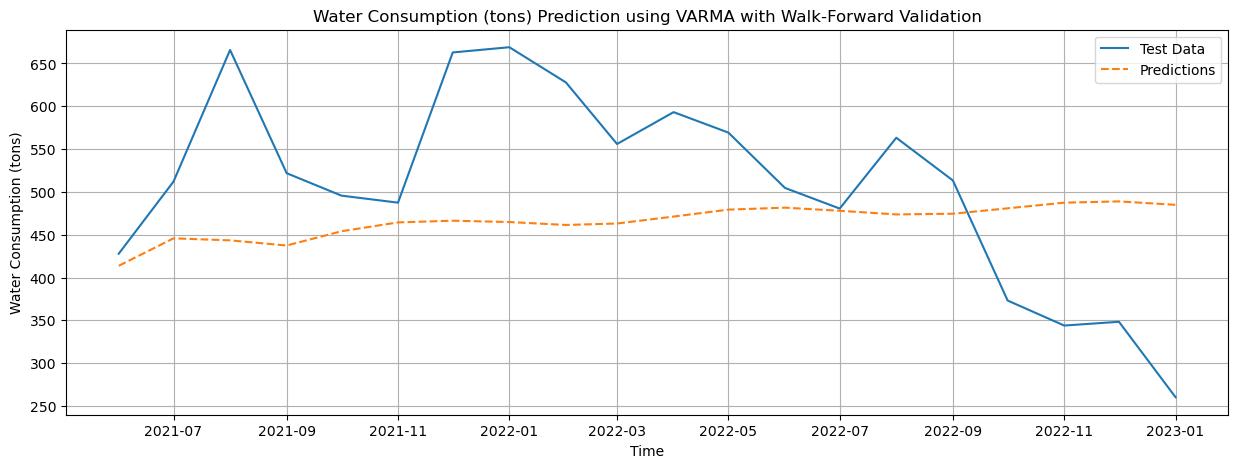

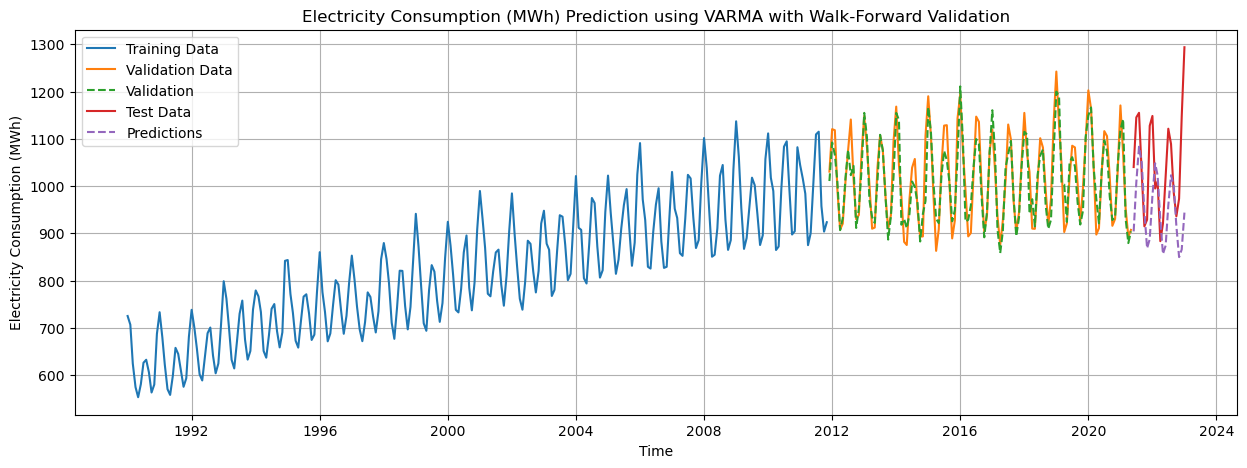

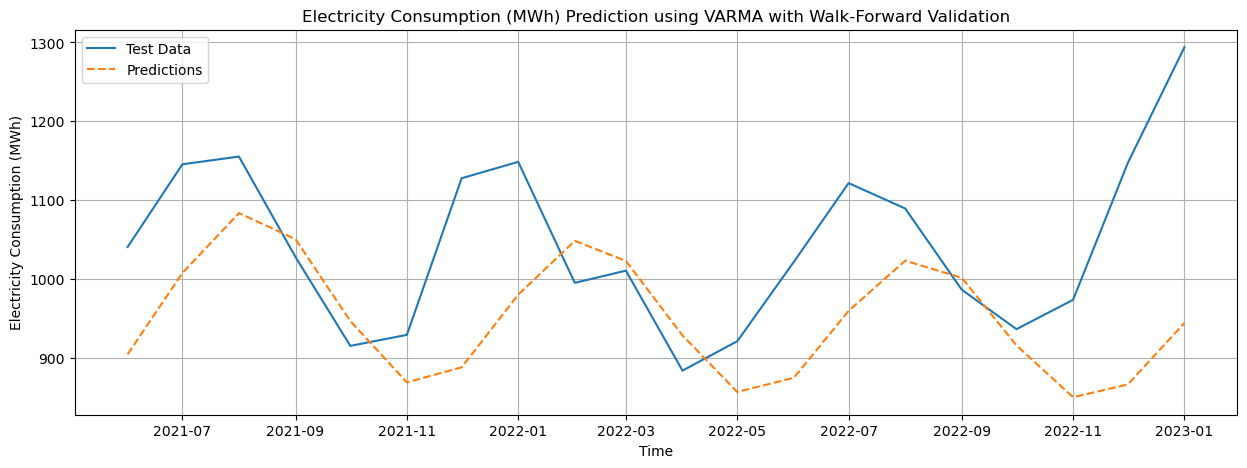

                                                 Statespace Model Results                                                
Dep. Variable:     ['Water Consumption (tons)', 'Electricity Consumption (MWh)']   No. Observations:                  376
Model:                                                                VARMA(3,3)   Log Likelihood               -4186.622
                                                                     + intercept   AIC                           8431.244
Date:                                                           Fri, 11 Aug 2023   BIC                           8545.202
Time:                                                                   04:00:06   HQIC                          8476.481
Sample:                                                                        0                                         
                                                                           - 376                                         
Covariance Type:        

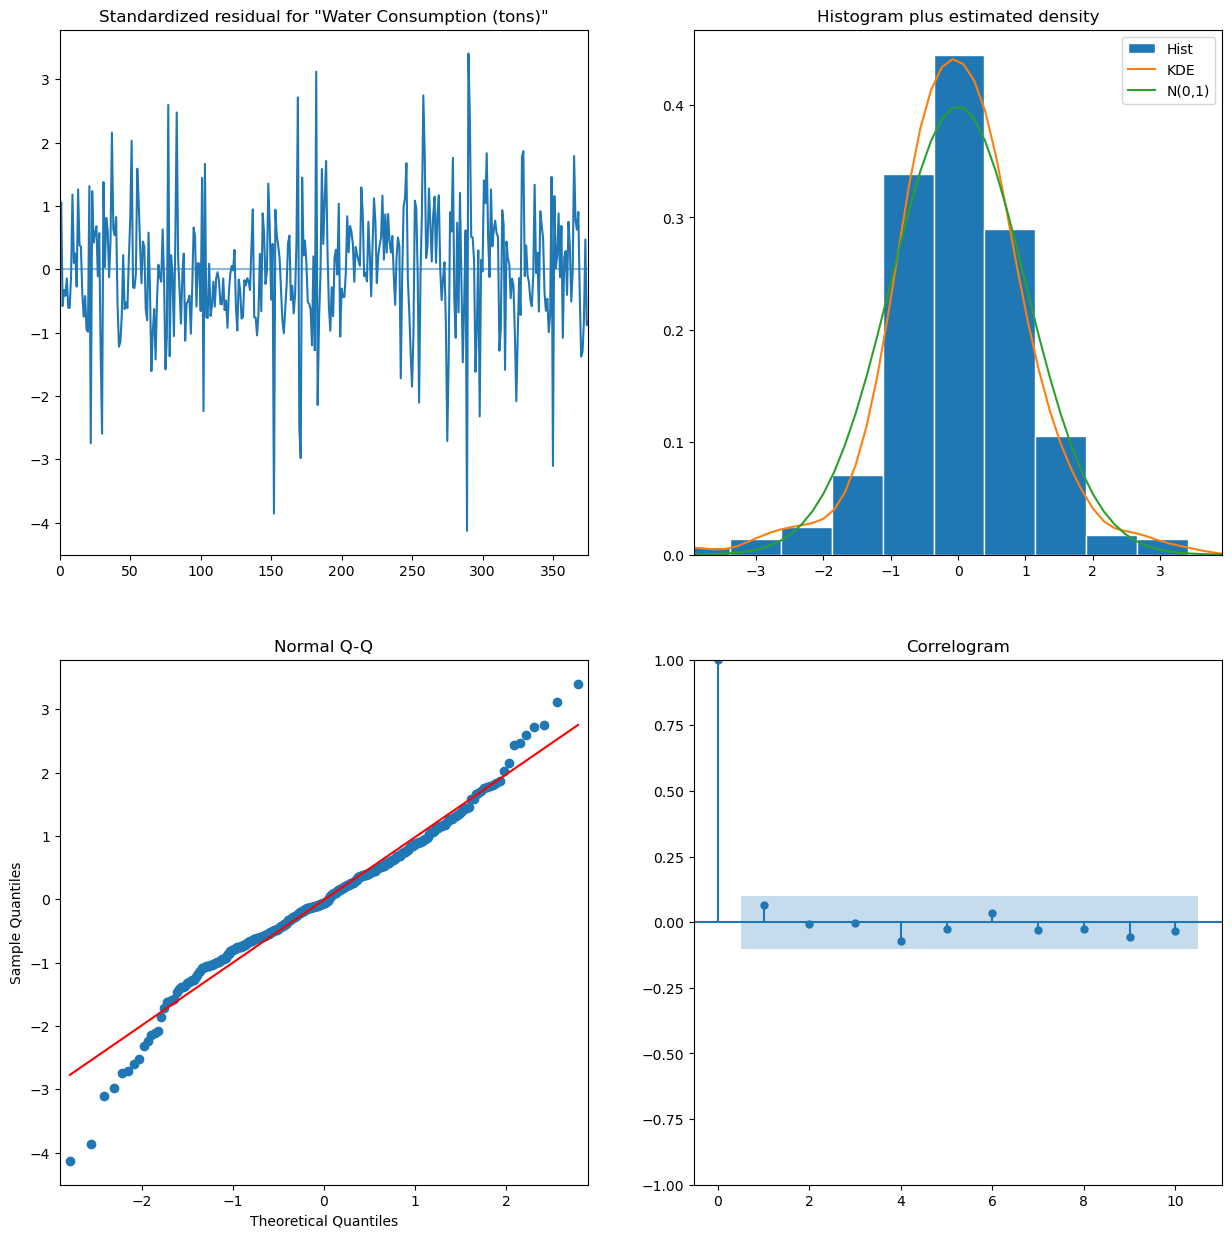

Water Consumption (tons) Validation Set RMSE for VARMA with Walk-Forward Validation: 123.17230119725532
Water Consumption (tons) Validation Set MAPE for VARIMA with Walk-Forward Validation: 28.637832166195448 %

Water Consumption (tons) Test Set RMSE for VARMA with Walk-Forward Validation: 125.5854398205231
Water Consumption (tons) Test Set MAPE for VARMA with Walk-Forward Validation: 22.226599818157297 %

Electricity Consumption (MWh) Validation Set RMSE for VARMA with Walk-Forward Validation: 40.959283362722765
Electricity Consumption (MWh) Validation Set MAPE for VARIMA with Walk-Forward Validation: 3.0299001062997037 %

Electricity Consumption (MWh) Test Set RMSE for VARMA with Walk-Forward Validation: 143.7003002836071
Electricity Consumption (MWh) Test Set MAPE for VARMA with Walk-Forward Validation: 10.05227021425834 %

AIC: 8431.24398248889
BIC: 8545.202067647197


(123.17230119725532,
 0.2863783216619545,
 125.5854398205231,
 0.22226599818157297,
 40.959283362722765,
 0.030299001062997037,
 143.7003002836071,
 0.10052270214258341,
 8431.24398248889,
 8545.202067647197)

In [117]:
wf_validation_varma(data[['Water Consumption (tons)', 'Electricity Consumption (MWh)']], 'Water Consumption (tons)', 'Electricity Consumption (MWh)', (3,3), True)

#### Water and Electricity Consumption VARMA (Multivariate) (ELECTRICITY GRANGER CAUSE WATER)
Looking at second results
- Some coefficients are not statistically significant
- The errors caused are white noise
- The residuals show no variances
- The data is normally distributed

It seems that maybe VARMA for these two time series may not be as suitable as the Water and Gas Consumption VARMA

### Conclusion

SARIMA seems to be a better model for this time series forecasting, allowing the model to take into account the seasonality of the data to better fit the model. The regression metrics used seem to have a better score on SARIMA as well.

However, it is important to note that VARMA could be a better model given a more distinct correlation between two time series, allowing for multivariate forecasting

### Reflection

Doing this assigment, I learnt how to train time series model like ARIMA, SARIMA and VARMA on different time series, and how to forecast these time series in the future.

Personally, I found it challenging to interpret the ACF and PACF plots of the different time series. Although I was familiar with the concept of how to interpret them, in real life data, the plots may look different, thus forcing me to think of other ways to train my models. It was also quite worrying sometimes during tuning when the code would run for quite long.